# Dataset
https://www.bbci.de/competition/iii/#top

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import scipy.signal
from scipy.signal import stft
from numpy import linalg

from matplotlib import mlab
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.covariance import LedoitWolf

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GRU, concatenate
from keras.optimizers import Adam
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50


import zipfile

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install mne -q

In [ ]:
from mne.decoding import CSP
from mne.filter import create_filter

# Loading dataset

## EEG Data

In [ ]:
!pwd

/home/ec2-user/SageMaker/BCI


In [ ]:
extract_dir = !pwd
extract_dir[0]

'/home/ec2-user/SageMaker/BCI'

In [ ]:
# Zip file name
zip_file = "k3b_ascii.zip"


# Specify the directory where to extract the files
extract_dir = !pwd
extract_dir = extract_dir[0]

# Open the .zip file
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    # Extract all files to the specified directory
    zip_ref.extractall(extract_dir)

_s.txt: continuous EEG signals. Each line represents a time point, each column a channel.

_HDR_TRIG.txt: a vector (length #trials) indicating the start of trials (in unit sample).

_HDR_Classlabel.txt: a vector (length #trials) defining the class labels of all trials. The class label is NaN for test trials.

_HDR_ArtifactSelection.txt a vector (length #trials) of boolean values (0/1), a '1' indicating that the respective trials was marked as artifact (see description of the original data).


https://www.bbci.de/competition/iii/download/desc_III_ascii.html

In [ ]:
# File path for the EEG data
file_path = 'k3b_s.txt'

# Define custom column names
ch_names = [f"C{i}" for i in range(1, 61)]  # C1, C2, ..., C60

# Reading as dataframe
eeg_df = pd.read_csv(file_path, delim_whitespace=True, names=ch_names)

# Adding a sample column
eeg_df['sample'] = eeg_df.index+1
eeg_df.head()

C1        C2        C3        C4         C5         C6         C7  \
0 -0.079007  3.027897  3.435340  2.493118   5.307115   5.167698   5.699518   
1  4.043424  8.484671  8.330211  5.712887  14.085459  12.144965  10.694503   
2  5.509374  8.826194  8.848780  6.153412  13.277888  12.030220  10.579603   
3  5.789237  6.632859  7.745069  5.952848   6.242438   8.147380   8.511391   
4  3.106104  2.094402  4.073040  3.116299  -1.313143   2.091778   3.985584   

         C8         C9        C10  ...        C52        C53        C54  \
0  5.650690   6.598334   6.873475  ...   8.491150  10.667896   9.511298   
1  9.141956   9.526546  30.638094  ...  12.216795  15.419495  14.352876   
2  9.337083   9.707801  28.054416  ...  11.802236  15.454526  14.668870   
3  9.211001  10.432822   8.094850  ...  11.021574  11.766624  12.344253   
4  6.503243   8.557767  -8.184932  ...   8.579984   5.518208   7.376277   

         C55        C56        C57        C58        C59        C60  sample  
0   7.631612   8.236697   8.996108   9.612918   7.882010   7.967287       1  
1  12.500155  12.794380  13.118542  13.036466  11.741996  12.050928       2  
2  13.521594  13.506372  13.420183  13.191850  12.655410  13.098292       3  
3  13.010874  13.204244  13.183897  11.574326  12.312300  13.353115       4  
4   9.357081   9.995597  10.479179   7.333101   9.015664  10.694753       5  

[5 rows x 61 columns]

In [ ]:
eeg_df.shape

(986780, 61)

## Trial data

In [ ]:
# Reading the Trial data

file_path = 'k3b_HDR_TRIG.txt'

trial_df = pd.read_csv(file_path, delim_whitespace=True, names=['start_sample'])
trial_df['end_sample'] = trial_df['start_sample'].shift(-1) -1
trial_df['end_sample'] = trial_df['end_sample'].fillna(eeg_df['sample'].max())
trial_df['end_sample'] = trial_df['end_sample'].astype('int')
trial_df['trial'] = trial_df.index+1
trial_df.head()

start_sample  end_sample  trial
0          2425        4984      1
1          4985        7544      2
2          7545       10104      3
3         10105       12665      4
4         12666       15225      5

In [ ]:
trial_df.shape

(360, 3)

## Artifact data

In [ ]:
# Reading the Artifact data

file_path = 'k3b_HDR_ArtifactSelection.txt'

art_df = pd.read_csv(file_path, delim_whitespace=True, names=['artifact'])
art_df.head()

artifact
0         0
1         0
2         1
3         0
4         0

In [ ]:
art_df.shape

(360, 1)

## Class label data

In [ ]:
# Reading the Class label data

file_path = 'k3b_HDR_Classlabel.txt'

class_df = pd.read_csv(file_path, delim_whitespace=True, names=['label'])
class_df['label'] = class_df['label'].fillna('Test')
class_df.head()

label
0   3.0
1   4.0
2  Test
3  Test
4   3.0

In [ ]:
class_df.shape

(360, 1)

# Consolidating the datasets

In [ ]:
# Appending artifact data to trial data

trial_df = pd.concat([trial_df, art_df], axis=1)
trial_df.head()

start_sample  end_sample  trial  artifact
0          2425        4984      1         0
1          4985        7544      2         0
2          7545       10104      3         1
3         10105       12665      4         0
4         12666       15225      5         0

In [ ]:
# Appending label data to trial data

trial_df = pd.concat([trial_df, class_df], axis=1)
trial_df.head()

start_sample  end_sample  trial  artifact label
0          2425        4984      1         0   3.0
1          4985        7544      2         0   4.0
2          7545       10104      3         1  Test
3         10105       12665      4         0  Test
4         12666       15225      5         0   3.0

In [ ]:
trial_df.label.value_counts()

Test    180
3.0      45
4.0      45
2.0      45
1.0      45
Name: label, dtype: int64

In [ ]:
trial_df.isna().sum()

start_sample    0
end_sample      0
trial           0
artifact        0
label           0
dtype: int64

In [ ]:
# Approx. 25% trials are impacted by presence of artifact

pd.pivot_table(trial_df, index='label', columns='artifact', values='trial', aggfunc='count')

artifact    0   1
label            
1.0        36   9
2.0        37   8
3.0        38   7
4.0        38   7
Test      149  31

Consolidating all the data into one dataframe. The below cell will take ~10 mins

In [ ]:
# Initialize empty lists to store trial numbers, artifact and class labels
trial_numbers = []
class_labels = []
art_labels = []

# Iterate through the rows of the eeg DataFrame
for sample in eeg_df['sample']:
    # Check if the sample falls within a trial range in the trial DataFrame
    trial_match = trial_df[(sample >= trial_df['start_sample']) & (sample <= trial_df['end_sample'])]
    if not trial_match.empty:
        trial_number = trial_match.iloc[0]['trial']
        trial_numbers.append(trial_number)

        class_label = trial_match.iloc[0]['label']
        class_labels.append(class_label)

        art_label = trial_match.iloc[0]['artifact']
        art_labels.append(art_label)
    else:
        trial_numbers.append(None)  # No matching trial found
        class_labels.append(None)  # No matching trial found
        art_labels.append(None)  # No matching trial found

# Add the trial, artifact and label columns to the eeg dataFrame
eeg_df['trial'] = trial_numbers
eeg_df['artifact'] = art_labels
eeg_df['label'] = class_labels

In [ ]:
# Spot checking for trial 1

eeg_df.iloc[2422:4988, -5:]

C60  sample  trial  artifact label
2422  5.248458    2423    NaN       NaN  None
2423  4.121192    2424    NaN       NaN  None
2424  3.497092    2425    1.0       0.0   3.0
2425  3.879326    2426    1.0       0.0   3.0
2426  5.000114    2427    1.0       0.0   3.0
...        ...     ...    ...       ...   ...
4983 -3.791269    4984    1.0       0.0   3.0
4984 -4.370018    4985    2.0       0.0   4.0
4985 -6.350293    4986    2.0       0.0   4.0
4986 -7.356627    4987    2.0       0.0   4.0
4987 -7.725904    4988    2.0       0.0   4.0

[2566 rows x 5 columns]

In [ ]:
# Spot checking for trial 3

eeg_df.iloc[7542:10108, -5:]

C60  sample  trial  artifact label
7542   0.998534    7543    2.0       0.0   4.0
7543   2.389261    7544    2.0       0.0   4.0
7544   3.704405    7545    3.0       1.0  Test
7545   3.589951    7546    3.0       1.0  Test
7546   3.168846    7547    3.0       1.0  Test
...         ...     ...    ...       ...   ...
10103 -6.263912   10104    3.0       1.0  Test
10104 -6.451790   10105    4.0       0.0  Test
10105 -5.618218   10106    4.0       0.0  Test
10106 -6.134341   10107    4.0       0.0  Test
10107 -6.518735   10108    4.0       0.0  Test

[2566 rows x 5 columns]

# Data Pre-processing

## Splitting into Train & Test data

In [ ]:
# Splitting into train and test data, also dropping the trials which are impacted by artifacts

train_df = eeg_df[(eeg_df.label != 'Test') & (eeg_df.artifact == 0.0)]
test_df = eeg_df[(eeg_df.label == 'Test') & (eeg_df.artifact == 0.0)]

In [ ]:
train_df.shape

(401423, 64)

## Null value treatment

In [ ]:
# There are null values in channels, indicating the breaks in between the runs or saturation of the analog-to-digital converter
train_df.isna().sum()

C1          400
C2          401
C3          401
C4          402
C5          400
           ... 
C60         400
sample        0
trial         0
artifact      0
label         0
Length: 64, dtype: int64

In [ ]:
test_df.isna().sum()

C1          300
C2          300
C3          300
C4          300
C5          300
           ... 
C60         300
sample        0
trial         0
artifact      0
label         0
Length: 64, dtype: int64

In [ ]:
# Creating a function to exclude the trials that have Null values in any channel

def null_exclude(ip_df):

  # Getting the Trial numbers which are impacted by null values
  trial_exclude = ip_df[ip_df.isnull().any(axis=1)]['trial'].unique()


  # Excluding the above trials from the training data
  op_df = ip_df[ip_df.notnull().all(axis=1)]


  return op_df, trial_exclude

In [ ]:
# Applying the above function to train & test datasets

train_df, train_trial_exclude = null_exclude(train_df)
test_df, test_trial_exclude = null_exclude(test_df)

In [ ]:
train_trial_exclude

array([ 79., 160., 200., 280., 320.])

In [ ]:
test_trial_exclude

array([ 40.,  80., 120.])

In [ ]:
# Checking the labels in training data

train_df.label.unique()

array([3.0, 4.0, 2.0, 1.0], dtype=object)

In [ ]:
# Creating a dictionary to store class and trial information

class_trial = {}

for l in train_df.label.unique():
  cl_l = train_df[train_df.label==l]['trial'].unique()
  class_trial[l] = cl_l

In [ ]:
# Count of trials in each class

for k in class_trial.keys():
  print("Class label:",k, "\t number of trials:", len(class_trial[k]))

Class label: 3.0 	 number of trials: 38
Class label: 4.0 	 number of trials: 38
Class label: 2.0 	 number of trials: 37
Class label: 1.0 	 number of trials: 36


In [ ]:
# Trials in each class label

class_trial

{3.0: array([  1.,   5.,   6.,   7.,  31.,  37.,  39.,  46.,  55.,  71.,  79.,
        100., 125., 128., 130., 132., 133., 151., 178., 184., 185., 194.,
        200., 214., 216., 217., 225., 248., 249., 255., 264., 270., 294.,
        296., 315., 319., 325., 350.]),
 4.0: array([  2.,  12.,  19.,  27.,  45.,  48.,  56.,  68.,  75.,  77.,  90.,
         92., 101., 116., 122., 129., 138., 140., 142., 153., 158., 168.,
        175., 180., 181., 190., 202., 215., 229., 244., 246., 253., 295.,
        320., 337., 341., 344., 345.]),
 2.0: array([  9.,  21.,  23.,  26.,  30.,  44.,  47.,  51.,  54.,  64.,  86.,
         94.,  95., 139., 152., 154., 160., 161., 173., 174., 177., 191.,
        195., 206., 230., 238., 242., 273., 274., 280., 291., 306., 307.,
        323., 336., 340., 346.]),
 1.0: array([ 20.,  25.,  29.,  32.,  36.,  38.,  41.,  42.,  43.,  57.,  74.,
         76.,  83.,  85.,  89., 110., 126., 145., 150., 156., 172., 198.,
        204., 207., 213., 219., 254., 257., 272., 27

## Selecting relevant samples in each trial

**Training Data**

In [ ]:
sample_rate = 250
start_time = 3
end_time = 7

# The time window (in samples) to extract for each trial, here 3-7 seconds
idx_start = int(start_time*sample_rate)
idx_end = int(end_time*sample_rate)

idx_start, idx_end

(750, 1750)

In [ ]:
# Setting the parameters

nchannels = len(ch_names)
nsamples = idx_end - idx_start

nchannels, nsamples

(60, 1000)

In [ ]:
# Initializing an empty dictionary, this will have labels as keys and corresponding trial data as values
trials ={}


# Iterating to fill the dictionary
for l in set(train_df.label):

  # Subsetting data for the given label
  l_df = train_df[train_df.label==l]

  # Initializing a 3D array for the given label
  ntrial = l_df['trial'].nunique()
  trials[l] = np.zeros((nchannels, nsamples, ntrial))

  # Getting the array of trial numbers for given label
  trial_arr = train_df[train_df.label==l]['trial'].unique()

  # Iterating over the trials to fill in the array
  for i, t in enumerate(trial_arr):

      # Subsetting the trial dataframe for given trial from the label dataframe
      t_df = l_df[l_df.trial==t]

      # Adding an index column
      t_df['idx'] = range(1, len(t_df) + 1)

      # Selecting the samples that fall within the visual cue time range and selecting only channel columns
      t_df = t_df[(t_df.idx>=idx_start) & (t_df.idx<idx_end)][ch_names]

      # Updating the dictionary
      trials[l][:,:,i] = t_df.T


In [ ]:
trials.keys()

dict_keys([1.0, 2.0, 3.0, 4.0])

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)
print('Shape of trials[3.0]:', trials[3.0].shape)
print('Shape of trials[4.0]:', trials[4.0].shape)

Shape of trials[1.0]: (60, 1000, 36)
Shape of trials[2.0]: (60, 1000, 37)
Shape of trials[3.0]: (60, 1000, 38)
Shape of trials[4.0]: (60, 1000, 38)


In [ ]:
# Checking one entry

trials[1.0][-5:,:5,0]

array([[ 3.9389845 ,  4.618187  ,  4.135719  ,  2.1472951 ,  0.04645143],
       [ 1.4349614 ,  2.0206486 ,  1.7164935 ,  0.10019781, -1.4105233 ],
       [ 7.8705771 ,  8.9480775 ,  8.2806896 ,  5.8480351 ,  3.1300849 ],
       [ 6.5652105 ,  7.3835737 ,  6.7738583 ,  4.5459628 ,  1.9749575 ],
       [ 2.7520596 ,  3.3891163 ,  2.9464159 ,  1.074117  , -0.7333964 ]])

In [ ]:
# Comparing with original data

qwe = train_df[train_df.trial==20.0]
qwe['idx'] = range(1, len(qwe) + 1)
qwe = qwe[(qwe.idx>=idx_start) & (qwe.idx<idx_end)]
qwe.iloc[:5, -10:]

C56       C57       C58       C59       C60  sample  trial  \
51815  3.938985  1.434961  7.870577  6.565211  2.752060   51816   20.0   
51816  4.618187  2.020649  8.948078  7.383574  3.389116   51817   20.0   
51817  4.135719  1.716493  8.280690  6.773858  2.946416   51818   20.0   
51818  2.147295  0.100198  5.848035  4.545963  1.074117   51819   20.0   
51819  0.046451 -1.410523  3.130085  1.974957 -0.733396   51820   20.0   

       artifact label  idx  
51815       0.0   1.0  750  
51816       0.0   1.0  751  
51817       0.0   1.0  752  
51818       0.0   1.0  753  
51819       0.0   1.0  754

**Testing Data**

In [ ]:
test_df.head()

C1        C2        C3        C4        C5        C6        C7  \
10104 -2.597776 -4.405913 -4.917826 -2.481587 -3.142725 -5.200115 -4.957515   
10105 -0.616522 -2.512360 -2.892604 -0.844841 -2.887223 -3.245740 -2.815895   
10106 -0.292236 -1.954539 -1.809916 -0.278964 -3.676543 -2.231537 -1.698806   
10107 -1.131826 -2.204989 -1.319378 -1.066894 -3.507729 -1.879898 -1.647739   
10108 -2.562238 -2.853882 -1.792397 -2.288186 -3.338915 -2.357387 -2.487152   

             C8        C9       C10  ...       C55       C56       C57  \
10104 -3.895509 -2.842570 -3.221138  ... -0.737985 -2.408046 -4.489780   
10105 -2.163384 -1.661285 -1.911031  ...  0.746443 -1.710107 -4.268576   
10106 -1.424905 -0.714382 -2.031080  ...  0.364597 -1.972419 -4.328905   
10107 -1.277809 -0.920638 -1.822298  ... -0.442054 -1.918552 -3.496877   
10108 -1.788140 -1.901917 -1.049805  ... -0.422962 -0.993431 -1.438174   

            C58       C59       C60  sample  trial  artifact  label  
10104  2.256367  0.498194 -6.451790   10105    4.0       0.0   Test  
10105  3.868797  2.371388 -5.618218   10106    4.0       0.0   Test  
10106  3.068950  1.968003 -6.134341   10107    4.0       0.0   Test  
10107  1.586432  0.852896 -6.518735   10108    4.0       0.0   Test  
10108  0.987821  0.377642 -5.786660   10109    4.0       0.0   Test  

[5 rows x 64 columns]

In [ ]:
# Checking the sample count in each trial

trial_sample = pd.pivot_table(test_df, index='trial', values='sample', aggfunc='count').reset_index()
trial_sample

trial  sample
0      4.0    2561
1      8.0    2560
2     10.0    2560
3     11.0    2560
4     13.0    2560
..     ...     ...
144  354.0    2560
145  355.0    2560
146  356.0    2560
147  357.0    2560
148  360.0    6938

[149 rows x 2 columns]

In [ ]:
# Checking if all the trials have the minimum sampels needed

trial_sample[trial_sample['sample']<idx_end]

Empty DataFrame
Columns: [trial, sample]
Index: []

In [ ]:
# Initializing an empty dictionary, this will have 'Test' as key and trial data as values
test_trials ={'Test': None}


# Subsetting the data to exclude the last trial
#l_df = test_df[test_df.trial!=640.0]
l_df = test_df.copy()

# Initializing a 3D array for the given label
ntrial = l_df['trial'].nunique()
test_trials['Test'] = np.zeros((nchannels, nsamples, ntrial))

# Getting the array of trial numbers for given label
trial_arr = l_df['trial'].unique()

# Iterating over the trials to fill in the array
for i, t in enumerate(trial_arr):

    # Subsetting the trial dataframe for given trial from the label dataframe
    t_df = l_df[l_df.trial==t]

    # Adding an index column
    t_df['idx'] = range(1, len(t_df) + 1)

    # Selecting the samples that fall within the visual cue time range and selecting only channel columns
    t_df = t_df[(t_df.idx>=idx_start) & (t_df.idx<idx_end)][ch_names]

    # Updating the dictionary
    test_trials['Test'][:,:,i] = t_df.T

In [ ]:
test_trials['Test'].shape

(60, 1000, 149)

## PSD analysis

In [ ]:
# Creating a function to perform PSD

def psd(label_trials):
    '''
    For a given class label, calculates for each trial the Power Spectral Density (PSD).

    Parameters
    ----------
    label_trials : 3d-array (channels x samples x trials)
        The EEG signal

    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.
    freqs : list of floats
        the frequencies for which the PSD was computed (useful for plotting later)
    '''

    nchannels, nsamples, ntrials = label_trials.shape

    trials_PSD = np.zeros((nchannels, int(nsamples/2)+1, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(label_trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()

    return trials_PSD, freqs

In [ ]:
# Apply the function on training data

psd_1, freqs = psd(trials[1.0])
psd_2, freqs = psd(trials[2.0])
psd_3, freqs = psd(trials[3.0])
psd_4, freqs = psd(trials[4.0])

trials_PSD = {1.0: psd_1, 2.0: psd_2, 3.0: psd_3, 4.0: psd_4}

In [ ]:
trials_PSD[1.0].shape, trials_PSD[2.0].shape, trials_PSD[3.0].shape, trials_PSD[4.0].shape

((60, 501, 36), (60, 501, 37), (60, 501, 38), (60, 501, 38))

In [ ]:
# Creating a function to plot the PSDs

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().

    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd()
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(20, 20))

    nchans = len(chan_ind)

    # Maximum of 3 plots per row
    nrows = 10
    ncols = 6

    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)

        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # All plot decoration below...

        plt.xlim(1,30)

        if maxy != None:
            plt.ylim(0,maxy)

        plt.grid()

        plt.xlabel('Frequency (Hz)')

        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()

    plt.tight_layout()

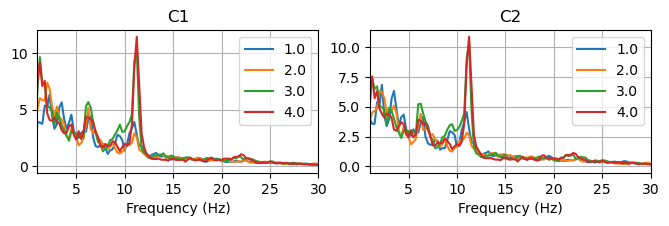

In [ ]:
# Plotting few channels

plot_psd(
    trials_PSD,
    freqs,
    [ch_names.index(ch) for ch in ['C1', 'C2']],
    chan_lab=['C1', 'C2'],
    maxy=None
)

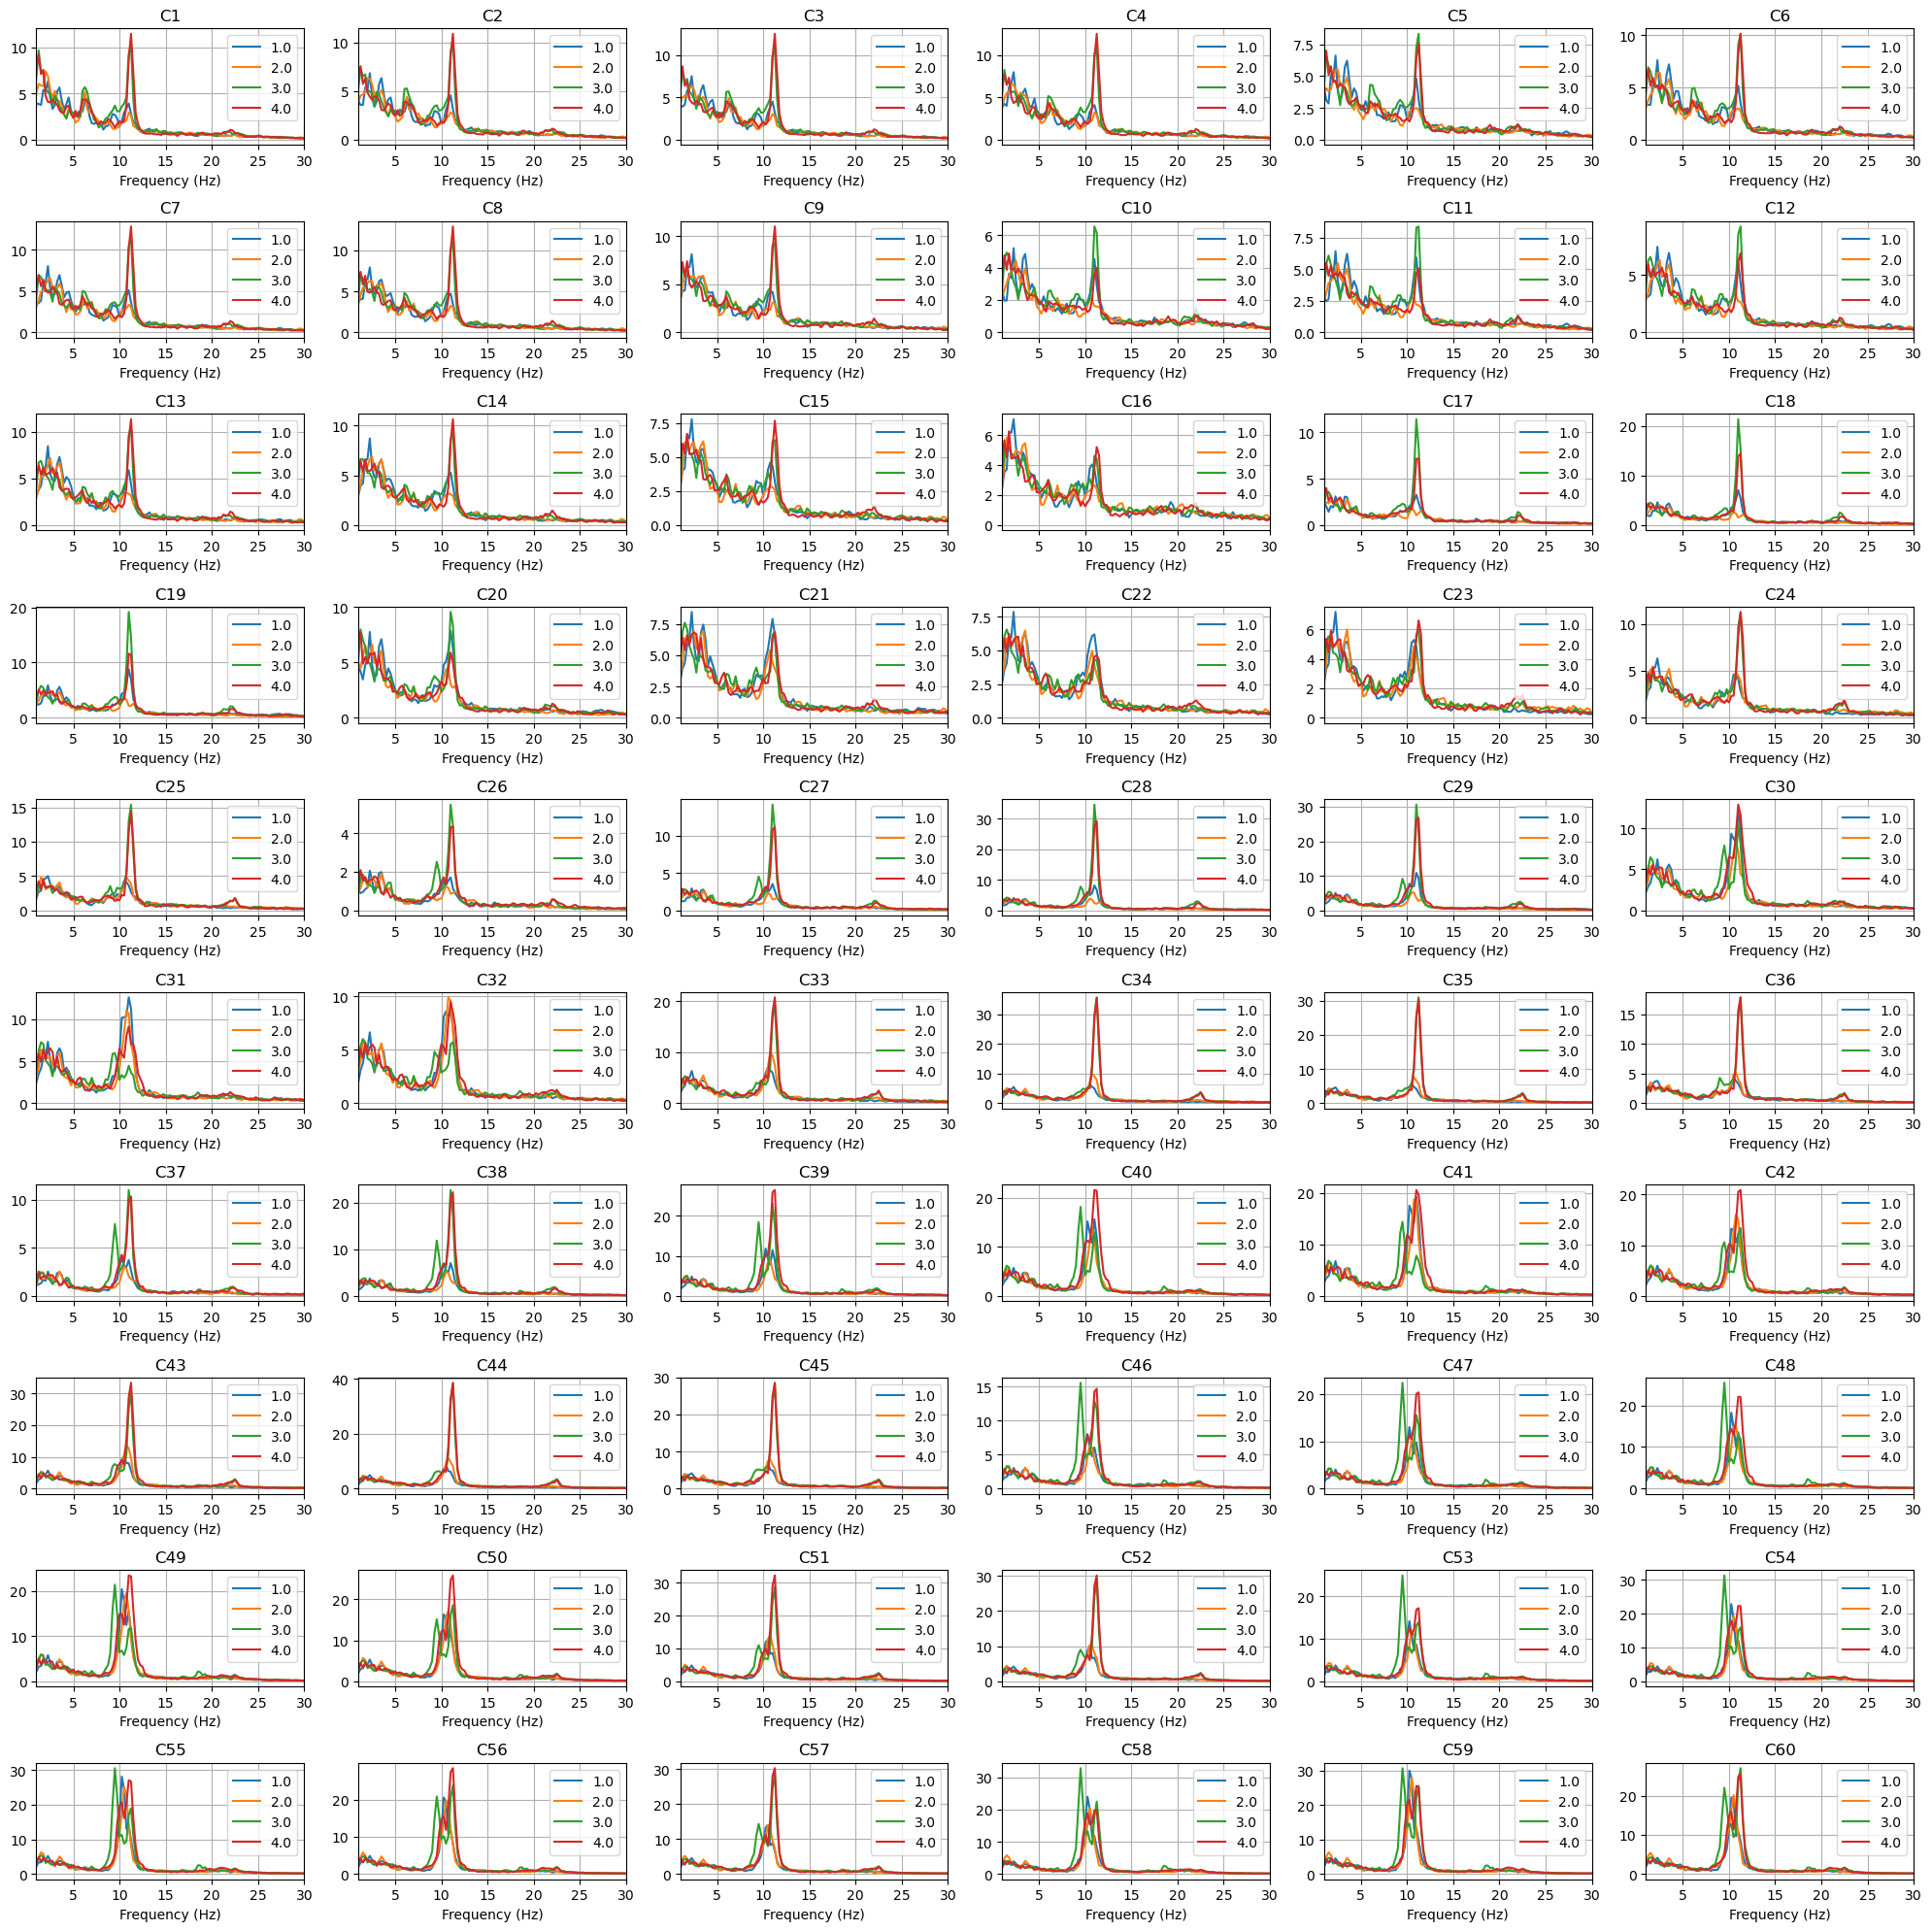

In [ ]:
# Plotting all channels

plot_psd(
    trials_PSD,
    freqs,
    [ch_names.index(ch) for ch in ch_names],
    chan_lab=ch_names,
    maxy=None
)

A spike of mu activity can be seen on each channel for all classes.

## Filtering

In [ ]:
# Creating a bandpass filter

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)

    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)

    return trials_filt

In [ ]:
# Apply the function on testing data
test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}
print("Shape of filtered test trials:", test_trials_filt['Test'].shape)

Shape of filtered test trials: (60, 1000, 149)


In [ ]:
# Apply the function on training data
trials_filt = {1.0: bandpass(trials[1.0], 8, 15, sample_rate),
               2.0: bandpass(trials[2.0], 8, 15, sample_rate),
               3.0: bandpass(trials[3.0], 8, 15, sample_rate),
               4.0: bandpass(trials[4.0], 8, 15, sample_rate)}

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)
print('Shape of filtered trials[3.0]:', trials_filt[3.0].shape)
print('Shape of filtered trials[4.0]:', trials_filt[4.0].shape)

Shape of filtered trials[1.0]: (60, 1000, 36)
Shape of filtered trials[2.0]: (60, 1000, 37)
Shape of filtered trials[3.0]: (60, 1000, 38)
Shape of filtered trials[4.0]: (60, 1000, 38)


Plotting the PSD of the resulting trials_filt shows the suppression of frequencies outside the passband of the filter

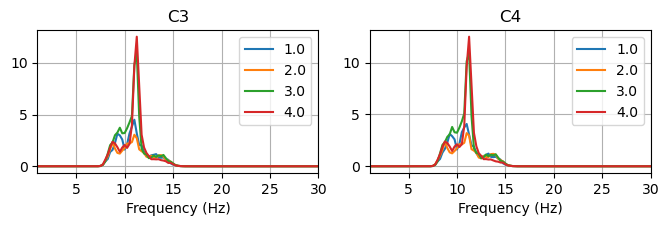

In [ ]:
psd_1, freqs = psd(trials_filt[1.0])
psd_2, freqs = psd(trials_filt[2.0])
psd_3, freqs = psd(trials_filt[3.0])
psd_4, freqs = psd(trials_filt[4.0])
trials_PSD = {1.0: psd_1, 2.0: psd_2, 3.0: psd_3, 4.0: psd_4}

plot_psd(
    trials_PSD,
    freqs,
    [ch_names.index(ch) for ch in ['C3', 'C4']],
    chan_lab=['C3', 'C4']
)

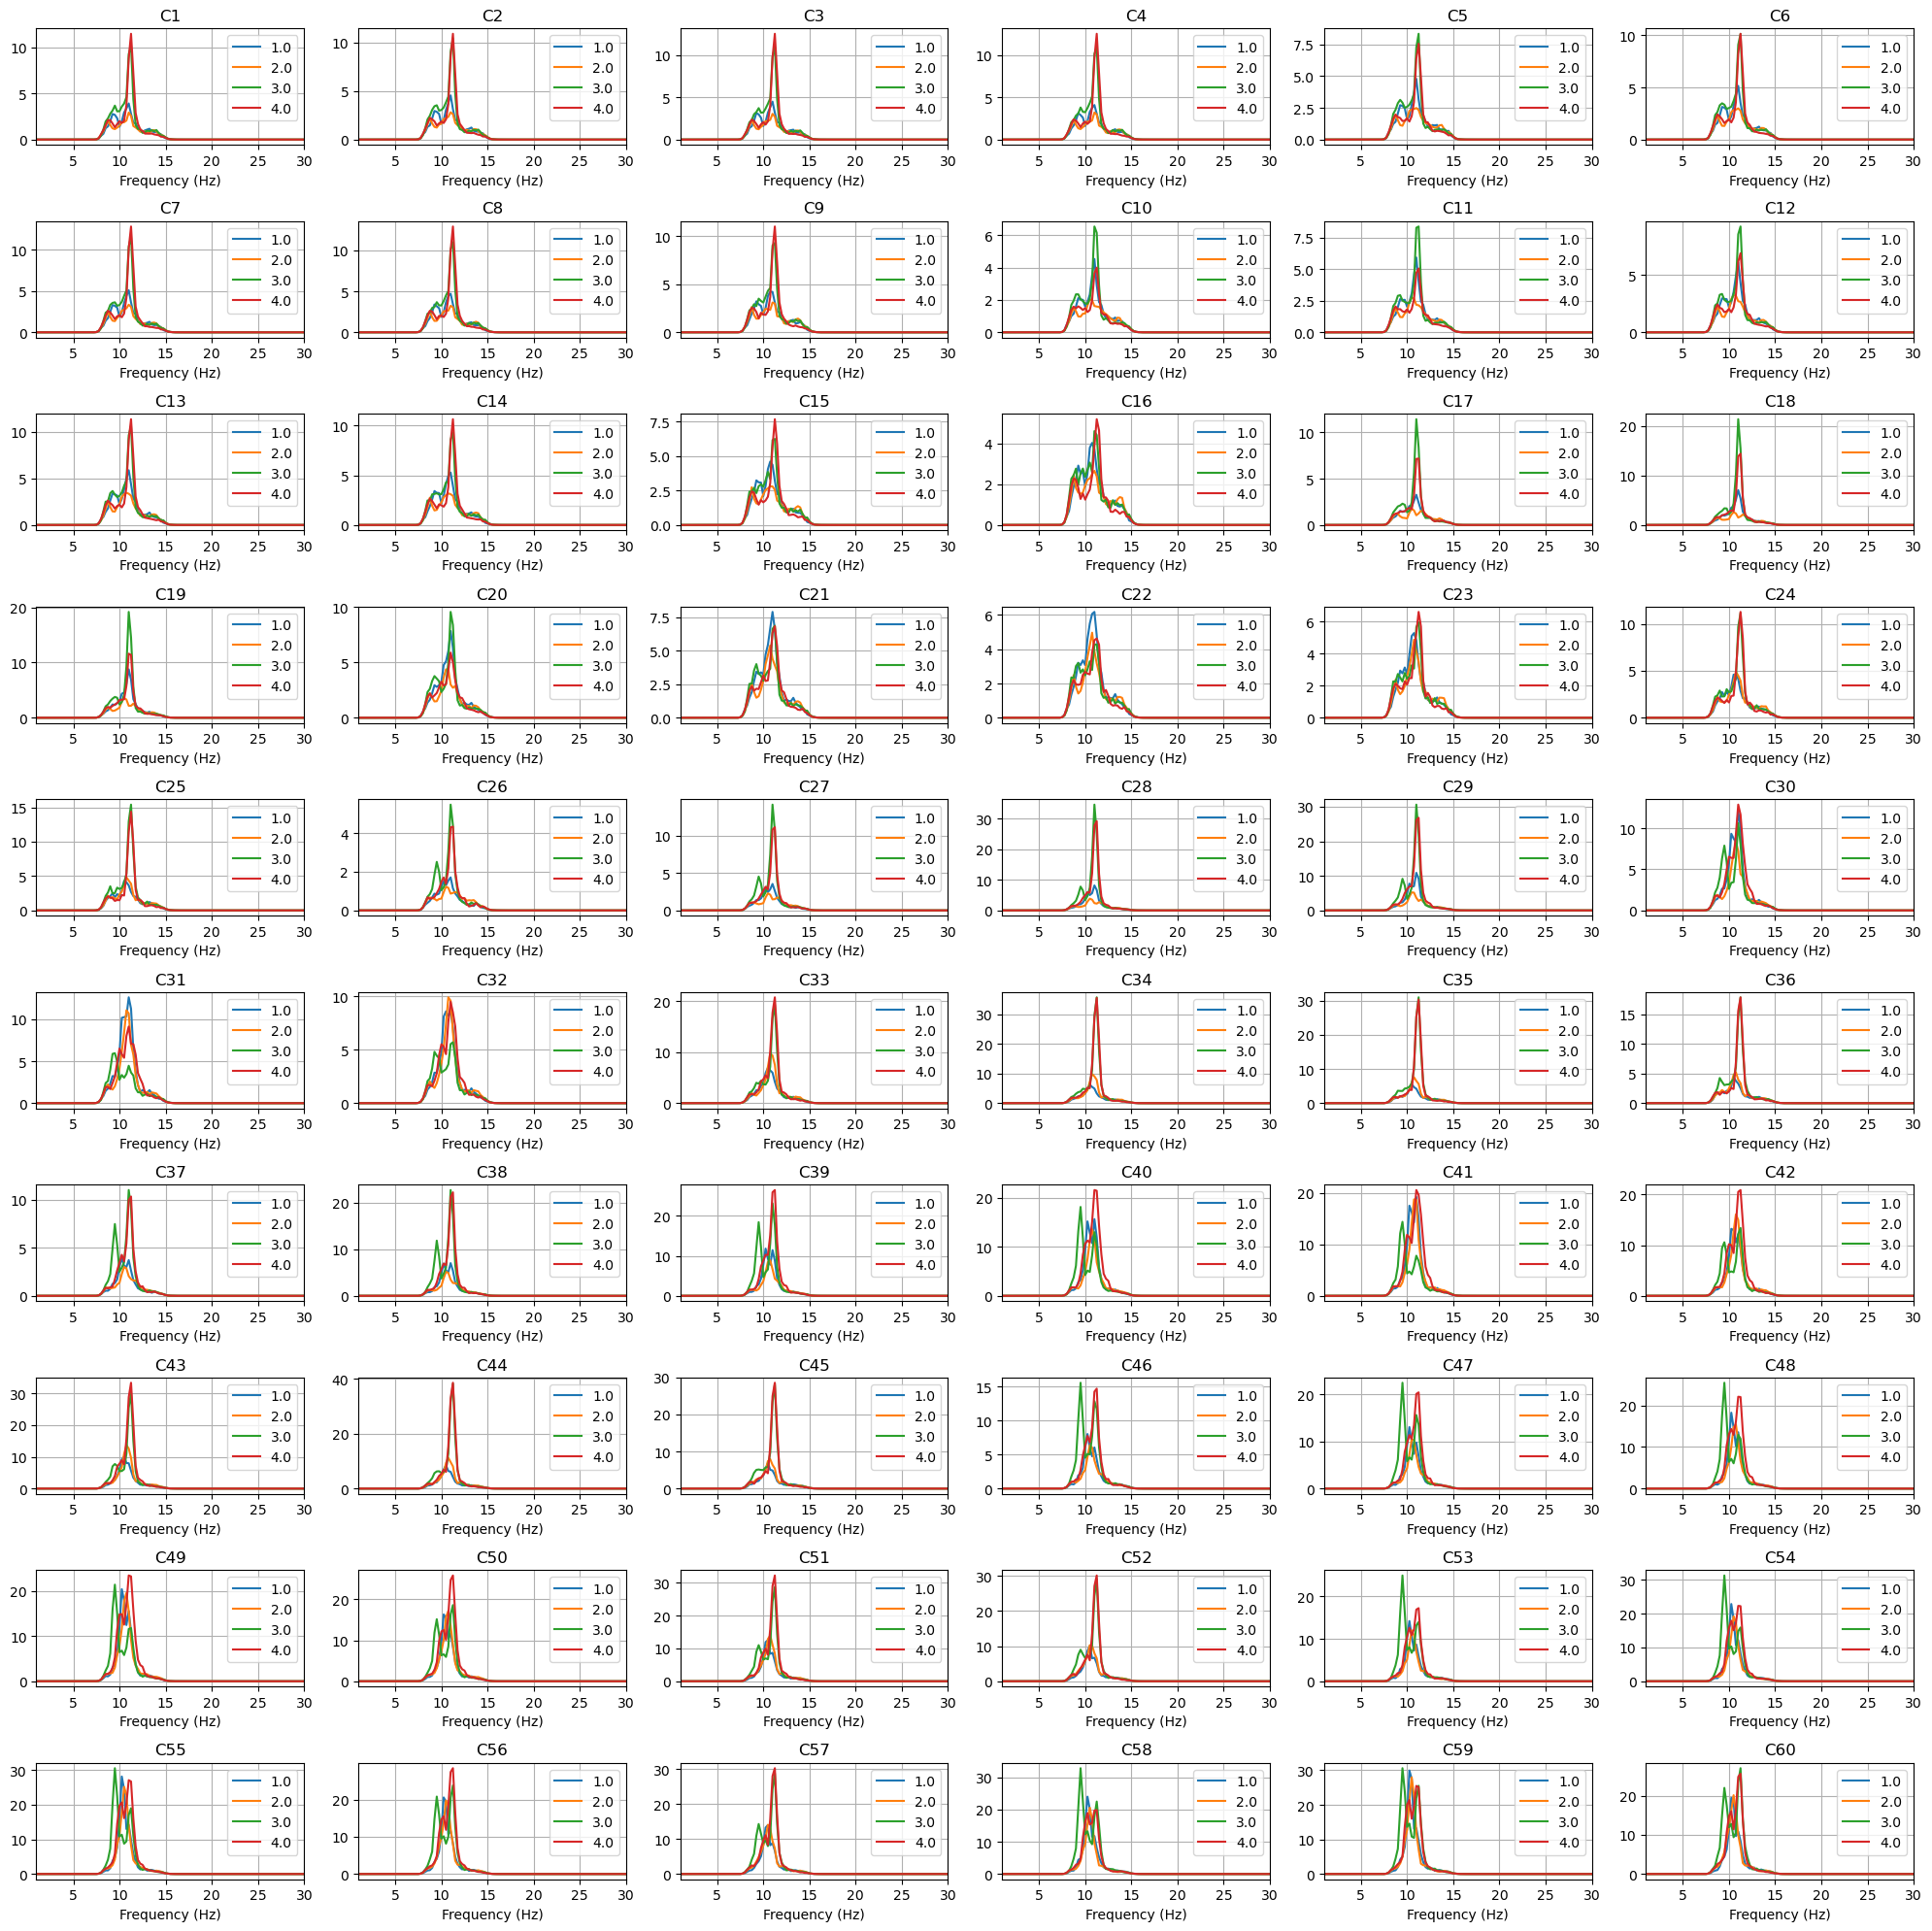

In [ ]:
plot_psd(
    trials_PSD,
    freqs,
    [ch_names.index(ch) for ch in ch_names],
    chan_lab=ch_names
)

## Referencing

In [ ]:
# Creating a Common Average Referencing function

def avg_ref(trials):
    '''
    Designs and applies the Common Average Referencing to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal

    Returns
    -------
    trials_car : 3d-array (channels x samples x trials)
        The refrenece adjusted signal
    '''

    # calculate the average across all channels
    trials_avg = np.mean(trials, axis=0)

    # Subtract the average from each channel
    trials_car = trials - trials_avg

    return trials_car

In [ ]:
# Apply the function on training data
trials_car = {1.0: avg_ref(trials_filt[1.0]),
              2.0: avg_ref(trials_filt[2.0]),
              3.0: avg_ref(trials_filt[3.0]),
              4.0: avg_ref(trials_filt[4.0])}

In [ ]:
print('Shape of CAR trials[1.0]:', trials_car[1.0].shape)
print('Shape of CAR trials[2.0]:', trials_car[2.0].shape)
print('Shape of CAR trials[3.0]:', trials_car[3.0].shape)
print('Shape of CAR trials[4.0]:', trials_car[4.0].shape)

Shape of CAR trials[1.0]: (60, 1000, 36)
Shape of CAR trials[2.0]: (60, 1000, 37)
Shape of CAR trials[3.0]: (60, 1000, 38)
Shape of CAR trials[4.0]: (60, 1000, 38)


In [ ]:
# Apply the function on testing data
test_trials_car = {'Test': avg_ref(test_trials['Test'])}

In [ ]:
print('Shape of CAR test trials:', test_trials_car['Test'].shape)

Shape of CAR test trials: (60, 1000, 149)


# Feature extraction

**Time domain**
Hjorth : Shrinkage regularized LDA


**Spatial domain**
CSP
FBCSP


**Frequency domain**
PSD


**Time-Frequency domain**
STFT
Wavelet


**Statistical domain**
log-var
Entropy
SVD
Bi-spectrum

## Log-Var

I am following a classic BCI design by Blankertz et al(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7604514/), where they use the logarithm of the variance of the signal in a certain frequency band as a feature for the classifier.

In [ ]:
# Calculate the log(var) of the trials

def logvar(trials):
    '''
    Calculate the log-var of each channel.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.

    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

In [ ]:
# Apply the function on test_data

test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}

#test_trials_logvar = {'Test': logvar(test_trials_car['Test'])}

In [ ]:
# Apply the function on training data
trials_logvar = {1.0: logvar(trials_filt[1.0]),
                 2.0: logvar(trials_filt[2.0]),
                 3.0: logvar(trials_filt[3.0]),
                 4.0: logvar(trials_filt[4.0])}

# trials_logvar = {1.0: logvar(trials_car[1.0]),
#                  2.0: logvar(trials_car[2.0]),
#                  3.0: logvar(trials_car[3.0]),
#                  4.0: logvar(trials_car[4.0])}

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)
print('Shape of log_var trials[3.0]:', trials_logvar[3.0].shape)
print('Shape of log_var trials[4.0]:', trials_logvar[4.0].shape)

Shape of log_var trials[1.0]: (60, 36)
Shape of log_var trials[2.0]: (60, 37)
Shape of log_var trials[3.0]: (60, 38)
Shape of log_var trials[4.0]: (60, 38)


In [ ]:
# Creating a function to visualize the logvar of each channel as a bar chart

def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 4 classes.
    '''
    plt.figure(figsize=(12,5))

    x1 = np.arange(nchannels) + 1
    x2 = np.arange(nchannels) + 1.15
    x3 = np.arange(nchannels) + 1.30
    x4 = np.arange(nchannels) + 1.45

    y1 = np.mean(trials[1.0], axis=1)
    y2 = np.mean(trials[2.0], axis=1)
    y3 = np.mean(trials[3.0], axis=1)
    y4 = np.mean(trials[4.0], axis=1)

    plt.bar(x1, y1, width=0.1, color='b')
    plt.bar(x2, y2, width=0.1, color='r')
    plt.bar(x3, y3, width=0.1, color='y')
    plt.bar(x4, y4, width=0.1, color='k')

    plt.xlim(0, nchannels+1)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend([1.0, 2.0, 3.0, 4.0])

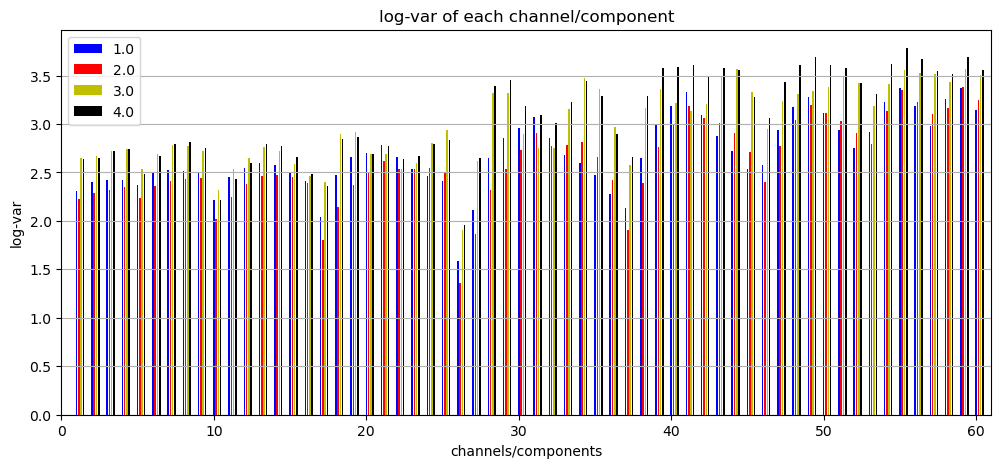

In [ ]:
# Plot the log-vars

plot_logvar(trials_logvar)

In cases where we have multiple channels, most channels show a small difference in the log-var of the signal between the different classes.

In such scenario we can apply the CSP algorithm to calculate mixture of channels that are designed to maximize the difference in variation between the different classes. These mixures are called spatial filters.

## Common Spatial Pattern (CSP)

In [ ]:
# Function to create CSP features on the given trial data

def csp_feat(trial_dict, n_components=2, reg=None, log=True, norm_trace=False):
    '''
    Create CSP features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)


    n_component : Top 'n' CSP filters that capture the most discriminative information.

    reg : is a regularization parameter that controls regularization in CSP.
          Regularization helps prevent overfitting by penalizing large values in the covariance matrices used by CSP.
          By default, reg is set to None, which means no regularization is applied.
          Set it to a positive float value to specify the regularization strength.
          A higher value increases the regularization strength.

    log : is a boolean parameter that controls whether to apply logarithm transformation to the eigenvalues of the covariance matrices.
          Logarithm transformation helps stabilize the eigenvalues, especially when dealing with very small or very large values.

    norm_trace : parameter controls whether to normalize the trace of the transformed covariance matrices to one.
                 The trace of a matrix is the sum of its diagonal elements.
                 Normalizing the trace to one means scaling the covariance matrices so that the sum of their diagonal elements equals one.
                 Normalizing the trace can help ensure that the CSP filters are more robust and stable, especially when dealing with different datasets and conditions.


    Returns
    -------
    X_csp : The CSP transformed trial data i.e. 2d-array (trials x n_components)

    csp_fltr : CSP object, which is used to transfrom the trials data

    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]

    # Getting the the label data for the first class
    n = trial_dict[class_lst[0]].shape[2]
    label = class_lst[0]
    Y = np.full(n, label)
    Y = Y.astype('int')

    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)

            n = trial_dict[c].shape[2]
            y_c = np.full(n, c)
            y_c = y_c.astype('int')
            Y = np.concatenate([Y, y_c])


    # Reshape X to (n_trials, n_channels, n_samples)
    X_reshaped = np.moveaxis(X, -1, 0)

    # Initialize CSP
    csp_fltr = CSP(n_components=n_components, reg=reg, log=log, norm_trace=norm_trace)

    # Fit CSP on training data
    csp_fltr.fit(X_reshaped, Y)

    # Transform training data using learned CSP filters
    X_csp = csp_fltr.transform(X_reshaped)



    return X_csp, csp_fltr, Y

**Training Data**

In [ ]:
X_train_csp, csp_fltr, Y_train = csp_feat(trials_filt, n_components=8)

Computing rank from data with rank=None
    Using tolerance 72 (2.2e-16 eps * 60 dim * 5.4e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 69 (2.2e-16 eps * 60 dim * 5.2e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 77 (2.2e-16 eps * 60 dim * 5.8e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 83 (2.2e-16 eps * 60 dim * 6.2e+15  max singular value)
    Estimated rank (

In [ ]:
X_train_csp.shape

(149, 8)

In [ ]:
csp_fltr.filters_.shape

(60, 60)

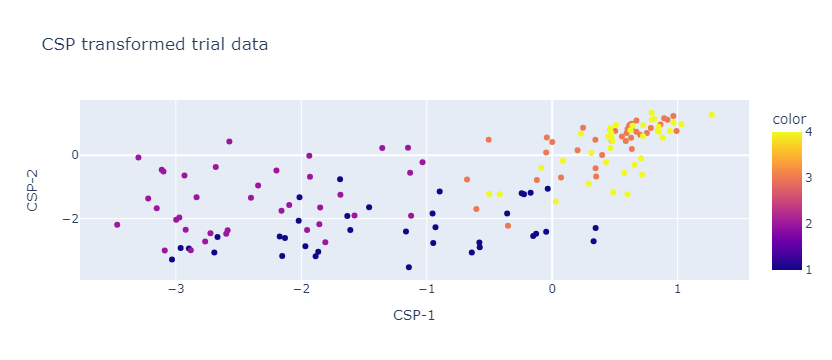

In [ ]:
# Create a scatter plot
fig = px.scatter(x=X_train_csp[:,0], y=X_train_csp[:,1],
                 color=Y_train,
                 title='CSP transformed trial data', labels={'x': 'CSP-1', 'y': 'CSP-2'})

# Show the plot
fig.show()


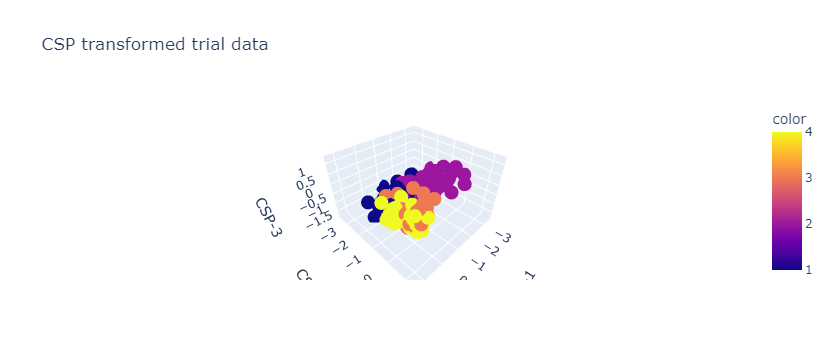

In [ ]:
# Create a 3D-scatter plot
fig = px.scatter_3d(x=X_train_csp[:,0], y=X_train_csp[:,1], z=X_train_csp[:,2],
                 color=Y_train,
                 title='CSP transformed trial data', labels={'x': 'CSP-1', 'y': 'CSP-2', 'z': 'CSP-3'})

# Show the plot
fig.show()

**Testing Data**

In [ ]:
# Creating a copy of test data

X_test = test_trials_filt['Test'].copy()
X_test.shape

(60, 1000, 149)

In [ ]:
# Reshape X_test to (n_trials, n_channels, n_samples)

X_test = np.moveaxis(X_test, -1, 0)
X_test.shape

(149, 60, 1000)

In [ ]:
# Transform testing data using learned CSP filters

X_test_csp = csp_fltr.transform(X_test)
X_test_csp.shape

(149, 8)

## Filter Bank Common Spatial Pattern

Filter Bank CSP involves filtering the EEG signal into different frequency bands, applying CSP separately to each band, and then combining the features from all bands.

https://www.ncbi.nlm.nih.gov/books/NBK539805/#:~:text=The%20most%20commonly%20studied%20waveforms,beta%20(13%20to%2030Hz)

In [ ]:
# The EEG signal is decomposed into five frequency bands, each with different characteristics
Delta = (1, 4)
Theta = (4, 7)
Alpha = (8, 12)
Sigma = (12, 16)
Beta = (13, 30)
Gamma = (30, 100)

freq_bands = [Delta, Theta, Alpha, Sigma, Beta]
#freq_bands = [Alpha, Sigma]
freq_bands

[(1, 4), (4, 7), (8, 12), (12, 16), (13, 30)]

In [ ]:
# def fbcsp_feat(trial_dict, freq_bands=freq_bands, n_components=4, sfreq=250, reg=None, log=True, norm_trace=False):
#     '''
#     Create Filter Bank Common Spatial Pattern (FBCSP) features on the given trial data.

#     Parameters
#     ----------
#     trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
#                     in 3d-array (channels x samples x trials)

#     freq_bands : List of tuples, where each tuple contains the frequency band limits (e.g., [(4, 8), (8, 12), (12, 30)])

#     n_components : Top 'n' CSP filters that capture the most discriminative information.

#     sfreq : Sampling frequency

#     reg : Regularization parameter that controls regularization in CSP.

#     log : Boolean parameter that controls whether to apply logarithm transformation to the eigenvalues of the covariance matrices.

#     norm_trace : Boolean parameter that controls whether to normalize the trace of the transformed covariance matrices to one.

#     Returns
#     -------
#     X_fbcsp : The FBCSP transformed trial data i.e. 2d-array (trials x n_components * number of frequency bands)

#     fbcsp_filters : Dictionary of CSP objects, one for each frequency band

#     Y : Array of labels for the trials

#     '''


#     # Getting the class labesl as list
#     class_lst = list(trial_dict.keys())

#     # Getting the the trial data for the first class
#     X = trial_dict[class_lst[0]]

#     # Getting the the label data for the first class
#     n = trial_dict[class_lst[0]].shape[2]
#     label = class_lst[0]
#     Y = np.full(n, label)
#     Y = Y.astype('int')

#     # Consolidating the different class data into one array
#     if len(class_lst)>1:
#         for c in class_lst[1:]:
#             X = np.concatenate([X, trial_dict[c]], axis=2)

#             n = trial_dict[c].shape[2]
#             y_c = np.full(n, c)
#             y_c = y_c.astype('int')
#             Y = np.concatenate([Y, y_c])


#     # Initialize a dictionary to store CSP filters for each frequency band
#     fbcsp_filters = {}

#     # Initialize list to store transformed features for each frequency band
#     X_fbcsp = []

#     # Iterate over each frequency band
#     for band in freq_bands:
#         # Filtering the data for the current frequency band
#         l_freq=band[0]
#         h_freq=band[1]
#         X_fltr = bandpass(X, l_freq, h_freq, sfreq)

#         # Reshape X_fltr to (n_trials, n_channels, n_samples)
#         X_reshaped = np.moveaxis(X_fltr, -1, 0)

#         # Initialize CSP
#         csp_fltr = CSP(n_components=n_components, reg=reg, log=log, norm_trace=norm_trace)

#         # Fit CSP on training data
#         csp_fltr.fit(X_reshaped, Y)

#         # Transform training data using learned CSP filters
#         X_csp = csp_fltr.transform(X_reshaped)

#         # Append transformed features to the list
#         X_fbcsp.append(X_csp)

#         # Store the CSP filter for the current frequency band
#         fbcsp_filters[band] = csp_fltr


#     # Stack transformed features across frequency bands
#     X_fbcsp = np.concatenate(X_fbcsp, axis=1)

#     return X_fbcsp, fbcsp_filters, Y

In [ ]:
def fbcsp_feat(trial_dict, freq_bands=freq_bands, n_components=4, sfreq=250, reg=None, log=True, norm_trace=False):
    '''
    Create Filter Bank Common Spatial Pattern (FBCSP) features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)

    freq_bands : List of tuples, where each tuple contains the frequency band limits (e.g., [(4, 8), (8, 12), (12, 30)])

    n_components : Top 'n' CSP filters that capture the most discriminative information.

    sfreq : Sampling frequency

    reg : Regularization parameter that controls regularization in CSP.

    log : Boolean parameter that controls whether to apply logarithm transformation to the eigenvalues of the covariance matrices.

    norm_trace : Boolean parameter that controls whether to normalize the trace of the transformed covariance matrices to one.

    Returns
    -------
    X_fbcsp : The FBCSP transformed trial data i.e. 3d-array (trials x n_components x n_freqbands)

    fbcsp_filters : Dictionary of CSP objects, one for each frequency band

    Y : Array of labels for the trials

    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]

    # Getting the the label data for the first class
    n = trial_dict[class_lst[0]].shape[2]
    label = class_lst[0]
    Y = np.full(n, label)
    Y = Y.astype('int')

    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)

            n = trial_dict[c].shape[2]
            y_c = np.full(n, c)
            y_c = y_c.astype('int')
            Y = np.concatenate([Y, y_c])


    # Initialize a dictionary to store CSP filters for each frequency band
    fbcsp_filters = {}

    # Initialize an array to store transformed features for each frequency band
    n_trials = len(Y)
    n_bands = len(freq_bands)
    X_fbcsp = np.zeros((n_trials, n_components, n_bands))


    # Iterate over each frequency band
    for idx, band in enumerate(freq_bands):
        # Filtering the data for the current frequency band
        l_freq=band[0]
        h_freq=band[1]
        X_fltr = bandpass(X, l_freq, h_freq, sfreq)

        # Reshape X_fltr to (n_trials, n_channels, n_samples)
        X_reshaped = np.moveaxis(X_fltr, -1, 0)

        # Initialize CSP
        csp_fltr = CSP(n_components=n_components, reg=reg, log=log, norm_trace=norm_trace)

        # Fit CSP on training data
        csp_fltr.fit(X_reshaped, Y)

        # Transform training data using learned CSP filters
        X_csp = csp_fltr.transform(X_reshaped)

        # Append transformed features to the list
        X_fbcsp[:, :, idx] = X_csp

        # Store the CSP filter for the current frequency band
        fbcsp_filters[band] = csp_fltr


    return X_fbcsp, fbcsp_filters, Y

**Training Data**

In [ ]:
X_train_fbcsp, fbcsp_fltr, Y_train = fbcsp_feat(trials_filt, n_components=6)

Computing rank from data with rank=None
    Using tolerance 6.3e+21 (2.2e-16 eps * 60 dim * 4.7e+35  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.5e+21 (2.2e-16 eps * 60 dim * 4.1e+35  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e+21 (2.2e-16 eps * 60 dim * 3.9e+35  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4e+21 (2.2e-16 eps * 60 dim * 3e+35  max singular value)
    

In [ ]:
X_train_fbcsp.shape

(149, 6, 5)

In [ ]:
# Frequency bands

fbcsp_fltr.keys()

dict_keys([(1, 4), (4, 7), (8, 12), (12, 16), (13, 30)])

In [ ]:
# Shape of CSP filter for one sample frequency band

fbcsp_fltr[(8, 12)].filters_.shape

(60, 60)

**Testing Data**

In [ ]:
# Creating a copy of test data

X_test = test_trials_filt['Test'].copy()
X_test.shape

(60, 1000, 149)

In [ ]:
# Reshape X_test to (n_trials, n_channels, n_samples)

X_test = np.moveaxis(X_test, -1, 0)
X_test.shape

(149, 60, 1000)

In [ ]:
# Transform testing data using learned FBCSP filters

# Initialize an array to store transformed features for each frequency band
n_trials = X_test.shape[0]
n_bands = len(freq_bands)
n_components = 6
X_test_fbcsp = np.zeros((n_trials, n_components, n_bands))

# Iterate over each frequency band
for idx, band in enumerate(fbcsp_fltr.keys()):
    # Getting the CSP filter for the current frequency band
    csp_fltr = fbcsp_fltr[band]

    # Transform testing data using learned CSP filters
    X_csp = csp_fltr.transform(X_test)

    # Append transformed features to the list
    X_test_fbcsp[:,:,idx] = X_csp


X_test_fbcsp.shape

(149, 6, 5)

In [ ]:
# # Transform testing data using learned FBCSP filters

# # Initialize list to store transformed features for each frequency band
# X_test_fbcsp = []

# # Iterate over each frequency band
# for band in fbcsp_fltr.keys():
#     # Getting the CSP filter for the current frequency band
#     csp_fltr = fbcsp_fltr[band]

#     # Transform testing data using learned CSP filters
#     X_csp = csp_fltr.transform(X_test)

#     # Append transformed features to the list
#     X_test_fbcsp.append(X_csp)


# # Stack transformed features across frequency bands
# X_test_fbcsp = np.concatenate(X_test_fbcsp, axis=1)

# X_test_fbcsp.shape

## Wavelet Transform

https://www.youtube.com/watch?v=MX7ymkYGiZ0

In [ ]:
!pip install PyWavelets

In [ ]:
import pywt

When you perform the wavelet transform using PyWavelets (pywt.cwt()), you specify the scales at which the wavelet transform is computed. The number of scales you choose directly affects the number of coefficients produced by the wavelet transform.

In your case, you specified the scales as np.arange(1, 128), which generates an array of scales ranging from 1 to 127. These scales determine the resolution or frequency bands at which the wavelet transform operates.

The number of scales you choose affects the number of coefficients generated. If you choose more scales, you'll get more coefficients, and if you choose fewer scales, you'll get fewer coefficients. Each coefficient represents the energy or amplitude of the signal in a specific frequency band at a particular time point.

Ensure that the scales chosen for the wavelet transform adequately cover the frequency range of interest based on the Nyquist theorem.

sampling freq = 250

nyquist_freq = 250/2 = 125

scales = 128, nearest value greater then nyquist_freq, generally in 2^n

In [ ]:
# Function to create wavelet features on the given trial data

def wave_feat(trial_dict, scales=np.arange(1, 128), wavelet='morl', plot=True):
    '''
    Create Wavelet features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)


    scales : Array of scales that determine the resolution or frequency bands at which
                the wavelet transform operates.

    wavelet : wavelet shape to use 'morl' (Morlet wavelet).
                'db1' (Haar wavelet) but it gives complex coefficents

    plot : is a boolean parameter that controls whether we want to display
            the wavelet transform coefficients for first trial and first channel


    Returns
    -------
    coefficients_all_trials : The Wavelet transformed trial data i.e. 4d-array (trials x channels x scales x samples)


    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]

    # Getting the the label data for the first class
    n = trial_dict[class_lst[0]].shape[2]
    label = class_lst[0]
    Y = np.full(n, label)
    #Y = Y.astype('int')

    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)

            n = trial_dict[c].shape[2]
            y_c = np.full(n, c)
            y_c = y_c.astype('int')
            Y = np.concatenate([Y, y_c])


    # Reshape X to (n_trials, n_channels, n_samples)
    X_reshaped = np.moveaxis(X, -1, 0)

    n_trials = X_reshaped.shape[0]
    n_channels = X_reshaped.shape[1]


    # Perform wavelet transform for each trial
    coefficients_all_trials = []

    for trial in range(n_trials):
        coefficients_trial = []
        for channel in range(n_channels):
            signal = X_reshaped[trial, channel, :]
            coefficients, wave_freq = pywt.cwt(signal, scales=scales, wavelet=wavelet)
            coefficients_trial.append(coefficients)
        coefficients_all_trials.append(coefficients_trial)


    # Plot the wavelet transform coefficients for first trial and first channel
    if plot:
        plt.imshow(coefficients_all_trials[0][0], extent=[0, 1, 1, 128], cmap='PRGn', aspect='auto',
                   vmax=abs(coefficients_all_trials[0][0]).max(), vmin=-abs(coefficients_all_trials[0][0]).max())
        plt.title('Wavelet Transform Coefficients (Trial 1, Channel 1)')
        plt.xlabel('Time')
        plt.ylabel('Scale')
        plt.colorbar(label='Coefficient')
        plt.show()


    return np.array(coefficients_all_trials)

**Training Data**

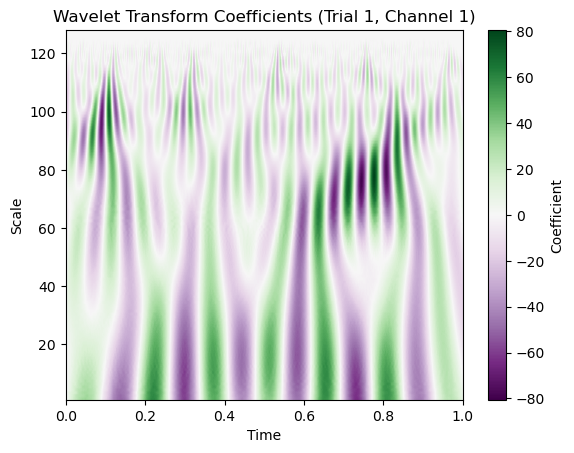

In [ ]:
# With raw  training data : will take ~4mins

wave_coeff = wave_feat(trials)

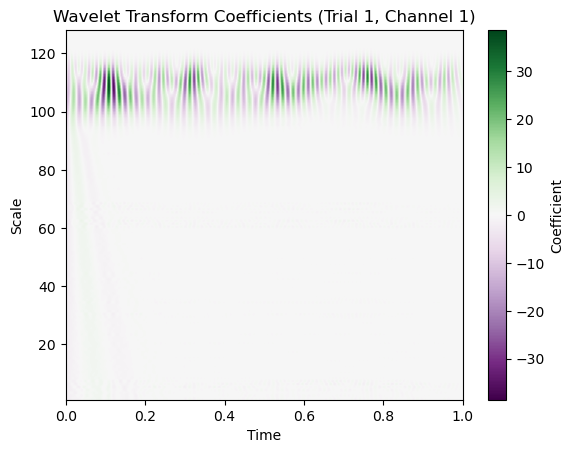

In [ ]:
# With filtered training data : will take ~4mins

train_wave_coeff = wave_feat(trials_filt)

In [ ]:
train_wave_coeff.shape

(149, 60, 127, 1000)

**Testing Data**

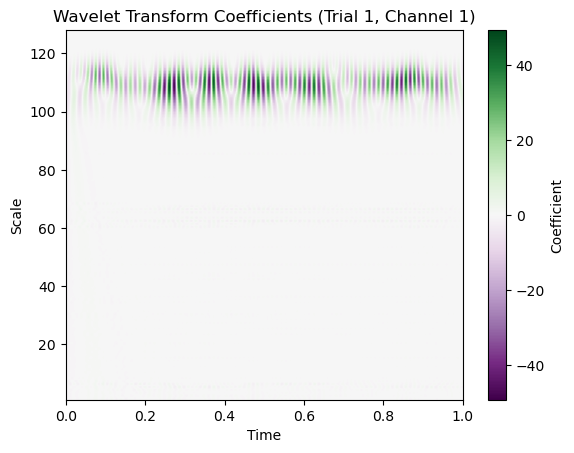

In [ ]:
# With filtered testing data : will take ~4mins

test_wave_coeff = wave_feat(test_trials_filt)

In [ ]:
test_wave_coeff.shape

(149, 60, 127, 1000)

## Short Time Fourier Transform

(Phase only and Magnitude+Phase combined)

In [ ]:
# Function to create STFT features on the given trial data

def stft_feat(trial_dict, fs=sample_rate, nperseg=nsamples, noverlap=32):
    '''
    Create STFT features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)

    fs : sample_rate # Sampling frequency

    nperseg : nsamples  # Length of each segment

    noverlap : 32  # Overlap between segments


    Returns
    -------
    stft_results : The STFT transformed trial data i.e. 4d-array (trials * frequency_bins * time_bins * channels)


    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]


    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)


    # Reshape X to (n_trials, n_samples, n_channels)
    X_reshaped = np.moveaxis(X, -1, 0)
    X_reshaped = np.moveaxis(X_reshaped, -1, 1)

    # Perform STFT for each channel
    stft_results = []
    for channel in range(X_reshaped.shape[2]):  # Iterate over channels
        channel_data = X_reshaped[:, :, channel]  # Extract data for each channel
        _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
        stft_results.append(stft_data)

    # Convert the results to a NumPy array. The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)
    stft_results = np.array(stft_results)


    # Reshaping the stft_results. Now its in shape: trials * frequency_bins * time_bins * channels
    stft_results = np.moveaxis(stft_results, 0,-1)

    # Seperating the real and imaginary part
    #stft_real = stft_results.real
    #stft_imag = stft_results.imag


    return stft_results

In [ ]:
# Applying on training data

train_stft = stft_feat(trials_filt)
train_stft.shape

(149, 501, 3, 60)

In [ ]:
# Applying on testing data

test_stft = stft_feat(test_trials_filt)
test_stft.shape

(149, 501, 3, 60)

## Power Spectral Density (From: Band-Power)

In [ ]:
# Function to create PSD features on the given trial data

def psd_feat(trial_dict, Fs=sample_rate):
    '''
    Create PSD features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)

    Fs : sample_rate # Sampling frequency


    Returns
    -------
    psd_power : The PSD transformed trial data i.e. 3d-array (trials x channels x frequency_bins)

    psd_freq : list of frequencies used in the PSD analysis

    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]


    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)



    # Calling the PSD function
    psd_power, psd_freqs = psd(X)

    # Reshape psd_power to (n_trials, n_channels, freq_bins)
    psd_power = np.moveaxis(psd_power, -1, 0)



    return psd_power, psd_freqs

In [ ]:
# Applying on training data

train_psd, psd_freqs = psd_feat(trials_filt)
train_psd.shape

(149, 60, 501)

In [ ]:
# Applying on testing data

test_psd, test_psd_freqs = psd_feat(trials_filt)
test_psd.shape

(149, 60, 501)

In [ ]:
# Find the maximum PSD frequency for a given channel and trial

trial_index=10
for c in range(60):
    psd_values = train_psd[trial_index][c]

    # Find the index of the maximum PSD value
    max_psd_index = np.argmax(psd_values)

    # Retrieve the corresponding frequency value
    max_psd_frequency = psd_freqs[max_psd_index]

    print("\nChannel", c+1, "\n\tMax PSD Power", psd_values.max(), "at Frequency:", max_psd_frequency)


Channel 1 
	Max PSD Power 7.75291153375204 at Frequency: 11.0

Channel 2 
	Max PSD Power 8.974039105942188 at Frequency: 11.0

Channel 3 
	Max PSD Power 7.721653432798847 at Frequency: 11.0

Channel 4 
	Max PSD Power 7.3353993966184445 at Frequency: 11.25

Channel 5 
	Max PSD Power 7.873568925397962 at Frequency: 11.0

Channel 6 
	Max PSD Power 8.066626603774587 at Frequency: 11.0

Channel 7 
	Max PSD Power 7.655760100629223 at Frequency: 11.0

Channel 8 
	Max PSD Power 6.778468896130908 at Frequency: 11.25

Channel 9 
	Max PSD Power 6.152135926431915 at Frequency: 11.25

Channel 10 
	Max PSD Power 5.826541547063247 at Frequency: 11.0

Channel 11 
	Max PSD Power 7.468066290649346 at Frequency: 11.0

Channel 12 
	Max PSD Power 7.4600166679995015 at Frequency: 11.0

Channel 13 
	Max PSD Power 6.852369317741574 at Frequency: 11.0

Channel 14 
	Max PSD Power 4.999014880533932 at Frequency: 11.0

Channel 15 
	Max PSD Power 3.181681645361682 at Frequency: 11.0

Channel 16 
	Max PSD Power 2.

In [ ]:
psd_freqs.shape

(501,)

In [ ]:
psd_values.shape

(501,)

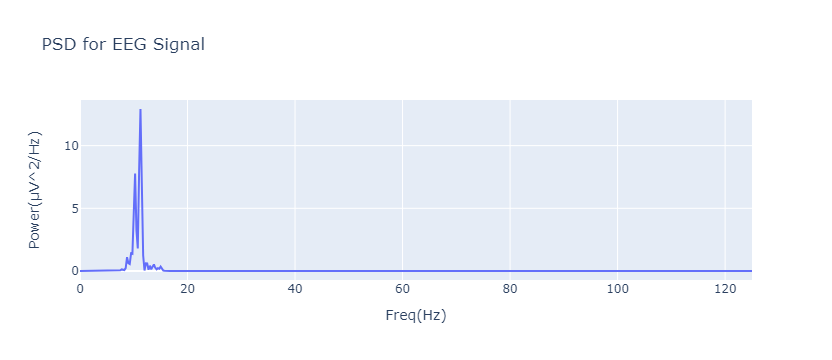

In [ ]:
# Create a scatter plot
fig = px.line(x=psd_freqs, y=psd_values,
                 title='PSD for EEG Signal', labels={'x': 'Freq(Hz)', 'y': 'Power(µV^2/Hz)'})

# Show the plot
fig.show()


In [ ]:
trials_filt[1.0][-1,:,10].shape

(1000,)

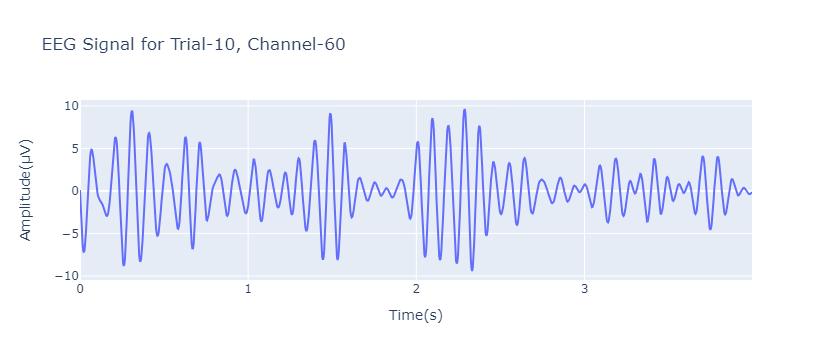

In [ ]:
# Create a scatter plot
fig = px.line(x=range(1000), y=trials_filt[1.0][-1,:,10],
                 title='EEG Signal for Trial-10, Channel-60', labels={'x': 'Time(s)', 'y': 'Amplitude(µV)'})


# Update x-axis ticks and labels
fig.update_layout(xaxis=dict(tickmode='array', tickvals=[0, 250, 500, 750, 1000], ticktext=['0', '1', '2', '3', '4']))

# Show the plot
fig.show()

## Bi-Spectrum

Performing bispectral analysis on our 3D data involves computing the bispectrum for each trial and channel combination.

The bispectrum is a measure of higher-order statistics that provides information about phase coupling and nonlinear interactions between frequency components in a signal.

https://pypi.org/project/pybispectra/

In [ ]:
#!pip install pybispectra -q

## Entropy

In [ ]:
# Function to create Entropy features on the given trial data

def ent_feat(trial_dict):
    '''
    Create Entropy features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)




    Returns
    -------
    entropy_results : The Entropy transformed trial data i.e. 2d-array (trials x channels)


    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]


    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)


    # Reshape X to (n_trials, n_channels, n_samples)
    X_reshaped = np.moveaxis(X, -1, 0)


    # Calculate entropy for each trial and channel
    entropy_results = []  # Store entropy results

    for trial in range(X_reshaped.shape[0]):
        trial_entropy = []  # Store entropy for each trial
        for channel in range(X_reshaped.shape[1]):
            # Flatten the data for the current trial and channel
            flattened_data = X_reshaped[trial, channel, :]

            # Compute the probability distribution
            unique_elements, counts = np.unique(flattened_data, return_counts=True)
            probabilities = counts / len(flattened_data)

            # Calculate entropy
            entropy = -np.sum(probabilities * np.log2(probabilities))

            # Store entropy for this channel
            trial_entropy.append(entropy)

        # Store entropy for this trial
        entropy_results.append(trial_entropy)


    return np.array(entropy_results)

In [ ]:
entropy_results = ent_feat(trials_filt)
entropy_results.shape

(149, 60)

In [ ]:
entropy_results[0]

array([9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428,
       9.96578428, 9.96578428, 9.96578428, 9.96578428, 9.96578428])

We are getting same entropy value cross the trials, as the probabailiuty distribution is built on freq of unique value and in our case we have all unique values, thus the same probability and the same entropy. This feature will not useful for the model

## Hjorth Parameters

Hjorth parameters are statistical measures used to characterize signals, particularly in the context of biomedical signal processing, including EEG (Electroencephalogram) signals. Developed by Bent Hjorth in the 1970s, these parameters offer insights into the underlying dynamics and properties of time-series data. They are used to quantify the activity, mobility, and complexity of signals.

Here's a brief explanation of each Hjorth parameter:

1. **Activity (Activity Parameter)**:
   - Activity represents the overall energy or power of the signal.
   - It is calculated as the variance of the signal.

2. **Mobility (Mobility Parameter)**:
   - Mobility characterizes the frequency content of the signal or how quickly the signal changes.
   - It is calculated as the ratio of the standard deviation of the first derivative of the signal to the standard deviation of the signal itself.

3. **Complexity (Complexity Parameter)**:
   - Complexity provides information about the waveform complexity or irregularity of the signal.
   - It is calculated as the ratio of the mobility of the first derivative to the mobility of the signal.

Hjorth parameters are commonly used in the analysis of EEG signals to quantify different aspects of brain activity. For example, the activity parameter can indicate the overall level of neural activity, while the mobility parameter can reflect the rate of change in neural activity, and the complexity parameter can provide insights into the complexity or irregularity of brain dynamics.

In summary, Hjorth parameters offer a simple yet effective way to characterize the dynamics and properties of signals, making them valuable tools in signal processing and analysis, particularly in the study of biological and physiological signals like EEG. They help researchers and clinicians better understand and interpret the underlying mechanisms and patterns in complex signal data.

In [ ]:
# Define a function to calculate Hjorth parameters

def hjorth_parameters(signal):
    # Calculate activity (variance)
    activity = np.var(signal)

    # Calculate first derivative
    diff1 = np.diff(signal)

    # Calculate second derivative
    diff2 = np.diff(diff1)

    # Calculate mobility (ratio of standard deviation of first derivative to standard deviation of signal)
    mobility = np.sqrt(np.var(diff1) / activity) if activity != 0 else 0

    # Calculate complexity (ratio of mobility of first derivative to mobility of signal)
    complexity = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0


    return activity, mobility, complexity

In [ ]:
# Function to create Hjorth features on the given trial data

def hjo_feat(trial_dict):
    '''
    Create Hjorth features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)



    Returns
    -------
    hjorth_all_trials : Calculated Hjorth parameters on trial data i.e. 3d-array (trials x channels x hjorth_parameters)


    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]


    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)


    # Reshape X to (n_trials, n_channels, n_samples)
    X_reshaped = np.moveaxis(X, -1, 0)


    # Calculate Hjorth parameters for each trial and channel
    hjorth_all_trials = []
    for trial in range(X_reshaped.shape[0]):
        trial_hjorth = []
        for channel in range(X_reshaped.shape[1]):
            activity, mobility, complexity = hjorth_parameters(X_reshaped[trial, channel, :])
            trial_hjorth.append((activity, mobility, complexity))
        hjorth_all_trials.append(trial_hjorth)


    return np.array(hjorth_all_trials)

In [ ]:
# Applying on training data

train_hjorth = hjo_feat(trials_filt)
train_hjorth.shape

(149, 60, 3)

In [ ]:
# Applying on testing data

test_hjorth = hjo_feat(test_trials_filt)
test_hjorth.shape

(149, 60, 3)

## Singular Value Decomposition(SVD)

In [ ]:
# Function to create SVD features on the given trial data

def svd_feat(trial_dict, k=100):
    '''
    Create SVD features on the given trial data.

    Parameters
    ----------
    trial_dict : Dictionary of trial data, where class label is key and corresponding class data is the EEG signal
                    in 3d-array (channels x samples x trials)

    k : Number of components (singular vectors/values) we want to use as features


    Returns
    -------
    svd_features : SVD features on trial data i.e. 2d-array (trials x 2*k)


    '''


    # Getting the class labesl as list
    class_lst = list(trial_dict.keys())

    # Getting the the trial data for the first class
    X = trial_dict[class_lst[0]]


    # Consolidating the different class data into one array
    if len(class_lst)>1:
        for c in class_lst[1:]:
            X = np.concatenate([X, trial_dict[c]], axis=2)


    # Reshape X to (n_trials, n_channels, n_samples)
    #X_reshaped = np.moveaxis(X, -1, 0)

    # Reshape the data into a 2D array (trials, channels*samples). SVD operates on 2D matrices
    data_2d = X.reshape((X.shape[2], -1))

    # Perform Singular Value Decomposition (SVD)
    U, s, V = np.linalg.svd(data_2d, full_matrices=False)


    # Extract features from U, s, V matrices
    svd_features = np.concatenate((U[:, :k], V[:, :k]), axis=1)  # Concatenate U and V matrices


    return svd_features

In [ ]:
# Applying on training data

train_svd = svd_feat(trials_filt)
train_svd.shape

(149, 200)

In [ ]:
# Applying on testing data

test_svd = svd_feat(test_trials_filt)
test_svd.shape

(149, 200)

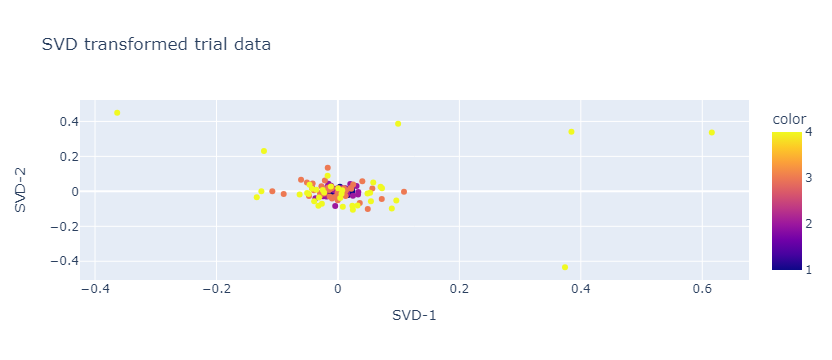

In [ ]:
# Create a scatter plot
fig = px.scatter(x=train_svd[:,0], y=train_svd[:,1],
                 color=Y_train,
                 title='SVD transformed trial data', labels={'x': 'SVD-1', 'y': 'SVD-2'})

# Show the plot
fig.show()


# Feature selection

https://towardsdatascience.com/feature-selection-in-python-using-filter-method-7ae5cbc4ee05

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection

## PCA

In [ ]:
# Function to create PC's on the given training data and transform the testing data

def pca_sel(X_train_arr, X_test_arr, n_components=10):
    '''
    Create Principal components on the given training data and transform the testing data

    Parameters
    ----------
    X_train_arr : N dimensional array of the X features where first dimension is number of trials for training data

    X_test_arr : N dimensional array of the X features where first dimension is number of trials for testing data

    n_components : Number of principal components selected


    Returns
    -------
    X_train_pca : The selected PC's for training data
    X_test_pca : The selected PC's for testing data

    '''

    # Reshaping the data into 2D
    train_trials = X_train_arr.shape[0]
    X_train_arr = X_train_arr.reshape(train_trials, -1)

    test_trials = X_test_arr.shape[0]
    X_test_arr = X_test_arr.reshape(test_trials, -1)


    # Checking for n_components
    n_samples, n_features = X_train_arr.shape
    sample_feature_min = min(n_samples, n_features)
    if n_components <= sample_feature_min:
        pass
    else:
        n_components = sample_feature_min


    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train_arr)
    X_test_pca = pca.transform(X_test_arr)


    # Calculate the total variance explained by the selected components
    total_variance_explained = np.sum(pca.explained_variance_ratio_)
    print("Total variance explained by", n_components, "components:", round(total_variance_explained*100),"%")


    return X_train_pca, X_test_pca

**Getting the PC's for Log-Var features**

In [ ]:
X_train_logvar = np.concatenate([trials_logvar[1.0].T, trials_logvar[2.0].T, trials_logvar[3.0].T, trials_logvar[4.0].T])
X_train_logvar.shape

(149, 60)

In [ ]:
X_test_logvar = test_trials_logvar['Test'].T
X_test_logvar.shape

(149, 60)

In [ ]:
X_train_logvar_pca, X_test_logvar_pca = pca_sel(X_train_logvar, X_test_logvar, n_components=10)

Total variance explained by 10 components: 99 %


**Getting the PC's for CSP features**

In [ ]:
X_train_csp_pca, X_test_csp_pca = pca_sel(X_train_csp, X_test_csp, n_components=10)

Total variance explained by 8 components: 100 %


**Getting the PC's for FBCSP features**

In [ ]:
X_train_fbcsp_pca, X_test_fbcsp_pca = pca_sel(X_train_fbcsp, X_test_fbcsp, n_components=10)

Total variance explained by 10 components: 89 %


**Getting the PC's for Wavelet features**

In [ ]:
train_wave_coeff.shape

(149, 60, 127, 1000)

In [ ]:
X_train_wave_pca, X_test_wave_pca = pca_sel(train_wave_coeff, test_wave_coeff, n_components=50)

Total variance explained by 50 components: 88 %


**Getting the PC's for STFT features**

In [ ]:
# Getting magnitude: Training data
X_train_mag = np.abs(train_stft)
X_train_mag.shape

(149, 501, 3, 60)

In [ ]:
# Initialize an empty array to store phases
X_train_phs = np.empty(train_stft.shape, dtype=float)

# Iterate through the array and compute the phase for each complex number
for i in range(train_stft.shape[0]):
    for j in range(train_stft.shape[1]):
        for k in range(train_stft.shape[2]):
            X_train_phs[i, j, k] = np.angle(train_stft[i, j, k])

X_train_phs.shape

(149, 501, 3, 60)

In [ ]:
# Stacking magnitude and phase information: Training data
X_train_stft = np.stack([X_train_mag, X_train_phs], axis=-1)
X_train_stft.shape

(149, 501, 3, 60, 2)

In [ ]:
# Getting magnitude: Testing data
X_test_mag = np.abs(test_stft)
X_test_mag.shape

(149, 501, 3, 60)

In [ ]:
# Initialize an empty array to store phases
X_test_phs = np.empty(test_stft.shape, dtype=float)

# Iterate through the array and compute the phase for each complex number
for i in range(test_stft.shape[0]):
    for j in range(test_stft.shape[1]):
        for k in range(test_stft.shape[2]):
            X_test_phs[i, j, k] = np.angle(test_stft[i, j, k])

X_test_phs.shape

(149, 501, 3, 60)

In [ ]:
# Stacking magnitude and phase information: Testing data
X_test_stft = np.stack([X_test_mag, X_test_phs], axis=-1)
X_test_stft.shape

(149, 501, 3, 60, 2)

In [ ]:
X_train_stft_pca, X_test_stft_pca = pca_sel(X_train_stft, X_test_stft, n_components=80)

Total variance explained by 80 components: 90 %


**Getting the PC's for PSD features**

In [ ]:
X_train_psd_pca, X_test_psd_pca = pca_sel(train_psd, test_psd, n_components=10)

Total variance explained by 10 components: 88 %


**Getting the PC's for Hjorth features**

In [ ]:
X_train_hjorth_pca, X_test_hjorth_pca = pca_sel(train_hjorth, test_hjorth, n_components=3)

Total variance explained by 3 components: 93 %


**Getting the PC's for SVD features**

In [ ]:
X_train_svd_pca, X_test_svd_pca = pca_sel(train_svd, test_svd, n_components=90)

Total variance explained by 90 components: 90 %


## FCBF

Fact correlation based filter

https://github.com/m-martin-j/fcbf

In [ ]:
#!pip install fcbf -q

In [ ]:
#from fcbf import fcbf

In [ ]:
# Perform feature selection using FCBF

#relevant_features, irrelevant_features, correlations = fcbf(X_train_logvar, Y_train_arr, su_threshold=0.1, base=2)

## Mutual Information

In [ ]:
# Getting the list of all the training trials and corresponding labels

train_labels = pd.DataFrame(np.concatenate([class_trial[1], class_trial[2], class_trial[3], class_trial[4]]), columns=['trial'], dtype=int)

train_labels = train_labels.merge(trial_df[['trial', 'label']], on='trial', how='left')

Y_train_arr = np.array(train_labels.label).astype('int')

Y_train_arr.shape

(149,)

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Function to select features based on mutual information on the given training data and transform the testing data

def muin_sel(X_train_arr, X_test_arr, Y_train_arr=Y_train_arr, k_features=[10, 20, 30]):
    '''
    Select features based on mutual information

    Parameters
    ----------
    X_train_arr : N dimensional array of the X features where first dimension is number of trials for training data

    X_test_arr : N dimensional array of the X features where first dimension is number of trials for testing data

    Y_train_arr : 1 dimensional array of the class labels in training data

    k_features : list of feature count to be tried for optimal selection


    Returns
    -------
    X_train_muin : The selected features for training data
    X_test_muin : The selected features for testing data

    '''

    # Reshaping the data into 2D
    train_trials = X_train_arr.shape[0]
    X_train_arr = X_train_arr.reshape(train_trials, -1)

    test_trials = X_test_arr.shape[0]
    X_test_arr = X_test_arr.reshape(test_trials, -1)


    # Define a pipeline with feature selection and classification
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(mutual_info_classif)),
        ('classification', RandomForestClassifier())
    ])

    # Define parameters to search
    param_grid = {
        'feature_selection__k': k_features  # Number of top features to select
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    grid_search.fit(X_train_arr, Y_train_arr)

    # Print the optimal parameters and the corresponding score
    n_features = grid_search.best_params_['feature_selection__k']
    print("Optimal features:", n_features)
    print("Best Score:", round(grid_search.best_score_, 2))


    # Getting the mutual information for all the features in the training data
    features_muin = mutual_info_classif(X_train_arr, Y_train_arr)

    # Selecting the optimal features only
    features_sel = np.argsort(features_muin)[::-1]
    features_sel = features_sel[:n_features]

    # Suseting the train and test data for the selected features
    X_train_muin = X_train_arr[:, features_sel]
    X_test_muin = X_test_arr[:, features_sel]


    return X_train_muin, X_test_muin

**Selecting from Log-Var features**

In [ ]:
X_train_logvar.shape

(149, 60)

In [ ]:
X_train_logvar_muin, X_test_logvar_muin = muin_sel(X_train_logvar, X_test_logvar, k_features=[10, 20, 30])

Optimal features: 30
Best Score: 0.46


**Selecting from CSP features**

In [ ]:
X_train_csp.shape

(149, 8)

In [ ]:
X_train_csp_muin, X_test_csp_muin = muin_sel(X_train_csp, X_test_csp, k_features=[2, 4, 6, 8])

Optimal features: 6
Best Score: 0.81


**Selecting from FBCSP features**

In [ ]:
X_train_fbcsp.shape

(149, 6, 5)

In [ ]:
X_train_fbcsp_muin, X_test_fbcsp_muin = muin_sel(X_train_fbcsp, X_test_fbcsp, k_features=[5, 10, 15, 20])

Optimal features: 20
Best Score: 0.96


**Selecting from Wavelet features**

In [ ]:
train_wave_coeff.shape

(149, 60, 127, 1000)

In [ ]:
#X_train_wave_muin, X_test_wave_muin = muin_sel(train_wave_coeff, test_wave_coeff, k_features=[10, 100, 1000])

**Selecting from STFT features**

In [ ]:
X_train_stft.shape

(149, 501, 3, 60, 2)

In [ ]:
X_train_stft_muin, X_test_stft_muin = muin_sel(X_train_stft, X_test_stft, k_features=[20, 40, 60, 80, 100])

In [ ]:
X_train_stft_muin.shape

**Selecting from PSD features**

In [ ]:
#X_train_psd_muin, X_test_psd_muin = muin_sel(train_psd, test_psd, k_features=[10, 20, 30])

**Selecting from Hajorth features**

In [ ]:
X_train_hjorth_muin, X_test_hjorth_muin = muin_sel(train_hjorth, test_hjorth, k_features=[5, 10, 15, 20])

**Selecting from SVD features**

In [ ]:
train_svd.shape

In [ ]:
X_train_svd_muin, X_test_svd_muin = muin_sel(train_svd, test_svd, k_features=[20, 40, 60, 80, 100])

## Kernal PCA (KPCA)

https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA

Note: K-PCA does not have explained_variance_ratio_ is because after the kernel transformation of your data/vectors live in different feature space. Hence K-PCA is not supposed to be interpreted like PCA.

In [ ]:
from sklearn.decomposition import KernelPCA as KPCA

In [ ]:
# Function to create PC's on the given training data and transform the testing data

def kpca_sel(X_train_arr, X_test_arr, n_components=None, kernel='rbf', gamma=None):
    '''
    Create Principal components on the given training data and transform the testing data

    Parameters
    ----------
    X_train_arr : N dimensional array of the X features where first dimension is number of trials for training data

    X_test_arr : N dimensional array of the X features where first dimension is number of trials for testing data

    n_components : int. Number of components. If None, all non-zero components are kept.

    kernel : {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’}. Kernel used for PCA.

    gamma : float. Kernel coefficient for rbf, poly and sigmoid kernels. Ignored by other kernels.
            If gamma is None, then it is set to 1/n_features.


    Returns
    -------
    X_train_kpca : The selected PC's for training data
    X_test_kpca : The selected PC's for testing data

    '''

    # Reshaping the data into 2D
    train_trials = X_train_arr.shape[0]
    X_train_arr = X_train_arr.reshape(train_trials, -1)

    test_trials = X_test_arr.shape[0]
    X_test_arr = X_test_arr.reshape(test_trials, -1)


    # Checking for n_components
    # n_samples, n_features = X_train_arr.shape
    # sample_feature_min = min(n_samples, n_features)
    # if n_components <= sample_feature_min:
    #     pass
    # else:
    #     n_components = sample_feature_min


    # Apply PCA to reduce dimensionality
    kpca = KPCA(n_components=n_components, kernel=kernel, gamma=gamma)

    X_train_kpca = kpca.fit_transform(X_train_arr)
    X_test_kpca = kpca.transform(X_test_arr)


#     # Calculate the total variance explained by the selected components
#     explained_variance = np.var(X_train_kpca, axis=0)
#     explained_variance_ratio = explained_variance / np.sum(explained_variance)

#     print("Explained variance ratio for each component:\n", explained_variance_ratio)
#     print("\nTotal explained variance:", np.sum(explained_variance_ratio))

    return X_train_kpca, X_test_kpca

**Getting the PC's for Log-Var features**

In [ ]:
X_train_logvar = np.concatenate([trials_logvar[1.0].T, trials_logvar[2.0].T, trials_logvar[3.0].T, trials_logvar[4.0].T])
X_train_logvar.shape

(149, 60)

In [ ]:
X_test_logvar = test_trials_logvar['Test'].T
X_test_logvar.shape

(149, 60)

In [ ]:
X_train_logvar_kpca, X_test_logvar_kpca = kpca_sel(X_train_logvar, X_test_logvar, n_components=10)

X_train_logvar_kpca.shape, X_test_logvar_kpca.shape

((149, 10), (149, 10))

**Getting the PC's for CSP features**

In [ ]:
X_train_csp_kpca, X_test_csp_kpca = kpca_sel(X_train_csp, X_test_csp, n_components=10)

X_train_csp_kpca.shape, X_test_csp_kpca.shape

((149, 10), (149, 10))

**Getting the PC's for FBCSP features**

In [ ]:
X_train_fbcsp_kpca, X_test_fbcsp_kpca = kpca_sel(X_train_fbcsp, X_test_fbcsp, n_components=10)

X_train_fbcsp_kpca.shape, X_test_fbcsp_kpca.shape

((149, 10), (149, 10))

**Getting the PC's for Wavelet features**

In [ ]:
X_train_wave_kpca, X_test_wave_kpca = kpca_sel(train_wave_coeff, test_wave_coeff, n_components=50)

X_train_wave_kpca.shape, X_test_wave_kpca.shape

((149, 50), (149, 50))

**Getting the PC's for STFT features**

In [ ]:
X_train_stft.shape, X_test_stft.shape

((149, 501, 3, 60, 2), (149, 501, 3, 60, 2))

In [ ]:
X_train_stft_kpca, X_test_stft_kpca = kpca_sel(X_train_stft, X_test_stft, n_components=80)

X_train_stft_kpca.shape, X_test_stft_kpca.shape

((149, 80), (149, 80))

**Getting the PC's for PSD features**

In [ ]:
X_train_psd_kpca, X_test_psd_kpca = kpca_sel(train_psd, test_psd, n_components=10)

X_train_psd_kpca.shape, X_test_psd_kpca.shape

((149, 10), (149, 10))

**Getting the PC's for Hjorth features**

In [ ]:
X_train_hjorth_kpca, X_test_hjorth_kpca = kpca_sel(train_hjorth, test_hjorth, n_components=3)

X_train_hjorth_kpca.shape, X_test_hjorth_kpca.shape

((149, 3), (149, 3))

**Getting the PC's for SVD features**

In [ ]:
X_train_svd_kpca, X_test_svd_kpca = kpca_sel(train_svd, test_svd, n_components=90)

X_train_svd_kpca.shape, X_test_svd_kpca.shape

((149, 90), (149, 90))

# Random Forest(RF) Classifier

## With Raw Data

### Preparing the training data

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)
print('Shape of trials[3.0]:', trials[3.0].shape)
print('Shape of trials[4.0]:', trials[4.0].shape)

Shape of trials[1.0]: (60, 1000, 36)
Shape of trials[2.0]: (60, 1000, 37)
Shape of trials[3.0]: (60, 1000, 38)
Shape of trials[4.0]: (60, 1000, 38)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials[1.0].reshape(36, -1)
trials_2_2d = trials[2.0].reshape(37, -1)
trials_3_2d = trials[3.0].reshape(38, -1)
trials_4_2d = trials[4.0].reshape(38, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape, trials_3_2d.shape, trials_4_2d.shape

((36, 60000), (37, 60000), (38, 60000), (38, 60000))

In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_1_2d, trials_2_2d, trials_3_2d, trials_4_2d])
X_train_rf.shape

(149, 60000)

In [ ]:
# Getting the list of all the training trials and corresponding labels

train_labels = pd.DataFrame(np.concatenate([class_trial[1], class_trial[2], class_trial[3], class_trial[4]]), columns=['trial'], dtype=int)

train_labels = train_labels.merge(trial_df[['trial', 'label']], on='trial', how='left')

train_labels[:5]

trial label
0     20   1.0
1     25   1.0
2     29   1.0
3     32   1.0
4     36   1.0

In [ ]:
Y_train_rf = np.array(train_labels.label).astype('int')
Y_train_rf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the test data

In [ ]:
test_trials['Test'].shape

(60, 1000, 149)

In [ ]:
# Re-shapping in 2D

X_test_rf = test_trials['Test'].reshape(149, -1)
X_test_rf.shape

(149, 60000)

In [ ]:
# Getting Y_test

true_labels = pd.read_excel("True labels_k3.xlsx")
true_labels

trial  true_label
0        1           3
1        2           4
2        3           3
3        4           3
4        5           3
..     ...         ...
355    356           1
356    357           3
357    358           4
358    359           1
359    360           1

[360 rows x 2 columns]

In [ ]:
true_labels.isna().sum()

trial         0
true_label    0
dtype: int64

In [ ]:
test_df.trial.unique()

array([  4.,   8.,  10.,  11.,  13.,  16.,  17.,  22.,  24.,  28.,  33.,
        34.,  35.,  40.,  49.,  50.,  52.,  53.,  59.,  60.,  61.,  62.,
        63.,  65.,  66.,  67.,  69.,  70.,  72.,  73.,  80.,  81.,  82.,
        88.,  91.,  96.,  97.,  98., 103., 104., 107., 108., 109., 111.,
       112., 113., 114., 115., 117., 120., 121., 123., 124., 127., 131.,
       135., 136., 137., 143., 146., 149., 155., 157., 159., 162., 163.,
       164., 166., 167., 170., 176., 179., 182., 183., 192., 193., 196.,
       199., 201., 205., 208., 210., 211., 212., 218., 220., 221., 222.,
       224., 228., 231., 232., 233., 234., 235., 236., 237., 239., 241.,
       243., 245., 251., 252., 258., 260., 261., 263., 265., 268., 269.,
       275., 279., 283., 285., 287., 289., 292., 297., 299., 305., 308.,
       310., 311., 312., 313., 314., 316., 317., 322., 324., 327., 328.,
       329., 332., 333., 334., 338., 339., 347., 348., 349., 351., 352.,
       353., 354., 355., 356., 357., 360.])

In [ ]:
# Getting the true labels for test trials

Y_test_rf = true_labels[true_labels['trial'].isin(test_df.trial.unique())]
Y_test_rf

trial  true_label
3        4           3
7        8           4
9       10           4
10      11           2
12      13           2
..     ...         ...
353    354           2
354    355           1
355    356           1
356    357           3
359    360           1

[149 rows x 2 columns]

In [ ]:
Y_test_rf = np.array(Y_test_rf.true_label)
Y_test_rf

array([3, 4, 4, 2, 2, 4, 1, 1, 4, 1, 2, 2, 3, 4, 1, 3, 4, 1, 2, 1, 2, 1,
       4, 3, 2, 4, 4, 2, 2, 3, 3, 1, 1, 3, 2, 3, 3, 2, 3, 4, 3, 2, 1, 2,
       3, 4, 1, 3, 4, 4, 3, 2, 3, 3, 2, 1, 4, 2, 3, 4, 2, 1, 1, 1, 1, 2,
       1, 1, 2, 3, 3, 1, 1, 4, 4, 3, 2, 1, 1, 1, 4, 2, 2, 1, 4, 3, 2, 3,
       3, 1, 3, 4, 4, 2, 2, 2, 1, 2, 4, 4, 4, 1, 2, 2, 1, 4, 3, 4, 1, 4,
       3, 2, 4, 4, 3, 4, 4, 3, 2, 2, 4, 2, 1, 3, 2, 1, 4, 3, 1, 2, 1, 3,
       3, 2, 2, 3, 4, 3, 1, 1, 3, 4, 3, 4, 2, 1, 1, 3, 1])

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   2  3   4
Actual label              
1                24  9   5
2                22  7   9
3                22  8   7
4                18  6  12

In [ ]:
# Creating a function to evaluate model performance

def mdl_eval(Y_test, Y_pred, average='micro'):

    # Creating a dictionary to store model performance metrics
    perf_metrics = {}
    perf_metrics['Accuracy'] = round(accuracy_score(Y_test, Y_pred)*100)
    perf_metrics['Precision'] = round(precision_score(Y_test, Y_pred, average=average)*100)
    perf_metrics['Recall'] = round(recall_score(Y_test, Y_pred, average=average)*100)
    perf_metrics['F1_score'] = round(f1_score(Y_test, Y_pred, average=average)*100)
    perf_metrics['kappa'] = round(cohen_kappa_score(Y_test, Y_pred)*100)

    return perf_metrics

In [ ]:
# Creating a dictionary to store model performance metrics for various RF models
rf_mdl = {}


# Displaying the model performance metrics
rf_mdl['Raw_data'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['Raw_data']

{'Accuracy': 28, 'Precision': 28, 'Recall': 28, 'F1_score': 28, 'kappa': 4}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)
print('Shape of filtered trials[3.0]:', trials_filt[3.0].shape)
print('Shape of filtered trials[4.0]:', trials_filt[4.0].shape)

Shape of filtered trials[1.0]: (60, 1000, 36)
Shape of filtered trials[2.0]: (60, 1000, 37)
Shape of filtered trials[3.0]: (60, 1000, 38)
Shape of filtered trials[4.0]: (60, 1000, 38)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials_filt[1.0].reshape(36, -1)
trials_2_2d = trials_filt[2.0].reshape(37, -1)
trials_3_2d = trials_filt[3.0].reshape(38, -1)
trials_4_2d = trials_filt[4.0].reshape(38, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape, trials_3_2d.shape, trials_4_2d.shape

((36, 60000), (37, 60000), (38, 60000), (38, 60000))

In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_1_2d, trials_2_2d, trials_3_2d, trials_4_2d])
X_train_rf.shape

(149, 60000)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the test data

In [ ]:
# Filtered Test Data
test_trials_filt['Test'].shape

(60, 1000, 149)

In [ ]:
# Re-shapping in 2D

X_test_rf = test_trials_filt['Test'].reshape(149, -1)
X_test_rf.shape

(149, 60000)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   2   3  4
Actual label              
1                26   6  6
2                30   4  4
3                27   6  4
4                20  10  6

In [ ]:
# Displaying the model performance metrics
rf_mdl['Filtered_data'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['Filtered_data']

{'Accuracy': 28, 'Precision': 28, 'Recall': 28, 'F1_score': 28, 'kappa': 4}

## With Referenced Data (Common Average Referencing)

### Preparing the training data

In [ ]:
print('Shape of CAR trials[1.0]:', trials_car[1.0].shape)
print('Shape of CAR trials[2.0]:', trials_car[2.0].shape)
print('Shape of CAR trials[3.0]:', trials_car[3.0].shape)
print('Shape of CAR trials[4.0]:', trials_car[4.0].shape)

Shape of CAR trials[1.0]: (60, 1000, 36)
Shape of CAR trials[2.0]: (60, 1000, 37)
Shape of CAR trials[3.0]: (60, 1000, 38)
Shape of CAR trials[4.0]: (60, 1000, 38)


In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_car[1.0].T, trials_car[2.0].T, trials_car[3.0].T, trials_car[4.0].T])
X_train_rf.shape

(149, 1000, 60)

In [ ]:
# Reshaping into 2D

X_train_rf = X_train_rf.reshape(149, -1)
X_train_rf.shape

(149, 60000)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the test data

In [ ]:
# Filtered Test Data
test_trials_car['Test'].shape

(60, 1000, 149)

In [ ]:
# Re-shapping in 2D

X_test_rf = test_trials_car['Test'].reshape(149, -1)
X_test_rf.shape

(149, 60000)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1  2   3   4
Actual label                 
1                2  4  17  15
2                4  3  15  16
3                3  1  14  19
4                3  4  15  14

In [ ]:
# Displaying the model performance metrics
rf_mdl['Referenced_data'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['Referenced_data']

{'Accuracy': 22, 'Precision': 22, 'Recall': 22, 'F1_score': 22, 'kappa': -3}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)
print('Shape of log_var trials[3.0]:', trials_logvar[3.0].shape)
print('Shape of log_var trials[4.0]:', trials_logvar[4.0].shape)

Shape of log_var trials[1.0]: (60, 36)
Shape of log_var trials[2.0]: (60, 37)
Shape of log_var trials[3.0]: (60, 38)
Shape of log_var trials[4.0]: (60, 38)


In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_logvar[1.0].T, trials_logvar[2.0].T, trials_logvar[3.0].T, trials_logvar[4.0].T])
X_train_rf.shape

(149, 60)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the test data

In [ ]:
# log-var transformed Test Data

test_trials_logvar['Test'].shape

(60, 149)

In [ ]:
X_test_rf = test_trials_logvar['Test'].T
X_test_rf.shape

(149, 60)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                15  18   1   4
2                10  25   0   3
3                 5   5  15  12
4                 0   2  13  21

In [ ]:
# Displaying the model performance metrics
rf_mdl['LogVar_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['LogVar_tsfm']

{'Accuracy': 51, 'Precision': 51, 'Recall': 51, 'F1_score': 51, 'kappa': 35}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_logvar_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_logvar_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 48, 'Precision': 48, 'Recall': 48, 'F1_score': 48, 'kappa': 30}

#### With Mutual Information selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_logvar_muin, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_logvar_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 53, 'Precision': 53, 'Recall': 53, 'F1_score': 53, 'kappa': 37}

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_logvar_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_logvar_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 54, 'Precision': 54, 'Recall': 54, 'F1_score': 54, 'kappa': 38}

## With Transformed Data: Common Spatial Pattern (CSP)

### Preparing the training data

In [ ]:
X_train_rf = X_train_csp.copy()
X_train_rf.shape

(149, 8)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_rf = X_test_csp.copy()
X_test_rf.shape

(149, 8)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
pred_prob_rf = rfc.predict_proba(X_test_rf)

In [ ]:
Y_pred_rf[:5]

array([3, 4, 4, 2, 1])

In [ ]:
pred_prob_rf[:5]

array([[0.  , 0.  , 0.91, 0.09],
       [0.03, 0.01, 0.05, 0.91],
       [0.  , 0.  , 0.04, 0.96],
       [0.34, 0.59, 0.05, 0.02],
       [0.64, 0.35, 0.01, 0.  ]])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                29   8   0   1
2                 6  30   0   2
3                 1   3  33   0
4                 0   1   1  34

In [ ]:
# Displaying the model performance metrics : n_components=8
rf_mdl['CSP_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['CSP_tsfm']

{'Accuracy': 85, 'Precision': 85, 'Recall': 85, 'F1_score': 85, 'kappa': 79}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_csp_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_csp_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 86, 'Precision': 86, 'Recall': 86, 'F1_score': 86, 'kappa': 81}

#### With Mutual Information selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_csp_muin, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_csp_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 85, 'Precision': 85, 'Recall': 85, 'F1_score': 85, 'kappa': 79}

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_csp_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_csp_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 87, 'Precision': 87, 'Recall': 87, 'F1_score': 87, 'kappa': 82}

## With Transformed Data: Filter Bank Common Spatial Pattern (FBCSP)

### Preparing the training data

In [ ]:
X_train_rf = X_train_fbcsp.copy()
X_train_rf.shape

(149, 6, 5)

In [ ]:
# X_train_rf = np.moveaxis(X_train_rf, 1, -1)
# X_train_rf.shape

In [ ]:
# Reshaping to 2D

X_train_rf = X_train_rf.reshape(149, -1)
X_train_rf.shape

(149, 30)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_rf = X_test_fbcsp.copy()
X_test_rf.shape

(149, 6, 5)

In [ ]:
# X_test_rf = np.moveaxis(X_test_rf, 1, -1)
# X_test_rf.shape

In [ ]:
# Reshaping to 2D

X_test_rf = X_test_rf.reshape(149, -1)
X_test_rf.shape

(149, 30)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1  2   3   4
Actual label                  
1                31  0   0   7
2                24  2   0  12
3                 4  0  27   6
4                 0  0   1  35

In [ ]:
# Displaying the model performance metrics
rf_mdl['FBCSP_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['FBCSP_tsfm']

{'Accuracy': 64, 'Precision': 64, 'Recall': 64, 'F1_score': 64, 'kappa': 52}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_fbcsp_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_fbcsp_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 0}

#### With Mutual Information selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_fbcsp_muin, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_fbcsp_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 72, 'Precision': 72, 'Recall': 72, 'F1_score': 72, 'kappa': 62}

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_fbcsp_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_fbcsp_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 24, 'Precision': 24, 'Recall': 24, 'F1_score': 24, 'kappa': 0}

## With Transformed Data: Wavelet

### Preparing the training data

In [ ]:
X_train_rf = train_wave_coeff.copy()
X_train_rf.shape

(149, 60, 127, 1000)

In [ ]:
# Reshaping to 2D array

X_train_rf = X_train_rf.reshape(149, -1)
X_train_rf.shape

(149, 7620000)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_rf = test_wave_coeff.copy()
X_test_rf.shape

(149, 60, 127, 1000)

In [ ]:
# Reshaping to 2D array

X_test_rf = X_test_rf.reshape(149, -1)
X_test_rf.shape

(149, 7620000)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                14  17   3   4
2                 5  22   6   5
3                 9   4  15   9
4                 7   7   8  14

In [ ]:
# Displaying the model performance metrics
rf_mdl['Wavelet_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['Wavelet_tsfm']

{'Accuracy': 44, 'Precision': 44, 'Recall': 44, 'F1_score': 44, 'kappa': 25}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_wave_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_wave_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 36, 'Precision': 36, 'Recall': 36, 'F1_score': 36, 'kappa': 15}

#### With Mutual Information selected features

In [ ]:
# # Create and train a Random Forest Classifier
# rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
# rfc.fit(X_train_wave_muin, Y_train_rf)

# # Make predictions
# Y_pred_rf = rfc.predict(X_test_wave_muin)

# # Displaying the model performance metrics
# mdl_eval(Y_test_rf, Y_pred_rf)

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_wave_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_wave_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 0}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
X_train = train_stft.copy()
X_train.shape

(149, 501, 3, 60)

In [ ]:
# STFT transformation can give complex numbers
X_train.sum()

(13.487558436876588+0.1257181844954201j)

In [ ]:
# Seperating the magnitude and phase information

X_train_mag = np.abs(X_train)
X_train_mag.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_train_mag = X_train_mag.reshape(149, -1)
X_train_mag.shape

(149, 90180)

In [ ]:
# Initialize an empty array to store phases
X_train_phs = np.empty(X_train.shape, dtype=float)

# Iterate through the array and compute the phase for each complex number
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            X_train_phs[i, j, k] = np.angle(X_train[i, j, k])

X_train_phs.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_train_phs = X_train_phs.reshape(149, -1)
X_train_phs.shape

(149, 90180)

In [ ]:
# Using Magnitude and Phase both as features
X_train_rf = np.concatenate([X_train_mag, X_train_phs], axis=1)
X_train_rf.shape

(149, 180360)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the testing data

In [ ]:
X_test = test_stft.copy()
X_test.shape

(149, 501, 3, 60)

In [ ]:
# Seperating the magnitude and phase information

X_test_mag = np.abs(X_test)
X_test_mag.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_test_mag = X_test_mag.reshape(149, -1)
X_test_mag.shape

(149, 90180)

In [ ]:
# Initialize an empty array to store phases
X_test_phs = np.empty(X_test.shape, dtype=float)

# Iterate through the array and compute the phase for each complex number
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            X_test_phs[i, j, k] = np.angle(X_test[i, j, k])

X_test_phs.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_test_phs = X_test_phs.reshape(149, -1)
X_test_phs.shape

(149, 90180)

In [ ]:
# Using Magnitude and Phase both as features
X_test_rf = np.concatenate([X_test_mag, X_test_phs], axis=1)
X_test_rf.shape

(149, 180360)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                16   9   4   9
2                10  16   3   9
3                 6   6  12  13
4                 1   2   9  24

In [ ]:
# Displaying the model performance metrics
rf_mdl['STFT_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['STFT_tsfm']

{'Accuracy': 46, 'Precision': 46, 'Recall': 46, 'F1_score': 46, 'kappa': 28}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_stft_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_stft_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 27, 'Precision': 27, 'Recall': 27, 'F1_score': 27, 'kappa': 2}

#### With Mutual Information selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_stft_muin, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_stft_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 43, 'Precision': 43, 'Recall': 43, 'F1_score': 43, 'kappa': 24}

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_stft_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_stft_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 2}

## With Transformed Data: Power Spectral Density(PSD)

### Preparing the training data

In [ ]:
X_train_rf = train_psd.copy()
X_train_rf.shape

(149, 60, 501)

In [ ]:
# Reshaping to 2D

X_train_rf = X_train_rf.reshape(149, -1)
X_train_rf.shape

(149, 30060)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_rf = test_psd.copy()
X_test_rf.shape

(149, 60, 501)

In [ ]:
# Reshaping to 2D

X_test_rf = X_test_rf.reshape(149, -1)
X_test_rf.shape

(149, 30060)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                 9  11   9   9
2                10   9  10   9
3                 8  11   7  11
4                 9   6  12   9

In [ ]:
# Displaying the model performance metrics
rf_mdl['PSD_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['PSD_tsfm']

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -3}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_psd_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_psd_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -3}

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_psd_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_psd_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -2}

## With Transformed Data: Hjorth Parameters

### Preparing the training data

In [ ]:
X_train_rf = train_hjorth.copy()
X_train_rf.shape

(149, 60, 3)

In [ ]:
X_train_rf = np.moveaxis(X_train_rf, 1, -1)
X_train_rf.shape

(149, 3, 60)

In [ ]:
# Reshaping the data

X_train_rf = X_train_rf.reshape(149, -1)
X_train_rf.shape

(149, 180)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_rf = test_hjorth.copy()
X_test_rf.shape

(149, 60, 3)

In [ ]:
X_test_rf = np.moveaxis(X_test_rf, 1, -1)
X_test_rf.shape

(149, 3, 60)

In [ ]:
# Reshaping the data

X_test_rf = X_test_rf.reshape(149, -1)
X_test_rf.shape

(149, 180)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                16  20   0   2
2                10  23   2   3
3                 4   6  14  13
4                 4   1   7  24

In [ ]:
# Displaying the model performance metrics
rf_mdl['Hjorth_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['Hjorth_tsfm']

{'Accuracy': 52, 'Precision': 52, 'Recall': 52, 'F1_score': 52, 'kappa': 36}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_hjorth_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_hjorth_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 42, 'Precision': 42, 'Recall': 42, 'F1_score': 42, 'kappa': 22}

#### With Mutual Information selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_hjorth_muin, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_hjorth_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 49, 'Precision': 49, 'Recall': 49, 'F1_score': 49, 'kappa': 32}

#### With KPCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_hjorth_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_hjorth_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 29, 'Precision': 29, 'Recall': 29, 'F1_score': 29, 'kappa': 5}

## With Transformed Data: Singular Value Decomposition(SVD)

### Preparing the training data

In [ ]:
X_train_rf = train_svd.copy()
X_train_rf.shape

(149, 200)

In [ ]:
Y_train_rf.shape

(149,)

### Preparing the test data

In [ ]:
X_test_rf = test_svd.copy()
X_test_rf.shape

(149, 200)

In [ ]:
Y_test_rf.shape

(149,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                12   6   7  13
2                13   6  11   8
3                13   8   8   8
4                10  10  10   6

In [ ]:
# Displaying the model performance metrics
rf_mdl['SVD_tsfm'] = mdl_eval(Y_test_rf, Y_pred_rf)
rf_mdl['SVD_tsfm']

{'Accuracy': 21, 'Precision': 21, 'Recall': 21, 'F1_score': 21, 'kappa': -5}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_svd_pca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_svd_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 1}

#### With Mutual Information selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_svd_muin, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_svd_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 21, 'Precision': 21, 'Recall': 21, 'F1_score': 21, 'kappa': -6}

#### With PCA selected features

In [ ]:
# Create and train a Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_svd_kpca, Y_train_rf)

# Make predictions
Y_pred_rf = rfc.predict(X_test_svd_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_rf, Y_pred_rf)

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -3}

## **Random Forest Models comparison**

In [ ]:
pd.DataFrame(rf_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Raw_data               28         28      28        28      4
Filtered_data          28         28      28        28      4
Referenced_data        22         22      22        22     -3
LogVar_tsfm            51         51      51        51     35
CSP_tsfm               85         85      85        85     79
FBCSP_tsfm             69         69      69        69     59
Wavelet_tsfm           44         44      44        44     25
STFT_tsfm              46         46      46        46     28
PSD_tsfm               23         23      23        23     -3
Hjorth_tsfm            51         51      51        51     35
SVD_tsfm               21         21      21        21     -5

# Support Vector Machine(SVM) Classifier

## With Raw Data

### Preparing the training data

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)
print('Shape of trials[3.0]:', trials[3.0].shape)
print('Shape of trials[4.0]:', trials[4.0].shape)

Shape of trials[1.0]: (60, 1000, 36)
Shape of trials[2.0]: (60, 1000, 37)
Shape of trials[3.0]: (60, 1000, 38)
Shape of trials[4.0]: (60, 1000, 38)


The above is a 3D array, for SVM we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials[1.0].reshape(36, -1)
trials_2_2d = trials[2.0].reshape(37, -1)
trials_3_2d = trials[3.0].reshape(38, -1)
trials_4_2d = trials[4.0].reshape(38, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape, trials_3_2d.shape, trials_4_2d.shape

((36, 60000), (37, 60000), (38, 60000), (38, 60000))

In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_1_2d, trials_2_2d, trials_3_2d, trials_4_2d])
X_train_svm.shape

(149, 60000)

In [ ]:
Y_train_svm = Y_train_rf.copy()
Y_train_svm.shape

(149,)

### Preparing the test data

In [ ]:
test_trials['Test'].shape

(60, 1000, 149)

In [ ]:
# Re-shapping in 2D

X_test_svm = test_trials['Test'].reshape(149, -1)
X_test_svm.shape

(149, 60000)

In [ ]:
# Getting the true labels for test trials

Y_test_svm = Y_test_rf.copy()
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier

svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   2  4
Actual label          
1                32  6
2                32  6
3                35  2
4                30  6

In [ ]:
# Creating a dictionary to store model performance metrics for various SVM models
svm_mdl = {}


# Displaying the model performance metrics
svm_mdl['Raw_data'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['Raw_data']

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 0}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)
print('Shape of filtered trials[3.0]:', trials_filt[3.0].shape)
print('Shape of filtered trials[4.0]:', trials_filt[4.0].shape)

Shape of filtered trials[1.0]: (60, 1000, 36)
Shape of filtered trials[2.0]: (60, 1000, 37)
Shape of filtered trials[3.0]: (60, 1000, 38)
Shape of filtered trials[4.0]: (60, 1000, 38)


The above is a 3D array, for SVM we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials_filt[1.0].reshape(36, -1)
trials_2_2d = trials_filt[2.0].reshape(37, -1)
trials_3_2d = trials_filt[3.0].reshape(38, -1)
trials_4_2d = trials_filt[4.0].reshape(38, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape, trials_3_2d.shape, trials_4_2d.shape

((36, 60000), (37, 60000), (38, 60000), (38, 60000))

In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_1_2d, trials_2_2d, trials_3_2d, trials_4_2d])
X_train_svm.shape

(149, 60000)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the test data

In [ ]:
# Filtered Test Data
test_trials_filt['Test'].shape

(60, 1000, 149)

In [ ]:
# Re-shapping in 2D

X_test_svm = test_trials_filt['Test'].reshape(149, -1)
X_test_svm.shape

(149, 60000)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier

svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   2  3  4
Actual label             
1                24  9  5
2                28  6  4
3                28  7  2
4                24  8  4

In [ ]:
# Displaying the model performance metrics
svm_mdl['Filtered_data'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['Filtered_data']

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 1}

## With Referenced Data (Common Average Referencing)

### Preparing the training data

In [ ]:
print('Shape of CAR trials[1.0]:', trials_car[1.0].shape)
print('Shape of CAR trials[2.0]:', trials_car[2.0].shape)
print('Shape of CAR trials[3.0]:', trials_car[3.0].shape)
print('Shape of CAR trials[4.0]:', trials_car[4.0].shape)

Shape of CAR trials[1.0]: (60, 1000, 36)
Shape of CAR trials[2.0]: (60, 1000, 37)
Shape of CAR trials[3.0]: (60, 1000, 38)
Shape of CAR trials[4.0]: (60, 1000, 38)


In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_car[1.0].T, trials_car[2.0].T, trials_car[3.0].T, trials_car[4.0].T])
X_train_svm.shape

(149, 1000, 60)

In [ ]:
# Reshaping into 2D

X_train_svm = X_train_svm.reshape(149, -1)
X_train_svm.shape

(149, 60000)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the test data

In [ ]:
# Filtered Test Data
test_trials_car['Test'].shape

(60, 1000, 149)

In [ ]:
# Re-shapping in 2D

X_test_svm = test_trials_car['Test'].reshape(149, -1)
X_test_svm.shape

(149, 60000)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier

svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1  2   3   4
Actual label                 
1                0  5  11  22
2                1  0  20  17
3                1  0  16  20
4                0  1  20  15

In [ ]:
# Displaying the model performance metrics
svm_mdl['Referenced_data'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['Referenced_data']

{'Accuracy': 21, 'Precision': 21, 'Recall': 21, 'F1_score': 21, 'kappa': -5}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)
print('Shape of log_var trials[3.0]:', trials_logvar[3.0].shape)
print('Shape of log_var trials[4.0]:', trials_logvar[4.0].shape)

Shape of log_var trials[1.0]: (60, 36)
Shape of log_var trials[2.0]: (60, 37)
Shape of log_var trials[3.0]: (60, 38)
Shape of log_var trials[4.0]: (60, 38)


In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_logvar[1.0].T, trials_logvar[2.0].T, trials_logvar[3.0].T, trials_logvar[4.0].T])
X_train_svm.shape

(149, 60)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the test data

In [ ]:
# log-var transformed Test Data

test_trials_logvar['Test'].shape

(60, 149)

In [ ]:
X_test_svm = test_trials_logvar['Test'].T
X_test_svm.shape

(149, 60)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier

svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                20  15   0   3
2                 8  26   0   4
3                 5   3  17  12
4                 3   5  10  18

In [ ]:
# Displaying the model performance metrics
svm_mdl['LogVar_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['LogVar_tsfm']

{'Accuracy': 54, 'Precision': 54, 'Recall': 54, 'F1_score': 54, 'kappa': 39}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_logvar_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_logvar_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 55, 'Precision': 55, 'Recall': 55, 'F1_score': 55, 'kappa': 40}

#### With Mutual Information selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_logvar_muin, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_logvar_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 55, 'Precision': 55, 'Recall': 55, 'F1_score': 55, 'kappa': 40}

## With Transformed Data: Common Spatial Pattern (CSP)

### Preparing the training data

In [ ]:
X_train_svm = X_train_csp.copy()
X_train_svm.shape

(149, 8)

In [ ]:
Y_train_svm = Y_train_rf.copy()
Y_train_svm.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_svm = X_test_csp.copy()
X_test_svm.shape

(149, 8)

In [ ]:
Y_test_svm = Y_test_rf.copy()
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier

svmc = SVC(kernel='rbf', random_state=42, probability=True)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(probability=True, random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
Y_pred_svm[:5]

array([3, 4, 4, 2, 2])

In [ ]:
pred_prob_svm = svmc.predict_proba(X_test_svm)

In [ ]:
pred_prob_svm[:5]

array([[0.01039798, 0.01546938, 0.92055672, 0.05357591],
       [0.00433544, 0.0134374 , 0.05873223, 0.92349492],
       [0.00570206, 0.01321317, 0.0354152 , 0.94566958],
       [0.22551938, 0.48015114, 0.25952246, 0.03480701],
       [0.28286269, 0.69541671, 0.01132828, 0.01039232]])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                31   6   1   0
2                 6  32   0   0
3                 2   2  33   0
4                 0   0   1  35

In [ ]:
# Displaying the model performance metrics: n_components=8
svm_mdl['CSP_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['CSP_tsfm']

{'Accuracy': 88, 'Precision': 88, 'Recall': 88, 'F1_score': 88, 'kappa': 84}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_csp_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_csp_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 88, 'Precision': 88, 'Recall': 88, 'F1_score': 88, 'kappa': 84}

#### With Mutual Information selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_csp_muin, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_csp_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 89, 'Precision': 89, 'Recall': 89, 'F1_score': 89, 'kappa': 85}

#### With KPCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_csp_kpca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_csp_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 91, 'Precision': 91, 'Recall': 91, 'F1_score': 91, 'kappa': 87}

## With Transformed Data: Filter Bank Common Spatial Pattern (FBCSP)

### Preparing the training data

In [ ]:
X_train_svm = X_train_fbcsp.copy()
X_train_svm.shape

(149, 6, 5)

In [ ]:
X_train_svm  = np.moveaxis(X_train_svm , 1, -1)
X_train_svm .shape

(149, 5, 6)

In [ ]:
X_train_svm = X_train_svm.reshape(149,-1)
X_train_svm.shape

(149, 30)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_svm = X_test_fbcsp.copy()
X_test_svm.shape

(149, 6, 5)

In [ ]:
X_test_svm = np.moveaxis(X_test_svm, 1, -1)
X_test_svm.shape

(149, 5, 6)

In [ ]:
X_test_svm = X_test_svm.reshape(149,-1)
X_test_svm.shape

(149, 30)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier

svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   4
Actual label       
1                38
2                38
3                37
4                36

In [ ]:
# Displaying the model performance metrics: n_components=6
svm_mdl['FBCSP_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['FBCSP_tsfm']

{'Accuracy': 24, 'Precision': 24, 'Recall': 24, 'F1_score': 24, 'kappa': 0}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_fbcsp_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_fbcsp_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 24, 'Precision': 24, 'Recall': 24, 'F1_score': 24, 'kappa': 0}

#### With Mutual Information selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_fbcsp_muin, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_fbcsp_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 24, 'Precision': 24, 'Recall': 24, 'F1_score': 24, 'kappa': 0}

## With Transformed Data: Wavelet

### Preparing the training data

In [ ]:
X_train_svm = train_wave_coeff.copy()
X_train_svm.shape

(149, 60, 127, 1000)

In [ ]:
# Reshaping to 2D array

X_train_svm = X_train_svm.reshape(149, -1)
X_train_svm.shape

(149, 7620000)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_svm = test_wave_coeff.copy()
X_test_svm.shape

(149, 60, 127, 1000)

In [ ]:
# Reshaping to 2D array

X_test_svm = X_test_svm.reshape(149, -1)
X_test_svm.shape

(149, 7620000)

In [ ]:
Y_test_svm.shape

(149,)

**The Jupyter Kernel is dying and not able to handle SVM with 7.6M attributes, we will skip this model**

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

In [ ]:
# Displaying the model performance metrics
svm_mdl['Wavelet_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['Wavelet_tsfm']

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_wave_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_wave_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 28, 'Precision': 28, 'Recall': 28, 'F1_score': 28, 'kappa': 3}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
X_train = train_stft.copy()
X_train.shape

(149, 501, 3, 60)

In [ ]:
# STFT transformation can give complex numbers
X_train.sum()

(13.487558436876588+0.1257181844954201j)

In [ ]:
# Seperating the magnitude and phase information

X_train_mag = np.abs(X_train)
X_train_mag.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_train_mag = X_train_mag.reshape(149, -1)
X_train_mag.shape

(149, 90180)

In [ ]:
# Initialize an empty array to store phases
X_train_phs = np.empty(X_train.shape, dtype=float)

# Iterate through the array and compute the phase for each complex number
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        for k in range(X_train.shape[2]):
            X_train_phs[i, j, k] = np.angle(X_train[i, j, k])

X_train_phs.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_train_phs = X_train_phs.reshape(149, -1)
X_train_phs.shape

(149, 90180)

In [ ]:
# Using Magnitude and Phase both as features
X_train_svm = np.concatenate([X_train_mag, X_train_phs], axis=1)
X_train_svm.shape

(149, 180360)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the testing data

In [ ]:
X_test = test_stft.copy()
X_test.shape

(149, 501, 3, 60)

In [ ]:
# Seperating the magnitude and phase information

X_test_mag = np.abs(X_test)
X_test_mag.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_test_mag = X_test_mag.reshape(149, -1)
X_test_mag.shape

(149, 90180)

In [ ]:
# Initialize an empty array to store phases
X_test_phs = np.empty(X_test.shape, dtype=float)

# Iterate through the array and compute the phase for each complex number
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        for k in range(X_test.shape[2]):
            X_test_phs[i, j, k] = np.angle(X_test[i, j, k])

X_test_phs.shape

(149, 501, 3, 60)

In [ ]:
# Reshaping to 2D

X_test_phs = X_test_phs.reshape(149, -1)
X_test_phs.shape

(149, 90180)

In [ ]:
# Using Magnitude and Phase both as features
X_test_svm = np.concatenate([X_test_mag, X_test_phs], axis=1)
X_test_svm.shape

(149, 180360)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1   2   3   4
Actual label                  
1                7  13  10   8
2                8   5  10  15
3                6   5  19   7
4                2   4  13  17

In [ ]:
# Displaying the model performance metrics
svm_mdl['STFT_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['STFT_tsfm']

{'Accuracy': 32, 'Precision': 32, 'Recall': 32, 'F1_score': 32, 'kappa': 10}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_stft_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_stft_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 32, 'Precision': 32, 'Recall': 32, 'F1_score': 32, 'kappa': 10}

#### With Mutual Information selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_stft_muin, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_stft_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 42, 'Precision': 42, 'Recall': 42, 'F1_score': 42, 'kappa': 23}

## With Transformed Data: Power Spectral Density(PSD)

### Preparing the training data

In [ ]:
X_train_svm = train_psd.copy()
X_train_svm.shape

(149, 60, 501)

In [ ]:
# Reshaping to 2D

X_train_svm = X_train_svm.reshape(149, -1)
X_train_svm.shape

(149, 30060)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_svm = test_psd.copy()
X_test_svm.shape

(149, 60, 501)

In [ ]:
# Reshaping to 2D

X_test_svm = X_test_svm.reshape(149, -1)
X_test_svm.shape

(149, 30060)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1   2   3  4
Actual label                 
1                4  19  10  5
2                5  19   9  5
3                4  18   7  8
4                3  17  11  5

In [ ]:
# Displaying the model performance metrics
svm_mdl['PSD_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['PSD_tsfm']

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -2}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_psd_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_psd_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -3}

## With Transformed Data: Hjorth Parameters

### Preparing the training data

In [ ]:
X_train_svm = train_hjorth.copy()
X_train_svm.shape

(149, 60, 3)

In [ ]:
# Reshaping the data

X_train_svm = X_train_svm.reshape(149, -1)
X_train_svm.shape

(149, 180)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_svm = test_hjorth.copy()
X_test_svm.shape

(149, 60, 3)

In [ ]:
# Reshaping the data

X_test_svm = X_test_svm.reshape(149, -1)
X_test_svm.shape

(149, 180)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1   2   3   4
Actual label                  
1                8  30   0   0
2                1  33   1   3
3                3  12  14   8
4                3   7   8  18

In [ ]:
# Displaying the model performance metrics
svm_mdl['Hjorth_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['Hjorth_tsfm']

{'Accuracy': 49, 'Precision': 49, 'Recall': 49, 'F1_score': 49, 'kappa': 32}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_hjorth_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_hjorth_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 39, 'Precision': 39, 'Recall': 39, 'F1_score': 39, 'kappa': 19}

#### With Mutual Information selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_hjorth_muin, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_hjorth_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 49, 'Precision': 49, 'Recall': 49, 'F1_score': 49, 'kappa': 32}

## With Transformed Data: Singular Value Decomposition(SVD)

### Preparing the training data

In [ ]:
X_train_svm = train_svd.copy()
X_train_svm.shape

(149, 200)

In [ ]:
Y_train_svm.shape

(149,)

### Preparing the test data

In [ ]:
X_test_svm = test_svd.copy()
X_test_svm.shape

(149, 200)

In [ ]:
Y_test_svm.shape

(149,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                 8  10   8  12
2                11   5  10  12
3                11   6   8  12
4                 8   8  10  10

In [ ]:
# Displaying the model performance metrics
svm_mdl['SVD_tsfm'] = mdl_eval(Y_test_svm, Y_pred_svm)
svm_mdl['SVD_tsfm']

{'Accuracy': 21, 'Precision': 21, 'Recall': 21, 'F1_score': 21, 'kappa': -5}

#### With PCA selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svd_pca, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_svd_pca)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 21, 'Precision': 21, 'Recall': 21, 'F1_score': 21, 'kappa': -5}

#### With Mutual Information selected features

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svd_muin, Y_train_svm)

# Make predictions
Y_pred_svm = svmc.predict(X_test_svd_muin)

# Displaying the model performance metrics
mdl_eval(Y_test_svm, Y_pred_svm)

{'Accuracy': 22, 'Precision': 22, 'Recall': 22, 'F1_score': 22, 'kappa': -4}

## **Support Vector Machine Models comparison**

In [ ]:
pd.DataFrame(svm_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Raw_data               26         26      26        26      0
Filtered_data          26         26      26        26      1
Referenced_data        21         21      21        21     -5
LogVar_tsfm            54         54      54        54     39
CSP_tsfm               88         88      88        88     84
FBCSP_tsfm             24         24      24        24      0
STFT_tsfm              32         32      32        32     10
PSD_tsfm               23         23      23        23     -2
Hjorth_tsfm            49         49      49        49     32
SVD_tsfm               21         21      21        21     -5

**Looking at the results from RF and SVD model, following transformations look promising**

- LogVar

- CSP

- FBSP

- Hjorth

# CNN Classifier

https://towardsdatascience.com/convolution-neural-network-e9b864ac1e6c

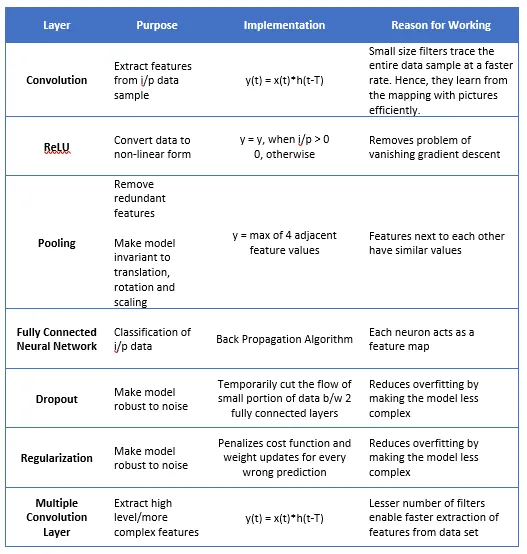

## With Raw Data

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials[1.0], trials[2.0], trials[3.0], trials[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
X_train_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
X_test_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(60, 1000)

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 output classes

model.summary()

Model: "sequential_307"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_659 (Conv1D)         (None, 58, 32)            96032     
                                                                 
 max_pooling1d_308 (MaxPool  (None, 29, 32)            0         
 ing1D)                                                          
                                                                 
 conv1d_660 (Conv1D)         (None, 27, 64)            6208      
                                                                 
 max_pooling1d_309 (MaxPool  (None, 13, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_307 (Flatten)       (None, 832)               0         
                                                                 
 dense_619 (Dense)           (None, 128)            

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_308"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_661 (Conv1D)         (None, 58, 64)            192064    
                                                                 
 conv1d_662 (Conv1D)         (None, 56, 64)            12352     
                                                                 
 dropout_308 (Dropout)       (None, 56, 64)            0         
                                                                 
 max_pooling1d_310 (MaxPool  (None, 28, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_308 (Flatten)       (None, 1792)              0         
                                                                 
 dense_621 (Dense)           (None, 100)               179300    
                                                    

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 79ms/step - loss: 9.6697 - accuracy: 0.2617 - val_loss: 6.0609 - val_accuracy: 0.2349 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 17ms/step - loss: 3.9351 - accuracy: 0.5168 - val_loss: 4.9579 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 16ms/step - loss: 2.7179 - accuracy: 0.6376 - val_loss: 3.9657 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 16ms/step - loss: 1.2209 - accuracy: 0.8121 - val_loss: 4.5388 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 16ms/step - loss: 0.6853 - accuracy: 0.8456 - val_loss: 3.6266 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 15ms/step - loss: 0.2526 - accuracy: 0.9128 - val_loss: 4.0531 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 16ms/step - loss: 0.2853 - accuracy

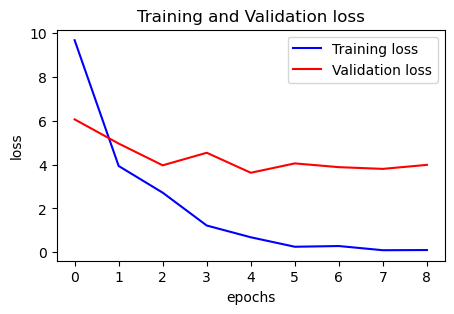

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob_fltr = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob_fltr])
Y_pred_cnn.shape

5/5 [==============================] - 0s 3ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1   2   3   4
Actual label                  
1                7  10  10  11
2                6  15  12   5
3                3  10  13  11
4                5  12  11   8

In [ ]:
# Creating a dictionary to store model performance metrics for various CNN models
cnn_mdl = {}


# Displaying the model performance metrics
cnn_mdl['Raw_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['Raw_data']

{'Accuracy': 29, 'Precision': 29, 'Recall': 29, 'F1_score': 29, 'kappa': 5}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials_filt[1.0], trials_filt[2.0], trials_filt[3.0], trials_filt[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
X_train_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials_filt['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
X_test_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(60, 1000)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_309"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_663 (Conv1D)         (None, 58, 64)            192064    
                                                                 
 conv1d_664 (Conv1D)         (None, 56, 64)            12352     
                                                                 
 dropout_309 (Dropout)       (None, 56, 64)            0         
                                                                 
 max_pooling1d_311 (MaxPool  (None, 28, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_309 (Flatten)       (None, 1792)              0         
                                                                 
 dense_623 (Dense)           (None, 100)               179300    
                                                    

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 83ms/step - loss: 8.2138 - accuracy: 0.2483 - val_loss: 3.4659 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 16ms/step - loss: 4.0912 - accuracy: 0.4228 - val_loss: 2.4215 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 17ms/step - loss: 1.8107 - accuracy: 0.6376 - val_loss: 2.9504 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 16ms/step - loss: 1.4646 - accuracy: 0.6376 - val_loss: 2.6168 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 16ms/step - loss: 1.0997 - accuracy: 0.7852 - val_loss: 2.8273 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.4493 - accuracy: 0.8121 - val_loss: 2.6059 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 16ms/step - loss: 0.5895 - accuracy

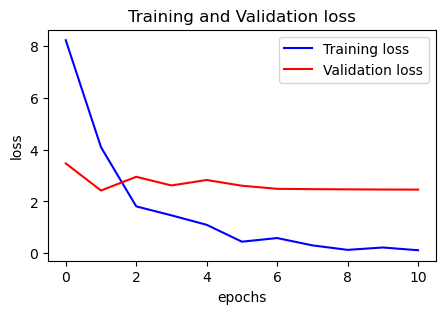

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob_fltr = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob_fltr])
Y_pred_cnn.shape

5/5 [==============================] - 0s 3ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                10   3  11  14
2                11  10   6  11
3                 6   5  14  12
4                 6   4   9  17

In [ ]:
# Displaying the model performance metrics
cnn_mdl['Filtered_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['Filtered_data']

{'Accuracy': 34, 'Precision': 34, 'Recall': 34, 'F1_score': 34, 'kappa': 12}

## With Referenced Data (Common Average Referencing)

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials_car[1.0], trials_car[2.0], trials_car[3.0], trials_car[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
X_train_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the test data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials_car['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
X_test_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(60, 1000)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_310"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_665 (Conv1D)         (None, 58, 64)            192064    
                                                                 
 conv1d_666 (Conv1D)         (None, 56, 64)            12352     
                                                                 
 dropout_310 (Dropout)       (None, 56, 64)            0         
                                                                 
 max_pooling1d_312 (MaxPool  (None, 28, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_310 (Flatten)       (None, 1792)              0         
                                                                 
 dense_625 (Dense)           (None, 100)               179300    
                                                    

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 89ms/step - loss: 4.5649 - accuracy: 0.2685 - val_loss: 3.4871 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 16ms/step - loss: 2.1431 - accuracy: 0.5101 - val_loss: 2.5001 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 15ms/step - loss: 0.9508 - accuracy: 0.6913 - val_loss: 2.0815 - val_accuracy: 0.3826 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 16ms/step - loss: 0.5995 - accuracy: 0.7919 - val_loss: 1.8851 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 16ms/step - loss: 0.3403 - accuracy: 0.8725 - val_loss: 1.9731 - val_accuracy: 0.3826 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 16ms/step - loss: 0.3236 - accuracy: 0.9060 - val_loss: 1.8421 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 15ms/step - loss: 0.2178 - accuracy

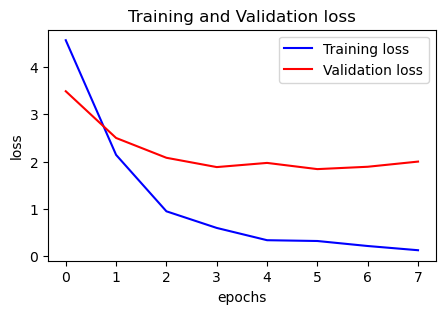

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob_fltr = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob_fltr])
Y_pred_cnn.shape

5/5 [==============================] - 0s 3ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2  3   4
Actual label                  
1                14  13  3   8
2                12  15  3   8
3                 9   6  8  14
4                 5  11  7  13

In [ ]:
# Displaying the model performance metrics
cnn_mdl['Referenced_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['Referenced_data']

{'Accuracy': 34, 'Precision': 34, 'Recall': 34, 'F1_score': 34, 'kappa': 11}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)
print('Shape of log_var trials[3.0]:', trials_logvar[3.0].shape)
print('Shape of log_var trials[4.0]:', trials_logvar[4.0].shape)

Shape of log_var trials[1.0]: (60, 36)
Shape of log_var trials[2.0]: (60, 37)
Shape of log_var trials[3.0]: (60, 38)
Shape of log_var trials[4.0]: (60, 38)


In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_logvar[1.0], 0,1)

x_2 = np.moveaxis(trials_logvar[2.0], 0,1)

x_3 = np.moveaxis(trials_logvar[3.0], 0,1)

x_4 = np.moveaxis(trials_logvar[4.0], 0,1)

x_1.shape, x_2.shape, x_3.shape, x_4.shape

((36, 60), (37, 60), (38, 60), (38, 60))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2, x_3, x_4))
X_train_cnn.shape

(149, 60)

In [ ]:
# First trial data

X_train_cnn[0]

array([2.10475062, 2.07761087, 2.13282812, 2.21143366, 2.00517943,
       2.11648125, 2.15720258, 2.1537791 , 2.1523275 , 1.82244732,
       1.97136811, 2.01645872, 2.08052897, 2.11577034, 2.13968814,
       2.06522774, 1.55080167, 1.74046923, 1.86694332, 2.00545635,
       2.06461949, 2.05965378, 2.01174789, 2.0295782 , 2.00588751,
       0.72985777, 1.26042332, 1.61010833, 1.78484893, 1.92757997,
       2.05514976, 1.96606515, 1.94584889, 1.95294916, 1.88680976,
       1.81434636, 1.10434419, 1.50240654, 1.81514405, 1.92805436,
       2.04263836, 1.99034249, 1.95866887, 1.94500903, 1.85987713,
       1.42395273, 1.66129544, 1.81553253, 1.90081987, 1.92035609,
       1.90851834, 1.86416878, 1.65713688, 1.8509301 , 1.95819635,
       1.93388412, 1.91962287, 2.00650469, 1.95472597, 1.91991231])

But the data above dosent has the sequence_length dimension, so we will create a blank dimension to work with CNN

In [ ]:
X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 60, 1)

In [ ]:
# First trial data

X_train_cnn[0]

array([[2.10475062],
       [2.07761087],
       [2.13282812],
       [2.21143366],
       [2.00517943],
       [2.11648125],
       [2.15720258],
       [2.1537791 ],
       [2.1523275 ],
       [1.82244732],
       [1.97136811],
       [2.01645872],
       [2.08052897],
       [2.11577034],
       [2.13968814],
       [2.06522774],
       [1.55080167],
       [1.74046923],
       [1.86694332],
       [2.00545635],
       [2.06461949],
       [2.05965378],
       [2.01174789],
       [2.0295782 ],
       [2.00588751],
       [0.72985777],
       [1.26042332],
       [1.61010833],
       [1.78484893],
       [1.92757997],
       [2.05514976],
       [1.96606515],
       [1.94584889],
       [1.95294916],
       [1.88680976],
       [1.81434636],
       [1.10434419],
       [1.50240654],
       [1.81514405],
       [1.92805436],
       [2.04263836],
       [1.99034249],
       [1.95866887],
       [1.94500903],
       [1.85987713],
       [1.42395273],
       [1.66129544],
       [1.815

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(0.33708381749849037, 5.601130531319406)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

In [ ]:
Y_train_cnn[:5]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1], dtype=uint8)

### Preparing the testing data

In [ ]:
# Band-pass filtered Data
test_trials_filt['Test'].shape

(60, 1000, 149)

In [ ]:
# Performing the log-var transformation
test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}
test_trials_logvar['Test'].shape

(60, 149)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_logvar['Test'], 0,1)
X_test_cnn.shape

(149, 60)

In [ ]:
# Adding a blank dimension for sequence_length

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 60, 1)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(0.03810823659865608, 0.9144880704059571)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

In [ ]:
Y_test_cnn[:5]

array([[0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=uint8)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1], dtype=uint8)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(60, 1)

In [ ]:
# Number of classes in the data

num_classes = Y_train_cnn.shape[1]
num_classes

4

In [ ]:
try:
  del model
except:
  pass

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 output classes

model.summary()

Model: "sequential_311"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_667 (Conv1D)         (None, 58, 32)            128       
                                                                 
 max_pooling1d_313 (MaxPool  (None, 29, 32)            0         
 ing1D)                                                          
                                                                 
 conv1d_668 (Conv1D)         (None, 27, 64)            6208      
                                                                 
 max_pooling1d_314 (MaxPool  (None, 13, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_311 (Flatten)       (None, 832)               0         
                                                                 
 dense_627 (Dense)           (None, 128)            

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 52ms/step - loss: 1.4688 - accuracy: 0.2349 - val_loss: 1.4052 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 1.4050 - accuracy: 0.2685 - val_loss: 1.3671 - val_accuracy: 0.2685 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 1.3938 - accuracy: 0.2617 - val_loss: 1.3591 - val_accuracy: 0.2685 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 1.3645 - accuracy: 0.3490 - val_loss: 1.3532 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 1.3657 - accuracy: 0.3087 - val_loss: 1.3483 - val_accuracy: 0.4698 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 10ms/step - loss: 1.3627 - accuracy: 0.2953 - val_loss: 1.3398 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 10ms/step - loss: 1.3295 - accuracy

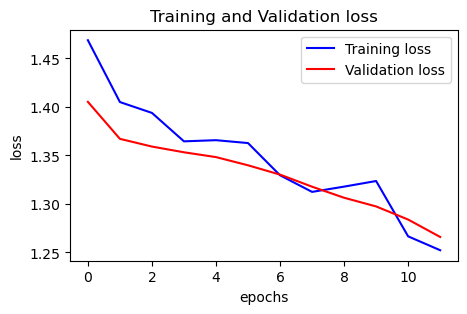

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob_lvar = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob_lvar])
Y_pred_cnn.shape

5/5 [==============================] - 0s 1ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3  4
Actual label                  
1                20  12   4  2
2                14  21   3  0
3                 7   1  28  1
4                 2   1  29  4

In [ ]:
# Displaying the model performance metrics
cnn_mdl['LogVar_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['LogVar_tsfm']

{'Accuracy': 49, 'Precision': 49, 'Recall': 49, 'F1_score': 49, 'kappa': 32}

## With Transformed Data: Common Spatial Pattern (CSP)

### Preparing the training data

In [ ]:
X_train_cnn = X_train_csp.copy()
X_train_cnn.shape

(149, 8)

In [ ]:
# Reshaping to add a blank dimension

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 8, 1)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(149, 4)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1], dtype=uint8)

### Preparing the testing data

In [ ]:
X_test_cnn = X_test_csp.copy()
X_test_cnn.shape

(149, 8)

In [ ]:
# Reshaping to add a blank dimension

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 8, 1)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(0.011483668638455615, 0.8802878012153992)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(149, 4)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1], dtype=uint8)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(8, 1)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_313"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_671 (Conv1D)         (None, 6, 64)             256       
                                                                 
 conv1d_672 (Conv1D)         (None, 4, 64)             12352     
                                                                 
 dropout_313 (Dropout)       (None, 4, 64)             0         
                                                                 
 max_pooling1d_316 (MaxPool  (None, 2, 64)             0         
 ing1D)                                                          
                                                                 
 flatten_313 (Flatten)       (None, 128)               0         
                                                                 
 dense_631 (Dense)           (None, 100)               12900     
                                                    

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 50ms/step - loss: 1.2830 - accuracy: 0.4765 - val_loss: 1.2268 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 1.1480 - accuracy: 0.6577 - val_loss: 1.1148 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 9ms/step - loss: 0.9923 - accuracy: 0.6980 - val_loss: 0.9981 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 9ms/step - loss: 0.8922 - accuracy: 0.6711 - val_loss: 0.9039 - val_accuracy: 0.6980 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 9ms/step - loss: 0.8008 - accuracy: 0.7114 - val_loss: 0.8197 - val_accuracy: 0.7114 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 0.6736 - accuracy: 0.7718 - val_loss: 0.7648 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 0.6381 - accuracy: 0.80

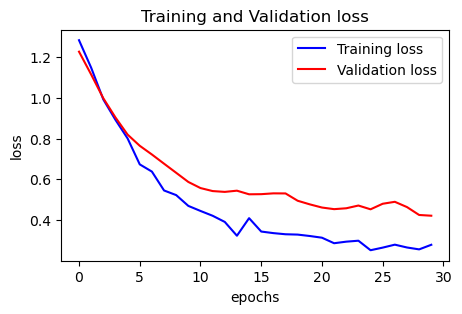

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 1ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                25  12   0   1
2                 4  33   0   1
3                 1   2  32   2
4                 0   0   1  35

In [ ]:
# Displaying the model performance metrics
cnn_mdl['CSP_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['CSP_tsfm']

{'Accuracy': 84, 'Precision': 84, 'Recall': 84, 'F1_score': 84, 'kappa': 79}

## With Transformed Data: Filter Bank Common Spatial Pattern (FBCSP)

### Preparing the training data

In [ ]:
X_train_cnn = X_train_fbcsp.copy()
X_train_cnn.shape

(149, 6, 5)

In [ ]:
# # Moving the axis

# X_train_cnn = np.moveaxis(X_train_cnn, 1, -1)
# X_train_cnn.shape

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = X_test_fbcsp.copy()
X_test_cnn.shape

(149, 6, 5)

In [ ]:
# # Moving the axis

# X_test_cnn = np.moveaxis(X_test_cnn, 1, -1)
# X_test_cnn.shape

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-4.5787994393322045, 1.2037535661410552)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(6, 5)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_673 (Conv1D)         (None, 4, 64)             1024      
                                                                 
 conv1d_674 (Conv1D)         (None, 2, 64)             12352     
                                                                 
 dropout_314 (Dropout)       (None, 2, 64)             0         
                                                                 
 max_pooling1d_317 (MaxPool  (None, 1, 64)             0         
 ing1D)                                                          
                                                                 
 flatten_314 (Flatten)       (None, 64)                0         
                                                                 
 dense_633 (Dense)           (None, 100)               6500      
                                                    

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 49ms/step - loss: 1.3235 - accuracy: 0.3490 - val_loss: 2.8681 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 8ms/step - loss: 1.2244 - accuracy: 0.5101 - val_loss: 4.4233 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 8ms/step - loss: 1.1073 - accuracy: 0.5436 - val_loss: 5.1559 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 0.9917 - accuracy: 0.6577 - val_loss: 5.7672 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 0.9037 - accuracy: 0.6846 - val_loss: 5.9311 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 8ms/step - loss: 0.7173 - accuracy: 0.8389 - val_loss: 7.7503 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 8ms/step - loss: 0.6376 - accuracy: 0.85

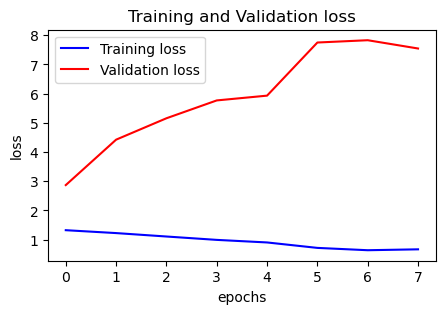

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 1ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   3
Actual label       
1                38
2                38
3                37
4                36

In [ ]:
# Displaying the model performance metrics
cnn_mdl['FBCSP_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['FBCSP_tsfm']

{'Accuracy': 25, 'Precision': 25, 'Recall': 25, 'F1_score': 25, 'kappa': 0}

## With Transformed Data: Power Spectral Density(PSD)

### Preparing the training data

In [ ]:
X_train_cnn = train_psd.copy()
X_train_cnn.shape

(149, 60, 501)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_psd.copy()
X_test_cnn.shape

(149, 60, 501)

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(60, 501)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_315"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_675 (Conv1D)         (None, 58, 64)            96256     
                                                                 
 conv1d_676 (Conv1D)         (None, 56, 64)            12352     
                                                                 
 dropout_315 (Dropout)       (None, 56, 64)            0         
                                                                 
 max_pooling1d_318 (MaxPool  (None, 28, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_315 (Flatten)       (None, 1792)              0         
                                                                 
 dense_635 (Dense)           (None, 100)               179300    
                                                    

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 59ms/step - loss: 1.6838 - accuracy: 0.3960 - val_loss: 1.9661 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 15ms/step - loss: 1.0732 - accuracy: 0.5235 - val_loss: 2.1197 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 13ms/step - loss: 0.8384 - accuracy: 0.6779 - val_loss: 2.4121 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 13ms/step - loss: 0.7552 - accuracy: 0.6711 - val_loss: 2.3634 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 13ms/step - loss: 0.6005 - accuracy: 0.7383 - val_loss: 2.6475 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 13ms/step - loss: 0.4808 - accuracy: 0.8322 - val_loss: 3.2090 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 13ms/step - loss: 0.4665 - accuracy

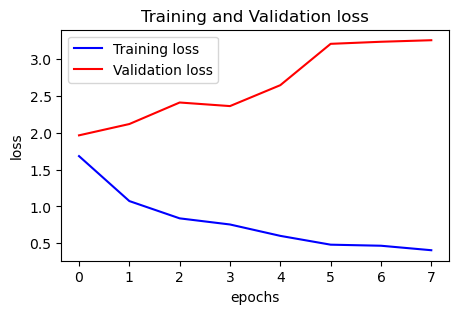

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 2ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                11  11   9   7
2                12   8   9   9
3                11   8   7  11
4                 9   7  12   8

In [ ]:
# Displaying the model performance metrics
cnn_mdl['PSD_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['PSD_tsfm']

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -3}

## With Transformed Data: Hjorth Parameters

### Preparing the training data

In [ ]:
X_train_cnn = train_hjorth.copy()
X_train_cnn.shape

(149, 60, 3)

In [ ]:
# # Moving the axis

# X_train_cnn = np.moveaxis(X_train_cnn, 1, -1)
# X_train_cnn.shape

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_hjorth.copy()
X_test_cnn.shape

(149, 60, 3)

In [ ]:
# # Moving the axis

# X_test_cnn = np.moveaxis(X_test_cnn, 1, -1)
# X_test_cnn.shape

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(60, 3)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_316"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_677 (Conv1D)         (None, 58, 64)            640       
                                                                 
 conv1d_678 (Conv1D)         (None, 56, 64)            12352     
                                                                 
 dropout_316 (Dropout)       (None, 56, 64)            0         
                                                                 
 max_pooling1d_319 (MaxPool  (None, 28, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_316 (Flatten)       (None, 1792)              0         
                                                                 
 dense_637 (Dense)           (None, 100)               179300    
                                                    

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 48ms/step - loss: 3.4281 - accuracy: 0.2349 - val_loss: 1.4936 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 2.0601 - accuracy: 0.2819 - val_loss: 1.4707 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 1.4863 - accuracy: 0.3691 - val_loss: 1.0973 - val_accuracy: 0.4899 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 1.1921 - accuracy: 0.4564 - val_loss: 1.0480 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 1.0005 - accuracy: 0.5034 - val_loss: 1.0381 - val_accuracy: 0.5436 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 10ms/step - loss: 0.9358 - accuracy: 0.5503 - val_loss: 0.9406 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 10ms/step - loss: 1.0241 - accuracy

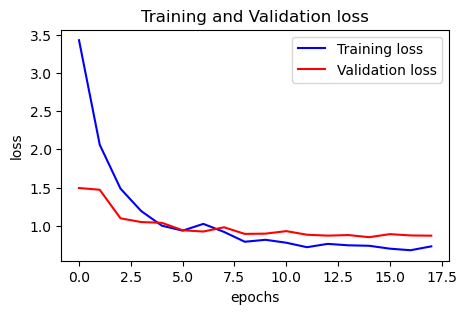

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 1ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                23  11   2   2
2                12  22   0   4
3                 6   2  21   8
4                 0   2  12  22

In [ ]:
# Displaying the model performance metrics
cnn_mdl['Hjorth_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['Hjorth_tsfm']

{'Accuracy': 59, 'Precision': 59, 'Recall': 59, 'F1_score': 59, 'kappa': 45}

## With Transformed Data: Singular Value Decomposition(SVD)

### Preparing the training data

In [ ]:
X_train_cnn = train_svd.copy()
X_train_cnn.shape

(149, 200)

In [ ]:
# Reshaping to add a blank dimension

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 200, 1)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_svd.copy()
X_test_cnn.shape

(149, 200)

In [ ]:
# Reshaping to add a blank dimension

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 200, 1)

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(200, 1)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_317"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_679 (Conv1D)         (None, 198, 64)           256       
                                                                 
 conv1d_680 (Conv1D)         (None, 196, 64)           12352     
                                                                 
 dropout_317 (Dropout)       (None, 196, 64)           0         
                                                                 
 max_pooling1d_320 (MaxPool  (None, 98, 64)            0         
 ing1D)                                                          
                                                                 
 flatten_317 (Flatten)       (None, 6272)              0         
                                                                 
 dense_639 (Dense)           (None, 100)               627300    
                                                    

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 1s 49ms/step - loss: 1.3704 - accuracy: 0.3691 - val_loss: 1.3915 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 13ms/step - loss: 1.2646 - accuracy: 0.4832 - val_loss: 1.4333 - val_accuracy: 0.2215 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 13ms/step - loss: 1.0960 - accuracy: 0.6174 - val_loss: 1.5557 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 13ms/step - loss: 0.9302 - accuracy: 0.6846 - val_loss: 1.7743 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 12ms/step - loss: 0.8528 - accuracy: 0.6510 - val_loss: 2.0226 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.8023 - accuracy: 0.7047 - val_loss: 2.1168 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 0.7588 - accuracy

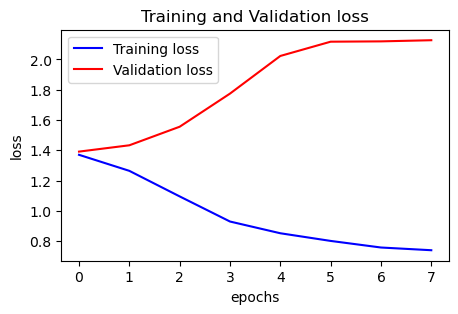

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 2ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                 9  12   6  11
2                10   9  15   4
3                 9  12   7   9
4                 8  10   8  10

In [ ]:
# Displaying the model performance metrics
cnn_mdl['SVD_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['SVD_tsfm']

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -2}

## **CNN Models comparison**

In [ ]:
pd.DataFrame(cnn_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Raw_data               29         29      29        29      5
Filtered_data          34         34      34        34     12
Referenced_data        34         34      34        34     11
LogVar_tsfm            49         49      49        49     32
CSP_tsfm               84         84      84        84     79
FBCSP_tsfm             25         25      25        25      0
PSD_tsfm               23         23      23        23     -3
Hjorth_tsfm            59         59      59        59     45
SVD_tsfm               23         23      23        23     -2

# ResNet Classifier (with Transfer Learning)

https://keras.io/api/applications/resnet/

ResNet expects data to be of minimum 32x32x3 shape, where 32x32 are image height & width and 3 is number of channels.

## With Transformed Data: Wavelet

### Preparing the training data

In [ ]:
X_train_cnn = train_wave_coeff.copy()
X_train_cnn.shape

(149, 60, 127, 1000)

In [ ]:
# Making channel as the last dimension

X_train_cnn = np.moveaxis(X_train_cnn, 1, -1)
X_train_cnn.shape

(149, 127, 1000, 60)

ResNet allows only 3 channels, so we will select top 3 channels with maximum information

In [ ]:
# Compute the information measure for each channel

channel_variances = np.var(X_train_cnn, axis=(0,1,2))
channel_variances.shape

(60,)

In [ ]:
# Find the indices of the top 3 channels with the highest variance
top_3_indices = np.argsort(channel_variances)[-3:]

In [ ]:
# Print the indices of the top 3 channels
print("Indices of the top 3 channels:", top_3_indices)

# Print the variance values of the top 3 channels
print("Variance of the top 3 channels:", channel_variances[top_3_indices])

Indices of the top 3 channels: [57 54 58]
Variance of the top 3 channels: [60.02294648 69.05356732 69.63463403]


In [ ]:
# Selecting the data for the identified channels

X_train_cnn = X_train_cnn[:,:,:,top_3_indices]
X_train_cnn.shape

(149, 127, 1000, 3)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_wave_coeff.copy()
X_test_cnn.shape

(149, 60, 127, 1000)

In [ ]:
# Making channel as the last dimension

X_test_cnn = np.moveaxis(X_test_cnn, 1, -1)
X_test_cnn.shape

(149, 127, 1000, 60)

In [ ]:
# Selecting the data for the identified channels

X_test_cnn = X_test_cnn[:,:,:,top_3_indices]
X_test_cnn.shape

(149, 127, 1000, 3)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h,w,c

(127, 1000, 3)

In [ ]:
# Importing a pre-trained model without the final output layer

pretrained_model = ResNet50(input_shape=(h, w, c), include_top=False, weights='imagenet')

In [ ]:
# Creating new model by adding the output layer

model = keras.Sequential([pretrained_model,
                              Flatten(),
                              Dense(units=60, activation='relu'),
                              Dense(units=num_classes, activation='softmax')])

model.summary()

Model: "sequential_318"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 32, 2048)       23587712  
                                                                 
 flatten_318 (Flatten)       (None, 262144)            0         
                                                                 
 dense_641 (Dense)           (None, 60)                15728700  
                                                                 
 dense_642 (Dense)           (None, 4)                 244       
                                                                 
Total params: 39316656 (149.98 MB)
Trainable params: 39263536 (149.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 47s 6s/step - loss: 18.1909 - accuracy: 0.2819 - val_loss: 9568.2178 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 28s 6s/step - loss: 2.3893 - accuracy: 0.3490 - val_loss: 65523.3203 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 29s 6s/step - loss: 1.8608 - accuracy: 0.3624 - val_loss: 151527.1094 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 28s 6s/step - loss: 1.2949 - accuracy: 0.4094 - val_loss: 229772.5156 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 29s 6s/step - loss: 1.3280 - accuracy: 0.4765 - val_loss: 121125.1172 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 28s 6s/step - loss: 1.1272 - accuracy: 0.5235 - val_loss: 43083.7734 - val_accuracy: 0.2550 - lr: 0.0010


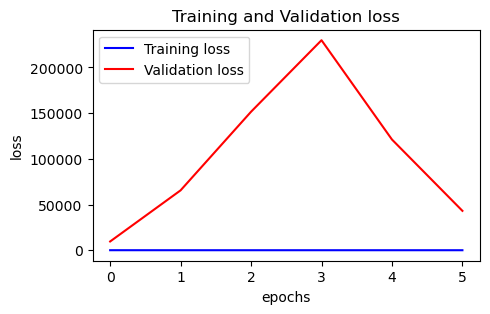

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 7s 1s/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   2
Actual label       
1                38
2                38
3                37
4                36

In [ ]:
# Displaying the model performance metrics
cnn_mdl['Wavelet_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['Wavelet_tsfm']

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 0}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
X_train = train_stft.copy()
X_train.shape

(149, 501, 3, 60)

In [ ]:
# Seperating the magnitude information

X_train_cnn = np.abs(X_train)
X_train_cnn.shape

(149, 501, 3, 60)

In [ ]:
# Moving the last dimension

X_train_cnn = np.moveaxis(X_train_cnn, -2, -1)
X_train_cnn.shape

(149, 501, 60, 3)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test = test_stft.copy()
X_test.shape

(149, 501, 3, 60)

In [ ]:
# Seperating the magnitude information

X_test_cnn = np.abs(X_test)
X_test_cnn.shape

(149, 501, 3, 60)

In [ ]:
# Moving the last dimension

X_test_cnn = np.moveaxis(X_test_cnn, -2, -1)
X_test_cnn.shape

(149, 501, 60, 3)

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h,w,c

(501, 60, 3)

In [ ]:
# Importing a pre-trained model without the final output layer

pretrained_model = ResNet50(input_shape=(h, w, c), include_top=False, weights='imagenet')

In [ ]:
# Creating new model by adding the output layer

model = keras.Sequential([pretrained_model,
                              Flatten(),
                              Dense(units=60, activation='relu'),
                              Dense(units=num_classes, activation='softmax')])

model.summary()

Model: "sequential_319"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 2, 2048)       23587712  
                                                                 
 flatten_319 (Flatten)       (None, 65536)             0         
                                                                 
 dense_643 (Dense)           (None, 60)                3932220   
                                                                 
 dense_644 (Dense)           (None, 4)                 244       
                                                                 
Total params: 27520176 (104.98 MB)
Trainable params: 27467056 (104.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 21s 2s/step - loss: 6.4224 - accuracy: 0.2752 - val_loss: 52.0006 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 6s 1s/step - loss: 1.9750 - accuracy: 0.4027 - val_loss: 3113.4993 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 6s 1s/step - loss: 1.1397 - accuracy: 0.5906 - val_loss: 19333.5527 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 6s 1s/step - loss: 0.9233 - accuracy: 0.6711 - val_loss: 17696.5039 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 6s 1s/step - loss: 0.6363 - accuracy: 0.7785 - val_loss: 13709.9258 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 6s 1s/step - loss: 0.5474 - accuracy: 0.7987 - val_loss: 6257.0073 - val_accuracy: 0.2483 - lr: 0.0010


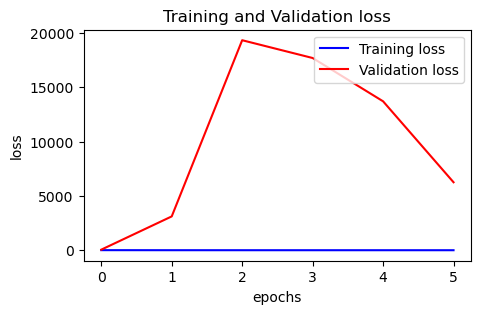

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 2s 217ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   3
Actual label       
1                38
2                38
3                37
4                36

In [ ]:
# Displaying the model performance metrics
cnn_mdl['STFT_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
cnn_mdl['STFT_tsfm']

{'Accuracy': 25, 'Precision': 25, 'Recall': 25, 'F1_score': 25, 'kappa': 0}

## **CNN Models comparison**

In [ ]:
pd.DataFrame(cnn_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Raw_data               29         29      29        29      5
Filtered_data          34         34      34        34     12
Referenced_data        34         34      34        34     11
LogVar_tsfm            49         49      49        49     32
CSP_tsfm               84         84      84        84     79
FBCSP_tsfm             25         25      25        25      0
PSD_tsfm               23         23      23        23     -3
Hjorth_tsfm            59         59      59        59     45
SVD_tsfm               23         23      23        23     -2
Wavelet_tsfm           26         26      26        26      0
STFT_tsfm              25         25      25        25      0

# LDA Classifier (with shrinkage regularization)

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

## With Transformed Data: Hjorth Parameters

### Preparing the training data

In [ ]:
X_train_lda = train_hjorth.copy()
X_train_lda.shape

(149, 60, 3)

In [ ]:
# # Moving the axis

# X_train_lda = np.moveaxis(X_train_lda, 1, -1)
# X_train_lda.shape

In [ ]:
# Reshaping the data

X_train_lda = X_train_lda.reshape(149, -1)
X_train_lda.shape

(149, 180)

In [ ]:
Y_train_lda = Y_train_rf.copy()
Y_train_lda.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_lda = test_hjorth.copy()
X_test_lda.shape

(149, 60, 3)

In [ ]:
# # Moving the axis

# X_test_lda = np.moveaxis(X_test_lda, 1, -1)
# X_test_lda.shape

In [ ]:
# Reshaping the data

X_test_lda = X_test_lda.reshape(149, -1)
X_test_lda.shape

(149, 180)

In [ ]:
Y_test_lda = Y_test_rf.copy()
Y_test_lda.shape

(149,)

### Training the model

In [ ]:
# Create and train a LDA Classifier

ldac = LDA(solver='eigen', shrinkage='auto')
ldac.fit(X_train_lda, Y_train_lda)

LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')

### Testing the model

In [ ]:
# Make predictions
Y_pred_lda = ldac.predict(X_test_lda)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_lda, Y_pred_lda, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                16  20   0   2
2                 5  33   0   0
3                 6   4  19   8
4                 3   1   9  23

In [ ]:
# Creating a dictionary to store model performance metrics for various LDA models
lda_mdl = {}

# Displaying the model performance metrics
lda_mdl['Hajorth_tsfm'] = mdl_eval(Y_test_lda, Y_pred_lda)
lda_mdl['Hajorth_tsfm']

{'Accuracy': 61, 'Precision': 61, 'Recall': 61, 'F1_score': 61, 'kappa': 48}

## With Transformed Data: Common Spatial Pattern (CSP)

### Preparing the training data

In [ ]:
X_train_lda = X_train_csp.copy()
X_train_lda.shape

(149, 8)

In [ ]:
Y_train_lda.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_lda = X_test_csp.copy()
X_test_lda.shape

(149, 8)

In [ ]:
Y_test_lda.shape

(149,)

### Training the model

In [ ]:
# Create and train a LDA Classifier

ldac = LDA(solver='lsqr', shrinkage='auto')
ldac.fit(X_train_lda, Y_train_lda)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

### Testing the model

In [ ]:
# Make predictions
Y_pred_lda = ldac.predict(X_test_lda)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_lda, Y_pred_lda, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                31   7   0   0
2                 6  32   0   0
3                 4   1  31   1
4                 2   0   2  32

In [ ]:
# Displaying the model performance metrics
lda_mdl['CSP_tsfm'] = mdl_eval(Y_test_lda, Y_pred_lda)
lda_mdl['CSP_tsfm']

{'Accuracy': 85, 'Precision': 85, 'Recall': 85, 'F1_score': 85, 'kappa': 79}

#### With KPCA selected features

In [ ]:
# Create and train a LDA Classifier
ldac = LDA(solver='lsqr', shrinkage='auto')
ldac.fit(X_train_csp_kpca, Y_train_lda)

# Make predictions
Y_pred_lda = ldac.predict(X_test_csp_kpca)

# Displaying the model performance metrics
mdl_eval(Y_test_lda, Y_pred_lda)

{'Accuracy': 86, 'Precision': 86, 'Recall': 86, 'F1_score': 86, 'kappa': 81}

## With Transformed Data: Hjorth & CSP combined

### Preparing the training data

In [ ]:
X_train_lda = train_hjorth.copy()
X_train_lda.shape

(149, 60, 3)

In [ ]:
# Reshaping the data

X_train_lda = X_train_lda.reshape(149, -1)
X_train_lda.shape

(149, 180)

In [ ]:
# CSP data
X_train_csp.shape

(149, 8)

In [ ]:
# Concatenating Hajorth & CSP data

X_train_lda = np.concatenate([X_train_lda, X_train_csp], axis=1)
X_train_lda.shape

(149, 188)

In [ ]:
Y_train_lda.shape

(149,)

### Preparing the testing data

In [ ]:
X_test_lda = test_hjorth.copy()
X_test_lda.shape

(149, 60, 3)

In [ ]:
# Reshaping the data

X_test_lda = X_test_lda.reshape(149, -1)
X_test_lda.shape

(149, 180)

In [ ]:
# CSP data
X_test_csp.shape

(149, 8)

In [ ]:
# Concatenating Hajorth & CSP data

X_test_lda = np.concatenate([X_test_lda, X_test_csp], axis=1)
X_test_lda.shape

(149, 188)

In [ ]:
Y_test_lda.shape

(149,)

### Training the model

In [ ]:
# Create and train a LDA Classifier

ldac = LDA(solver='eigen', shrinkage='auto')
ldac.fit(X_train_lda, Y_train_lda)

LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')

### Testing the model

In [ ]:
# Make predictions
Y_pred_lda = ldac.predict(X_test_lda)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_lda, Y_pred_lda, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                27  10   0   1
2                 6  31   1   0
3                 4   0  31   2
4                 1   0   2  33

In [ ]:
# Displaying the model performance metrics
lda_mdl['Hajorth_CSP'] = mdl_eval(Y_test_lda, Y_pred_lda)
lda_mdl['Hajorth_CSP']

{'Accuracy': 82, 'Precision': 82, 'Recall': 82, 'F1_score': 82, 'kappa': 76}

## **LDA Models comparison**

In [ ]:
pd.DataFrame(lda_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Hajorth_tsfm        61         61      61        61     48
CSP_tsfm            85         85      85        85     79
Hajorth_CSP         82         82      82        82     76

# ChronoNet (CNN-RNN) Classifier

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1802.00308.pdf

https://www.kaggle.com/code/robbob62287/chrononet-for-eeg-data-starter

![image.png](attachment:1b80f5ab-7a11-4b9c-9e81-2ecb098bd4c0.png)

## With Raw Data

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials[1.0], trials[2.0], trials[3.0], trials[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
X_train_cnn = np.moveaxis(X_train_cnn, -1, 1)
X_train_cnn.shape

(149, 1000, 60)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
X_test_cnn = np.moveaxis(X_test_cnn, -1, 1)
X_test_cnn.shape

(149, 1000, 60)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Creating a function to implement Chrono-Net

def ChronoNet(input_shape, num_classes=4):

    '''
    Chrono-Net Model

    Parameters
    ----------
    input_shape : shape of each trial i.e h * w

    num_classes : number of classes


    Returns
    -------
    model : Chrono-Net model object

    '''

    h, w = input_shape

    input_layer = Input(shape=input_shape)

    # Creating a sub-function for the Inception Style Convolutional layers
    def block(input):
      conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
      conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
      conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
      x = concatenate([conv1,conv2,conv3],axis=2)
      return x


    block1=block(input_layer)
    block2=block(block1)
    block3=block(block2)


    gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
    gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
    gru_out = concatenate([gru_out1,gru_out2],axis=2)
    gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
    gru_out = concatenate([gru_out1,gru_out2,gru_out3])
    gru_out4 = GRU(32,activation='tanh')(gru_out)


    dense = Dense(num_classes, activation='softmax')(gru_out4)

    model = Model(inputs=input_layer, outputs=dense)


    return model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(1000, 60)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 1000, 60)]           0         []                            
                                                                                                  
 conv1d_708 (Conv1D)         (None, 500, 32)              3872      ['input_11[0][0]']            
                                                                                                  
 conv1d_709 (Conv1D)         (None, 500, 32)              7712      ['input_11[0][0]']            
                                                                                                  
 conv1d_710 (Conv1D)         (None, 500, 32)              15392     ['input_11[0][0]']            
                                                                                            

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 9s 497ms/step - loss: 1.4361 - accuracy: 0.2886 - val_loss: 1.4552 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 1s 159ms/step - loss: 1.3795 - accuracy: 0.2886 - val_loss: 1.3850 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 1s 160ms/step - loss: 1.2336 - accuracy: 0.4564 - val_loss: 1.3668 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 1s 160ms/step - loss: 1.1281 - accuracy: 0.5570 - val_loss: 1.3173 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 1s 156ms/step - loss: 0.9705 - accuracy: 0.7114 - val_loss: 1.2941 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 1s 158ms/step - loss: 0.8336 - accuracy: 0.7651 - val_loss: 1.3063 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 1s 156ms/step - loss: 0.7066 - a

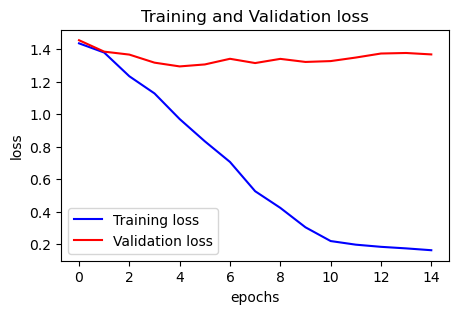

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 28ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                15   8   8   7
2                13  15   3   7
3                 4   8  17   8
4                 3   1  18  14

In [ ]:
# Creating a dictionary to store model performance metrics for various Chrono models
chrono_mdl = {}


# Displaying the model performance metrics
chrono_mdl['Raw_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['Raw_data']

{'Accuracy': 41, 'Precision': 41, 'Recall': 41, 'F1_score': 41, 'kappa': 21}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials_filt[1.0], trials_filt[2.0], trials_filt[3.0], trials_filt[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
X_train_cnn = np.moveaxis(X_train_cnn, -1, 1)
X_train_cnn.shape

(149, 1000, 60)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials_filt['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
X_test_cnn = np.moveaxis(X_test_cnn, -1, 1)
X_test_cnn.shape

(149, 1000, 60)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(1000, 60)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1000, 60)]           0         []                            
                                                                                                  
 conv1d_726 (Conv1D)         (None, 500, 32)              3872      ['input_13[0][0]']            
                                                                                                  
 conv1d_727 (Conv1D)         (None, 500, 32)              7712      ['input_13[0][0]']            
                                                                                                  
 conv1d_728 (Conv1D)         (None, 500, 32)              15392     ['input_13[0][0]']            
                                                                                           

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 9s 498ms/step - loss: 1.4100 - accuracy: 0.2550 - val_loss: 1.3803 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 1s 162ms/step - loss: 1.2754 - accuracy: 0.3758 - val_loss: 1.2876 - val_accuracy: 0.3893 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 1s 161ms/step - loss: 1.1280 - accuracy: 0.5302 - val_loss: 1.2440 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 1s 158ms/step - loss: 1.0167 - accuracy: 0.5839 - val_loss: 1.1649 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 1s 161ms/step - loss: 0.8803 - accuracy: 0.6577 - val_loss: 1.1122 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 1s 158ms/step - loss: 0.7569 - accuracy: 0.7987 - val_loss: 1.1169 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 1s 160ms/step - loss: 0.6792 - a

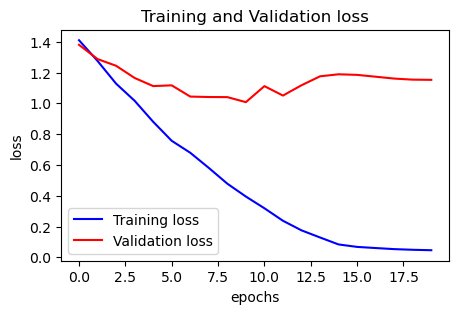

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 28ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                22  10   3   3
2                14  19   1   4
3                 8   4  16   9
4                 2   3  13  18

In [ ]:
# Displaying the model performance metrics
chrono_mdl['Filtered_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['Filtered_data']

{'Accuracy': 50, 'Precision': 50, 'Recall': 50, 'F1_score': 50, 'kappa': 34}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials_logvar[1.0], trials_logvar[2.0], trials_logvar[3.0], trials_logvar[4.0]], axis=-1)
X_train_cnn.shape

(60, 149)

In [ ]:
# Moving the axis

X_train_cnn = np.moveaxis(X_train_cnn, 0,1)
X_train_cnn.shape

(149, 60)

In [ ]:
# Create a blank dimension to work with CNN

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 60, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_trials_logvar['Test']
X_test_cnn.shape

(60, 149)

In [ ]:
# Moving the axis

X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(149, 60)

In [ ]:
# Adding a blank dimension for sequence_length

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 60, 1)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(60, 1)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 60, 1)]              0         []                            
                                                                                                  
 conv1d_744 (Conv1D)         (None, 30, 32)               96        ['input_15[0][0]']            
                                                                                                  
 conv1d_745 (Conv1D)         (None, 30, 32)               160       ['input_15[0][0]']            
                                                                                                  
 conv1d_746 (Conv1D)         (None, 30, 32)               288       ['input_15[0][0]']            
                                                                                           

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 8s 324ms/step - loss: 1.4717 - accuracy: 0.2416 - val_loss: 1.3984 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 26ms/step - loss: 1.3935 - accuracy: 0.3087 - val_loss: 1.3812 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 24ms/step - loss: 1.3779 - accuracy: 0.2215 - val_loss: 1.3733 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 23ms/step - loss: 1.3697 - accuracy: 0.2550 - val_loss: 1.3568 - val_accuracy: 0.3557 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 23ms/step - loss: 1.3491 - accuracy: 0.3758 - val_loss: 1.3356 - val_accuracy: 0.4564 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 23ms/step - loss: 1.3193 - accuracy: 0.4228 - val_loss: 1.2997 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 24ms/step - loss: 1.2970 - accurac

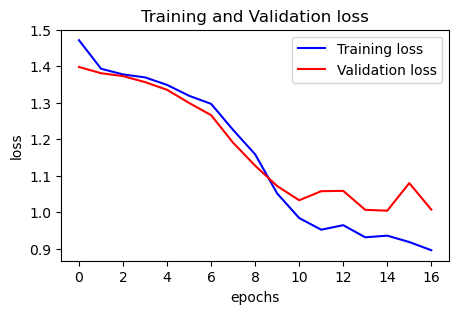

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 3s 5ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                19  10   1   8
2                14  20   0   4
3                 4   1  21  11
4                 2   1  21  12

In [ ]:
# Displaying the model performance metrics
chrono_mdl['LogVar_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['LogVar_tsfm']

{'Accuracy': 48, 'Precision': 48, 'Recall': 48, 'F1_score': 48, 'kappa': 31}

## With Transformed Data: Common Spatial Pattern (CSP)

### Preparing the training data

In [ ]:
X_train_cnn = X_train_csp.copy()
X_train_cnn.shape

(149, 8)

In [ ]:
# Reshaping to add a blank dimension

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 8, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = X_test_csp.copy()
X_test_cnn.shape

(149, 8)

In [ ]:
# Reshaping to add a blank dimension

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 8, 1)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))

Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(8, 1)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

2024-03-17 19:46:17.300401: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 1)]               0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4, 32)                96        ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 4, 32)                160       ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 4, 32)                288       ['input_1[0][0]']             
                                                                                              

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 8s 313ms/step - loss: 1.3769 - accuracy: 0.4295 - val_loss: 1.3521 - val_accuracy: 0.5168 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 13ms/step - loss: 1.3303 - accuracy: 0.6107 - val_loss: 1.2949 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 12ms/step - loss: 1.2515 - accuracy: 0.7181 - val_loss: 1.1994 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 12ms/step - loss: 1.1216 - accuracy: 0.7047 - val_loss: 1.0629 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 12ms/step - loss: 0.9517 - accuracy: 0.7181 - val_loss: 0.9239 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 12ms/step - loss: 0.7877 - accuracy: 0.8188 - val_loss: 0.7968 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 12ms/step - loss: 0.6637 - accurac

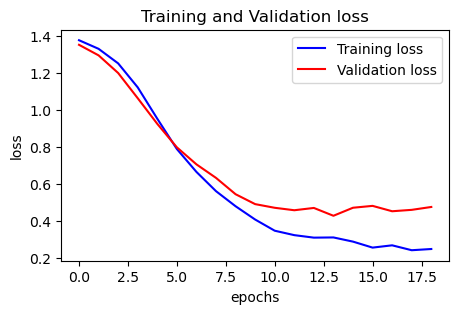

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 2ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                27   7   0   4
2                 4  34   0   0
3                 2   1  33   1
4                 0   1   1  34

In [ ]:
# Displaying the model performance metrics
chrono_mdl['CSP_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['CSP_tsfm']

{'Accuracy': 86, 'Precision': 86, 'Recall': 86, 'F1_score': 86, 'kappa': 81}

## With Transformed Data: Filter Bank Common Spatial Pattern (FBCSP)

### Preparing the training data

In [ ]:
X_train_cnn = X_train_fbcsp.copy()
X_train_cnn.shape

(149, 6, 5)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = X_test_fbcsp.copy()
X_test_cnn.shape

(149, 6, 5)

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(6, 5)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 6, 5)]               0         []                            
                                                                                                  
 conv1d_762 (Conv1D)         (None, 3, 32)                352       ['input_17[0][0]']            
                                                                                                  
 conv1d_763 (Conv1D)         (None, 3, 32)                672       ['input_17[0][0]']            
                                                                                                  
 conv1d_764 (Conv1D)         (None, 3, 32)                1312      ['input_17[0][0]']            
                                                                                           

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 9s 632ms/step - loss: 1.3503 - accuracy: 0.3960 - val_loss: 1.3996 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 15ms/step - loss: 1.2250 - accuracy: 0.5168 - val_loss: 1.4289 - val_accuracy: 0.4295 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 14ms/step - loss: 1.0499 - accuracy: 0.5369 - val_loss: 1.8531 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 14ms/step - loss: 0.8500 - accuracy: 0.8121 - val_loss: 2.1042 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 14ms/step - loss: 0.6653 - accuracy: 0.9128 - val_loss: 2.3252 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 14ms/step - loss: 0.5188 - accuracy: 0.9530 - val_loss: 2.4624 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 14ms/step - loss: 0.4257 - accurac

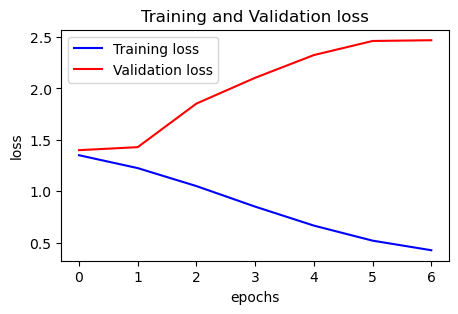

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 2ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   3  4
Actual label          
1                30  8
2                30  8
3                37  0
4                36  0

In [ ]:
# Displaying the model performance metrics
chrono_mdl['FBCSP_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['FBCSP_tsfm']

{'Accuracy': 25, 'Precision': 25, 'Recall': 25, 'F1_score': 25, 'kappa': 0}

## With Transformed Data: Power Spectral Density(PSD)

### Preparing the training data

In [ ]:
X_train_cnn = train_psd.copy()
X_train_cnn.shape

(149, 60, 501)

In [ ]:
# # Moving axis

# X_train_cnn = np.moveaxis(X_train_cnn, -1, 1)
# X_train_cnn.shape

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_psd.copy()
X_test_cnn.shape

(149, 60, 501)

In [ ]:
# # Moving axis

# X_test_cnn = np.moveaxis(X_test_cnn, -1, 1)
# X_test_cnn.shape

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h, w

(60, 501)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 60, 501)]            0         []                            
                                                                                                  
 conv1d_789 (Conv1D)         (None, 30, 32)               32096     ['input_20[0][0]']            
                                                                                                  
 conv1d_790 (Conv1D)         (None, 30, 32)               64160     ['input_20[0][0]']            
                                                                                                  
 conv1d_791 (Conv1D)         (None, 30, 32)               128288    ['input_20[0][0]']            
                                                                                           

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 8s 349ms/step - loss: 1.4540 - accuracy: 0.2953 - val_loss: 1.4649 - val_accuracy: 0.2349 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 31ms/step - loss: 1.2196 - accuracy: 0.4228 - val_loss: 1.5653 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 30ms/step - loss: 1.0281 - accuracy: 0.5436 - val_loss: 1.6758 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 28ms/step - loss: 0.9721 - accuracy: 0.6107 - val_loss: 1.7181 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 28ms/step - loss: 0.8401 - accuracy: 0.6577 - val_loss: 1.8087 - val_accuracy: 0.2349 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 28ms/step - loss: 0.7255 - accuracy: 0.7785 - val_loss: 1.9158 - val_accuracy: 0.2349 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 28ms/step - loss: 0.6336 - accurac

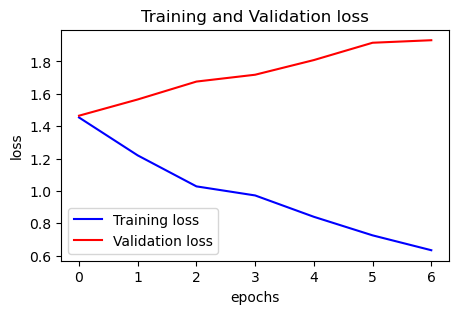

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 6ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                 9  13  12   4
2                11   9  11   7
3                 8  10   8  11
4                 7   9  11   9

In [ ]:
# Displaying the model performance metrics
chrono_mdl['PSD_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['PSD_tsfm']

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -2}

## With Transformed Data: Hjorth Parameters

### Preparing the training data

In [ ]:
X_train_cnn = train_hjorth.copy()
X_train_cnn.shape

(149, 60, 3)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_hjorth.copy()
X_test_cnn.shape

(149, 60, 3)

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(60, 3)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 60, 3)]              0         []                            
                                                                                                  
 conv1d_798 (Conv1D)         (None, 30, 32)               224       ['input_21[0][0]']            
                                                                                                  
 conv1d_799 (Conv1D)         (None, 30, 32)               416       ['input_21[0][0]']            
                                                                                                  
 conv1d_800 (Conv1D)         (None, 30, 32)               800       ['input_21[0][0]']            
                                                                                           

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 10s 715ms/step - loss: 1.3883 - accuracy: 0.3289 - val_loss: 1.3046 - val_accuracy: 0.4094 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 27ms/step - loss: 1.3048 - accuracy: 0.3624 - val_loss: 1.2522 - val_accuracy: 0.3624 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 25ms/step - loss: 1.1785 - accuracy: 0.4899 - val_loss: 1.1621 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 24ms/step - loss: 1.0588 - accuracy: 0.5168 - val_loss: 1.0866 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 24ms/step - loss: 0.9691 - accuracy: 0.6040 - val_loss: 1.0486 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 25ms/step - loss: 0.9055 - accuracy: 0.5570 - val_loss: 1.0840 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 24ms/step - loss: 0.9938 - accura

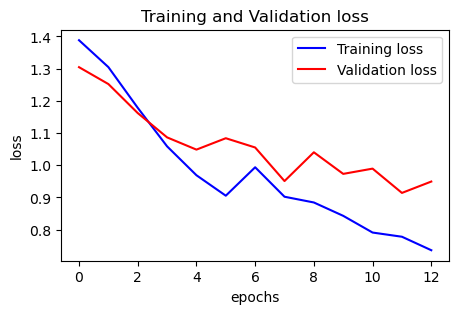

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 5ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1  2   3   4
Actual label                  
1                30  5   0   3
2                28  8   1   1
3                 7  2  22   6
4                 4  1  16  15

In [ ]:
# Displaying the model performance metrics
chrono_mdl['Hjorth_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['Hjorth_tsfm']

{'Accuracy': 50, 'Precision': 50, 'Recall': 50, 'F1_score': 50, 'kappa': 34}

## With Transformed Data: Singular Value Decomposition(SVD)

### Preparing the training data

In [ ]:
X_train_cnn = train_svd.copy()
X_train_cnn.shape

(149, 200)

In [ ]:
# Reshaping to add a blank dimension

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 200, 1)

In [ ]:
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_svd.copy()
X_test_cnn.shape

(149, 200)

In [ ]:
# Reshaping to add a blank dimension

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 200, 1)

In [ ]:
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(200, 1)

In [ ]:
# Initializing the model
input_shape = (h, w)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = ChronoNet(input_shape, num_classes)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_807 (Conv1D)         (None, 100, 32)              96        ['input_22[0][0]']            
                                                                                                  
 conv1d_808 (Conv1D)         (None, 100, 32)              160       ['input_22[0][0]']            
                                                                                                  
 conv1d_809 (Conv1D)         (None, 100, 32)              288       ['input_22[0][0]']            
                                                                                           

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 8s 356ms/step - loss: 1.3888 - accuracy: 0.2550 - val_loss: 1.3870 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 45ms/step - loss: 1.3850 - accuracy: 0.2617 - val_loss: 1.3865 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 44ms/step - loss: 1.3783 - accuracy: 0.3020 - val_loss: 1.3897 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 44ms/step - loss: 1.3568 - accuracy: 0.2752 - val_loss: 1.4054 - val_accuracy: 0.2886 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 43ms/step - loss: 1.3143 - accuracy: 0.3221 - val_loss: 1.4272 - val_accuracy: 0.2148 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 43ms/step - loss: 1.2376 - accuracy: 0.4765 - val_loss: 1.4980 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 43ms/step - loss: 1.1376 - accurac

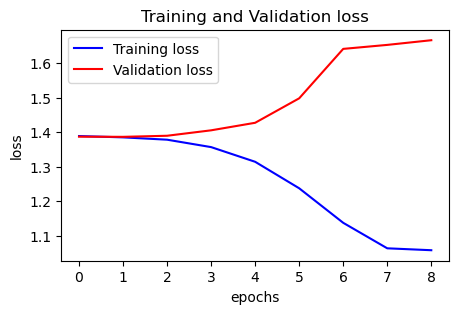

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 1s 9ms/step


(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1  2   3   4
Actual label                  
1                15  2   6  15
2                15  0  14   9
3                14  3   8  12
4                13  2  10  11

In [ ]:
# Displaying the model performance metrics
chrono_mdl['SVD_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
chrono_mdl['SVD_tsfm']

{'Accuracy': 23, 'Precision': 23, 'Recall': 23, 'F1_score': 23, 'kappa': -3}

## **ChronoNet Models comparison**

In [ ]:
pd.DataFrame(chrono_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Raw_data             41         41      41        41     21
Filtered_data        50         50      50        50     34
LogVar_tsfm          48         48      48        48     31
CSP_tsfm             86         86      86        86     81
FBCSP_tsfm           25         25      25        25      0
PSD_tsfm             23         23      23        23     -2
Hjorth_tsfm          50         50      50        50     34
SVD_tsfm             23         23      23        23     -3

# CNN Ensemble

![image.png](attachment:c75eef8e-eba7-4555-8e1a-05b760403505.png)

## With Raw Data

### Preparing the training data

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)
print('Shape of trials[3.0]:', trials[3.0].shape)
print('Shape of trials[4.0]:', trials[4.0].shape)

Shape of trials[1.0]: (60, 1000, 36)
Shape of trials[2.0]: (60, 1000, 37)
Shape of trials[3.0]: (60, 1000, 38)
Shape of trials[4.0]: (60, 1000, 38)


In [ ]:
# Concatenating the training data

X_train = np.concatenate([trials[1.0], trials[2.0], trials[3.0], trials[4.0]], axis=-1)
X_train.shape

(60, 1000, 149)

In [ ]:
# Moving the axis to get shape trials * channels * samples

X_train = np.moveaxis(X_train, -1, 0)
X_train.shape

(149, 60, 1000)

In [ ]:
# Creating a dictionary to store the individual channel data seperately

train_ch_dict = {}

for c in range(60):

    # Getting the channel data
    ch_data = X_train[:,c,:]

    # Adding a blank dimension for CNN
    ch_data = np.expand_dims(ch_data, axis=-1)

    # Filling the channel data in the dictionary
    train_ch_dict[c] = ch_data

In [ ]:
# Checking number of keys
len(train_ch_dict)

60

In [ ]:
# Sample training data for first channel
train_ch_dict[0].shape

(149, 1000, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test = test_trials['Test']
X_test.shape

(60, 1000, 149)

In [ ]:
# Moving the axis to get shape trials * channels * samples

X_test = np.moveaxis(X_test, -1, 0)
X_test.shape

(149, 60, 1000)

In [ ]:
# Creating a dictionary to store the individual channel data seperately

test_ch_dict = {}

for c in range(60):

    # Getting the channel data
    ch_data = X_test[:,c,:]

    # Adding a blank dimension for CNN
    ch_data = np.expand_dims(ch_data, axis=-1)

    # Filling the channel data in the dictionary
    test_ch_dict[c] = ch_data

In [ ]:
# Sample testing data for first channel
test_ch_dict[0].shape

(149, 1000, 1)

In [ ]:
# Getting train labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Creating a function to build a CNN for given train and test data

def base_cnn(X_train, X_test, Y_train=Y_train_cnn, Y_test=Y_test_cnn, num_classes=4):

    # Getting the input shape
    _, h, w = X_train.shape


    # Creating a CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))


    # hyper-parameters
    epochs = 30
    Optimizer = 'Adam'


    # Compiling the model
    model.compile(optimizer=Optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                  EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

    history = model.fit(X_train, Y_train,
                        epochs=epochs, verbose=1, callbacks=callbacks,
                        validation_data=(X_test, Y_test))


    # Make predictions
    train_pred_prob = model.predict(X_train)
    test_pred_prob = model.predict(X_test)



    return train_pred_prob, test_pred_prob

In [ ]:
# Creating a dictionary to store the predictions for each channel, will take ~2mins

train_pred_dict = {}
test_pred_dict = {}

for c in range(60):

    # Getting the channel data
    ch_train_data = train_ch_dict[c]
    ch_test_data = test_ch_dict[c]

    # Getting the prediction probability for the channel data
    train_pred_prob, test_pred_prob = base_cnn(X_train = ch_train_data, X_test = ch_test_data)

    # Filling the channel data in the dictionary
    train_pred_dict[c] = train_pred_prob
    test_pred_dict[c] = test_pred_prob

In [ ]:
# Sample prediction for first channel
test_pred_dict[0].shape

(149, 4)

In [ ]:
# Concatenating all the channel prediction probabilities into one array

train_pred_cons = []
test_pred_cons = []

for c in train_pred_cons.keys():

    train_pred_cons.append(train_pred_dict[c])
    test_pred_cons.append(test_pred_dict[c])

train_pred_cons = np.array(train_pred_cons)
test_pred_cons = np.array(test_pred_cons)

train_pred_cons.shape, test_pred_cons.shape

((60, 149, 4), (60, 149, 4))

In [ ]:
# Moving the axis to get shape trials * channels * base_pred_prob

train_pred_cons = np.moveaxis(train_pred_cons, 1, 0)
test_pred_cons = np.moveaxis(test_pred_cons, 1, 0)

train_pred_cons.shape, test_pred_cons.shape

((149, 60, 4), (149, 60, 4))

In [ ]:
# Getting the final prediction based on the base prediction probabilities

pred_prob = base_cnn(X_train = train_pred_cons, X_test = test_pred_cons)[1]

Epoch 1/30
5/5 [==============================] - 1s 47ms/step - loss: 0.9022 - accuracy: 0.7315 - val_loss: 1.4216 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 0.1484 - accuracy: 1.0000 - val_loss: 1.5839 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 11ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 1.9671 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 11ms/step - loss: 4.1070e-04 - accuracy: 1.0000 - val_loss: 2.3457 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 11ms/step - loss: 6.2952e-05 - accuracy: 1.0000 - val_loss: 2.6365 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 10ms/step - loss: 1.7642e-05 - accuracy: 1.0000 - val_loss: 2.8383 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 2ms/step


### Testing the model

In [ ]:
# Getting the class labels

class_names = np.unique(Y_train_rf)

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label  1  2  3   4
Actual label                
1                6  4  3  25
2                5  7  5  21
3                5  3  3  26
4                3  1  4  28

In [ ]:
# Creating a dictionary to store model performance metrics for various CNN models
ens_mdl = {}


# Displaying the model performance metrics
ens_mdl['Raw_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
ens_mdl['Raw_data']

{'Accuracy': 30, 'Precision': 30, 'Recall': 30, 'F1_score': 30, 'kappa': 7}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)
print('Shape of filtered trials[3.0]:', trials_filt[3.0].shape)
print('Shape of filtered trials[4.0]:', trials_filt[4.0].shape)

Shape of filtered trials[1.0]: (60, 1000, 36)
Shape of filtered trials[2.0]: (60, 1000, 37)
Shape of filtered trials[3.0]: (60, 1000, 38)
Shape of filtered trials[4.0]: (60, 1000, 38)


In [ ]:
# Concatenating the training data

X_train = np.concatenate([trials_filt[1.0], trials_filt[2.0], trials_filt[3.0], trials_filt[4.0]], axis=-1)
X_train.shape

(60, 1000, 149)

In [ ]:
# Moving the axis to get shape trials * channels * samples

X_train = np.moveaxis(X_train, -1, 0)
X_train.shape

(149, 60, 1000)

In [ ]:
# Creating a dictionary to store the individual channel data seperately

train_ch_dict = {}

for c in range(60):

    # Getting the channel data
    ch_data = X_train[:,c,:]

    # Adding a blank dimension for CNN
    ch_data = np.expand_dims(ch_data, axis=-1)

    # Filling the channel data in the dictionary
    train_ch_dict[c] = ch_data

In [ ]:
# Checking number of keys
len(train_ch_dict)

60

In [ ]:
# Sample training data for first channel
train_ch_dict[0].shape

(149, 1000, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test = test_trials_filt['Test']
X_test.shape

(60, 1000, 149)

In [ ]:
# Moving the axis to get shape trials * channels * samples

X_test = np.moveaxis(X_test, -1, 0)
X_test.shape

(149, 60, 1000)

In [ ]:
# Creating a dictionary to store the individual channel data seperately

test_ch_dict = {}

for c in range(60):

    # Getting the channel data
    ch_data = X_test[:,c,:]

    # Adding a blank dimension for CNN
    ch_data = np.expand_dims(ch_data, axis=-1)

    # Filling the channel data in the dictionary
    test_ch_dict[c] = ch_data

In [ ]:
# Sample testing data for first channel
test_ch_dict[0].shape

(149, 1000, 1)

In [ ]:
# Getting train labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Creating a dictionary to store the predictions for each channel, will take ~2mins

train_pred_dict = {}
test_pred_dict = {}

for c in range(60):

    # Getting the channel data
    ch_train_data = train_ch_dict[c]
    ch_test_data = test_ch_dict[c]

    # Getting the prediction probability for the channel data
    train_pred_prob, test_pred_prob = base_cnn(X_train = ch_train_data, X_test = ch_test_data)

    # Filling the channel data in the dictionary
    train_pred_dict[c] = train_pred_prob
    test_pred_dict[c] = test_pred_prob

Epoch 1/30
5/5 [==============================] - 1s 60ms/step - loss: 4.1825 - accuracy: 0.2282 - val_loss: 1.9223 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 24ms/step - loss: 1.6385 - accuracy: 0.3893 - val_loss: 1.4035 - val_accuracy: 0.2215 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 24ms/step - loss: 1.2315 - accuracy: 0.5235 - val_loss: 1.3745 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 24ms/step - loss: 1.1779 - accuracy: 0.4832 - val_loss: 1.3811 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 24ms/step - loss: 1.0554 - accuracy: 0.6040 - val_loss: 1.4014 - val_accuracy: 0.2685 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 25ms/step - loss: 0.8444 - accuracy: 0.6980 - val_loss: 1.4812 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 23ms/step - loss: 0.6426 - accuracy

In [ ]:
pred_ch_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [ ]:
# Sample prediction for first channel
test_pred_dict[0].shape

(149, 4)

In [ ]:
# Concatenating all the channel prediction probabilities into one array

train_pred_cons = []
test_pred_cons = []

for c in pred_ch_dict.keys():

    train_pred_cons.append(train_pred_dict[c])
    test_pred_cons.append(test_pred_dict[c])

train_pred_cons = np.array(train_pred_cons)
test_pred_cons = np.array(test_pred_cons)

train_pred_cons.shape, test_pred_cons.shape

((60, 149, 4), (60, 149, 4))

In [ ]:
# Moving the axis to get shape trials * channels * base_pred_prob

train_pred_cons = np.moveaxis(train_pred_cons, 1, 0)
test_pred_cons = np.moveaxis(test_pred_cons, 1, 0)

train_pred_cons.shape, test_pred_cons.shape

((149, 60, 4), (149, 60, 4))

In [ ]:
# Getting the final prediction based on the base prediction probabilities

pred_prob = base_cnn(X_train = train_pred_cons, X_test = test_pred_cons)[1]

Epoch 1/30
5/5 [==============================] - 1s 45ms/step - loss: 1.0494 - accuracy: 0.7852 - val_loss: 1.3594 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 0s 11ms/step - loss: 0.2529 - accuracy: 1.0000 - val_loss: 1.4550 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 0s 10ms/step - loss: 0.0181 - accuracy: 1.0000 - val_loss: 1.8341 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 0s 10ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.2506 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 0s 10ms/step - loss: 3.4457e-04 - accuracy: 1.0000 - val_loss: 2.5577 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 0s 10ms/step - loss: 1.0296e-04 - accuracy: 1.0000 - val_loss: 2.7632 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 0s 10ms/step - loss: 3.9566e-0

### Testing the model

In [ ]:
# Getting the class labels

class_names = np.unique(Y_train_rf)

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3  4
Actual label                  
1                12  11  12  3
2                15  13   9  1
3                12   3  18  4
4                12   9  11  4

In [ ]:
# Displaying the model performance metrics
ens_mdl['Filtered_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
ens_mdl['Filtered_data']

{'Accuracy': 32, 'Precision': 32, 'Recall': 32, 'F1_score': 32, 'kappa': 9}

## **CNN Ensemble Models comparison**

In [ ]:
pd.DataFrame(ens_mdl).T

Accuracy  Precision  Recall  F1_score  kappa
Raw_data             30         30      30        30      7
Filtered_data        32         32      32        32      9

# EEG Net

https://ar5iv.labs.arxiv.org/html/1611.08024

https://www.kaggle.com/code/anchaliyayash/eegnet

**Overall visualization of the EEGNet architecture**.

Lines denote the convolutional kernel connectivity between inputs and outputs (called feature maps) . The network starts with a temporal convolution (second column) to learn frequency filters, then uses a depthwise convolution (middle column), connected to each feature map individually, to learn frequency-specific spatial filters. The separable convolution (fourth column) is a combination of a depthwise convolution, which learns a temporal summary for each feature map individually, followed by a pointwise convolution, which learns how to optimally mix the feature maps together.

![image.png](attachment:974b5554-170e-4a33-b88f-98b30ab7124f.png)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, Dropout, Flatten, Dense
from keras.layers import DepthwiseConv2D, SeparableConv2D
from keras.constraints import max_norm

## With Raw Data

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials[1.0], trials[2.0], trials[3.0], trials[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
#X_train_cnn = np.moveaxis(X_train_cnn, -1, 1)
X_train_cnn.shape

(149, 60, 1000)

In [ ]:
# Reshaping to add a blank dimension

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 60, 1000, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
#X_test_cnn = np.moveaxis(X_test_cnn, -1, 1)
X_test_cnn.shape

(149, 60, 1000)

In [ ]:
# Reshaping to add a blank dimension

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 60, 1000, 1)

In [ ]:
Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Creating a function to implement EEG Net

def EEGNet(input_shape, num_classes=4):

    '''
    EEG Net Model

    Parameters
    ----------
    input_shape : shape of each trial i.e h * w * ch

    num_classes : number of classes


    Returns
    -------
    model : EEG model object

    '''


    h, w, ch = input_shape

    input_layer = Input(shape=input_shape)

    # First convolutional layer
    conv1 = Conv2D(8, (1, 128), padding='same', input_shape=input_shape, use_bias=False)(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = DepthwiseConv2D((ch, 1), depth_multiplier=2, depthwise_constraint = max_norm(1.))(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('elu')(conv1)
    conv1 = AveragePooling2D((1, 4))(conv1)
    conv1 = Dropout(0.25)(conv1)

    # Second convolutional layer
    conv2 = SeparableConv2D(16, (32, 1), padding='same', use_bias=False)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('elu')(conv2)
    conv2 = AveragePooling2D((1, 8))(conv2)
    conv2 = Dropout(0.25)(conv2)

    flatten = Flatten()(conv2)

    dense = Dense(num_classes, activation='softmax')(flatten)

    model = Model(inputs=input_layer, outputs=dense)

    return model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h, w, c

(60, 1000, 1)

In [ ]:
# Initializing the model
input_shape = (h, w, c)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = EEGNet(input_shape, num_classes)
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 60, 1000, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 1000, 8)       1024      
                                                                 
 batch_normalization_3 (Bat  (None, 60, 1000, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 60, 1000, 16)      32        
 iseConv2D)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 60, 1000, 16)      64        
 chNormalization)                                                
                                                          

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 10s 2s/step - loss: 2.3281 - accuracy: 0.2550 - val_loss: 1.4203 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 9s 2s/step - loss: 0.9061 - accuracy: 0.6779 - val_loss: 1.4004 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 9s 2s/step - loss: 0.5898 - accuracy: 0.8188 - val_loss: 1.3664 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 9s 2s/step - loss: 0.3854 - accuracy: 0.8792 - val_loss: 1.3513 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 9s 2s/step - loss: 0.1925 - accuracy: 0.9530 - val_loss: 1.3427 - val_accuracy: 0.3557 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 9s 2s/step - loss: 0.1206 - accuracy: 0.9866 - val_loss: 1.3430 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 9s 2s/step - loss: 0.0681 - accuracy: 0.9866 - va

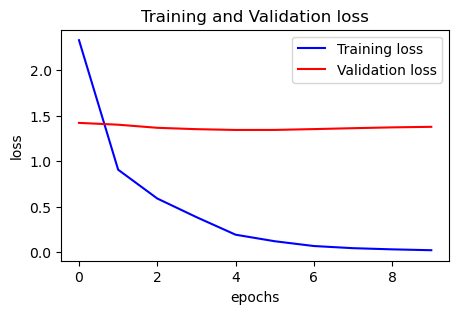

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 75ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2  3  4
Actual label                 
1                14  21  2  1
2                15  18  3  2
3                 9  14  9  5
4                 9  11  8  8

In [ ]:
# Creating a dictionary to store model performance metrics for various EEG models
eeg_mdl = {}


# Displaying the model performance metrics
eeg_mdl['Raw_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
eeg_mdl['Raw_data']

{'Accuracy': 33, 'Precision': 33, 'Recall': 33, 'F1_score': 33, 'kappa': 10}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
# Concatenating the training data

X_train_cnn = np.concatenate([trials_filt[1.0], trials_filt[2.0], trials_filt[3.0], trials_filt[4.0]], axis=-1)
X_train_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_train_cnn = np.moveaxis(X_train_cnn, -1, 0)
#X_train_cnn = np.moveaxis(X_train_cnn, -1, 1)
X_train_cnn.shape

(149, 60, 1000)

In [ ]:
# Reshaping to add a blank dimension

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 60, 1000, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
# Getting the testing data

X_test_cnn = test_trials_filt['Test']
X_test_cnn.shape

(60, 1000, 149)

In [ ]:
# Moving axis to make it in shape trials * channels * samples

X_test_cnn = np.moveaxis(X_test_cnn, -1, 0)
#X_test_cnn = np.moveaxis(X_test_cnn, -1, 1)
X_test_cnn.shape

(149, 60, 1000)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h, w, c

(60, 1000, 1)

In [ ]:
# Initializing the model
input_shape = (h, w, c)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = EEGNet(input_shape, num_classes)
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 60, 1000, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 1000, 8)       1024      
                                                                 
 batch_normalization_12 (Ba  (None, 60, 1000, 8)       32        
 tchNormalization)                                               
                                                                 
 depthwise_conv2d_4 (Depthw  (None, 60, 1000, 16)      32        
 iseConv2D)                                                      
                                                                 
 batch_normalization_13 (Ba  (None, 60, 1000, 16)      64        
 tchNormalization)                                               
                                                          

In [ ]:
# hyper-parameters
epochs = 30
Optimizer = 'Adam'


# Compiling the model
model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 10s 2s/step - loss: 2.0560 - accuracy: 0.3624 - val_loss: 1.3553 - val_accuracy: 0.2617 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 9s 2s/step - loss: 1.3619 - accuracy: 0.4295 - val_loss: 1.2984 - val_accuracy: 0.3356 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 9s 2s/step - loss: 0.9819 - accuracy: 0.5772 - val_loss: 1.2432 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 9s 2s/step - loss: 0.4853 - accuracy: 0.7987 - val_loss: 1.2270 - val_accuracy: 0.3221 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 9s 2s/step - loss: 0.3561 - accuracy: 0.8792 - val_loss: 1.1762 - val_accuracy: 0.4631 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 9s 2s/step - loss: 0.2139 - accuracy: 0.9530 - val_loss: 1.1663 - val_accuracy: 0.5369 - lr: 0.0010
Epoch 7/30
5/5 [==============================] - 9s 2s/step - loss: 0.1823 - accuracy: 0.9732 - va

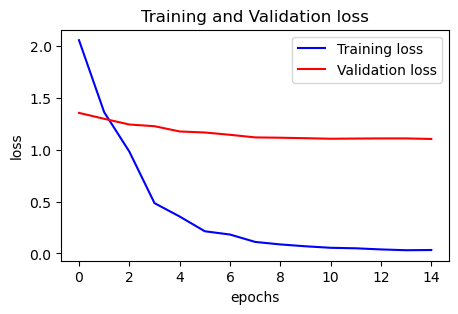

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 77ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                13  22   0   3
2                 7  31   0   0
3                 5   9  10  13
4                 1  10   3  22

In [ ]:
# Displaying the model performance metrics
eeg_mdl['Filtered_data'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
eeg_mdl['Filtered_data']

{'Accuracy': 51, 'Precision': 51, 'Recall': 51, 'F1_score': 51, 'kappa': 35}

## With Transformed Data: Power Spectral Density(PSD)

### Preparing the training data

In [ ]:
X_train_cnn = train_psd.copy()
X_train_cnn.shape

(149, 60, 501)

In [ ]:
# Moving axis

X_train_cnn = np.moveaxis(X_train_cnn, -1, 1)
X_train_cnn.shape

(149, 501, 60)

In [ ]:
# Create a blank dimension to work with CNN

X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(149, 501, 60, 1)

In [ ]:
# Getting train labels

Y_train_cnn = np.array(pd.get_dummies(Y_train_rf))
Y_train_cnn.shape

(149, 4)

### Preparing the testing data

In [ ]:
X_test_cnn = test_psd.copy()
X_test_cnn.shape

(149, 60, 501)

In [ ]:
# Moving axis

X_test_cnn = np.moveaxis(X_test_cnn, -1, 1)
X_test_cnn.shape

(149, 501, 60)

In [ ]:
# Create a blank dimension to work with CNN

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn.shape

(149, 501, 60, 1)

In [ ]:
# Getting test labels

Y_test_cnn = np.array(pd.get_dummies(Y_test_rf))
Y_test_cnn.shape

(149, 4)

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h,w, c

(501, 60, 1)

In [ ]:
# Initializing the model
input_shape = (h, w, c)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = EEGNet(input_shape, num_classes)
model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 501, 60, 1)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 501, 60, 8)        1024      
                                                                 
 batch_normalization_23 (Ba  (None, 501, 60, 8)        32        
 tchNormalization)                                               
                                                                 
 depthwise_conv2d_8 (Depthw  (None, 501, 60, 16)       32        
 iseConv2D)                                                      
                                                                 
 batch_normalization_24 (Ba  (None, 501, 60, 16)       64        
 tchNormalization)                                               
                                                          

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/30
5/5 [==============================] - 4s 632ms/step - loss: 1.5435 - accuracy: 0.3087 - val_loss: 1.3840 - val_accuracy: 0.2752 - lr: 0.0010
Epoch 2/30
5/5 [==============================] - 3s 593ms/step - loss: 1.2160 - accuracy: 0.4430 - val_loss: 1.3843 - val_accuracy: 0.2685 - lr: 0.0010
Epoch 3/30
5/5 [==============================] - 3s 589ms/step - loss: 1.1766 - accuracy: 0.4295 - val_loss: 1.3844 - val_accuracy: 0.2282 - lr: 0.0010
Epoch 4/30
5/5 [==============================] - 3s 588ms/step - loss: 1.1248 - accuracy: 0.4564 - val_loss: 1.3833 - val_accuracy: 0.2349 - lr: 0.0010
Epoch 5/30
5/5 [==============================] - 3s 581ms/step - loss: 0.9943 - accuracy: 0.5705 - val_loss: 1.3835 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 6/30
5/5 [==============================] - 3s 580ms/step - loss: 1.0050 - accuracy: 0.5503 - val_loss: 1.3851 - val_accuracy: 0.2550 - lr: 0.0010


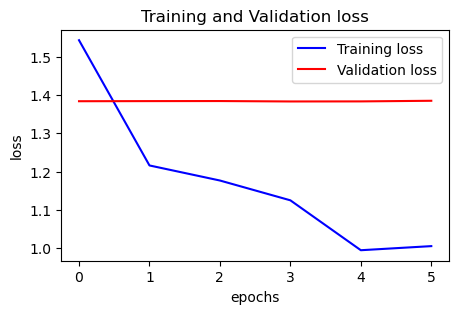

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

5/5 [==============================] - 0s 68ms/step


(149,)

In [ ]:
# Getting the actual test data (without one-hot encoding)
Y_actual_cnn = Y_test_rf.copy()
Y_actual_cnn.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1  2   3   4
Actual label                  
1                 9  3  14  12
2                 5  2  16  15
3                10  2  14  11
4                 6  1  16  13

In [ ]:
# Displaying the model performance metrics
eeg_mdl['PSD_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
eeg_mdl['PSD_tsfm']

{'Accuracy': 26, 'Precision': 26, 'Recall': 26, 'F1_score': 26, 'kappa': 1}

## With Transformed Data: Wavelet

### Preparing the training data

In [ ]:
X_train_cnn = train_wave_coeff.copy()
X_train_cnn.shape

(149, 60, 127, 1000)

In [ ]:
# Making channel as the last dimension

X_train_cnn = np.moveaxis(X_train_cnn, 1, -1)
X_train_cnn.shape

(149, 127, 1000, 60)

In [ ]:
Y_train_cnn.shape

### Preparing the testing data

In [ ]:
X_test_cnn = test_wave_coeff.copy()
X_test_cnn.shape

(149, 60, 127, 1000)

In [ ]:
# Making channel as the last dimension

X_test_cnn = np.moveaxis(X_test_cnn, 1, -1)
X_test_cnn.shape

(149, 127, 1000, 60)

In [ ]:
Y_test_cnn.shape

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h,w,c

In [ ]:
# Initializing the model
input_shape = (h, w, c)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = EEGNet(input_shape, num_classes)
model.summary()

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

In [ ]:
# Displaying the model performance metrics
eeg_mdl['Wavelet_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
eeg_mdl['Wavelet_tsfm']

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
X_train = train_stft.copy()
X_train.shape

(149, 501, 3, 60)

In [ ]:
# Seperating the magnitude information

X_train_cnn = np.abs(X_train)
X_train_cnn.shape

(149, 501, 3, 60)

In [ ]:
# Moving the last dimension

X_train_cnn = np.moveaxis(X_train_cnn, -2, -1)
X_train_cnn.shape

(149, 501, 60, 3)

In [ ]:
Y_train_cnn.shape

### Preparing the testing data

In [ ]:
X_test = test_stft.copy()
X_test.shape

In [ ]:
# Seperating the magnitude information

X_test_cnn = np.abs(X_test)
X_test_cnn.shape

In [ ]:
# # Moving the last dimension

# X_test_cnn = np.moveaxis(X_test_cnn, -2, -1)
# X_test_cnn.shape

In [ ]:
Y_test_cnn.shape

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_cnn.shape
h,w,c

In [ ]:
# Initializing the model
input_shape = (h, w, c)  # Adjust input shape based on your EEG data
num_classes = 4  # Adjust based on the number of classes in your classification task

model = EEGNet(input_shape, num_classes)
model.summary()

In [ ]:
# hyper-parameters

epochs = 30
Optimizer = 'Adam'


# Compiling the model

model.compile(optimizer=Optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)

class_names = np.unique(Y_train_rf)  # Getting the class labels

Y_pred_cnn = np.array([class_names[np.argmax(pred)] for pred in pred_prob])
Y_pred_cnn.shape

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_cnn, rownames=['Actual label'], colnames=['Predicted label'])

In [ ]:
# Displaying the model performance metrics
eeg_mdl['STFT_tsfm'] = mdl_eval(Y_actual_cnn, Y_pred_cnn)
eeg_mdl['STFT_tsfm']

## **EEG Models comparison**

In [ ]:
pd.DataFrame(eeg_mdl).T

# Voting Ensemble

**Overview:**
- **Voting:** Combines predictions from multiple base classifiers.
- **Voting Types:**
  - **Hard Voting:** Predicts the class with the majority of votes.
  - **Soft Voting:** Predicts the class with the highest summed probability across base classifiers.

## With Transformed Data: Common Spatial Pattern (CSP)

In [ ]:
# Base classifiers first prediction

pred_prob_rf[0], pred_prob_svm[0], pred_prob[0]

(array([0.  , 0.  , 0.91, 0.09]),
 array([0.01039798, 0.01546938, 0.92055672, 0.05357591]),
 array([0.00412581, 0.00293801, 0.9756271 , 0.01730899], dtype=float32))

In [ ]:
# Getting the summed probability across base classifiers.
pred_prob_sum = pred_prob_rf + pred_prob_svm + pred_prob
pred_prob_sum.shape

(149, 4)

In [ ]:
pred_prob_sum[0]

array([0.0145238 , 0.01840739, 2.80618384, 0.1608849 ])

In [ ]:
# Getting the prediected class from the probability

Y_pred_vote = np.array([class_names[np.argmax(pred)] for pred in pred_prob_sum])
Y_pred_vote.shape

(149,)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_actual_cnn, Y_pred_vote, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label   1   2   3   4
Actual label                   
1                27   7   1   3
2                 3  35   0   0
3                 2   1  33   1
4                 0   1   1  34

In [ ]:
# Displaying the model performance metrics
mdl_eval(Y_actual_cnn, Y_pred_vote)

{'Accuracy': 87, 'Precision': 87, 'Recall': 87, 'F1_score': 87, 'kappa': 82}